# pasta-stories.py

In [327]:
import json
import os
import requests

from bs4 import BeautifulSoup
from datetime import date, datetime
import lxml.html
from pathlib import Path
from tqdm import tqdm

# Stories Section
import json
import requests

from datetime import date
from pathlib import Path
from time import sleep

# Parser Section
import re

from bs4 import BeautifulSoup
from datetime import datetime
import lxml.html

import pandas as pd

# Get list of stories from listing files

In [328]:
class StoryListingsParser:
    @classmethod
    def parse_listings_get_story_links_per_page(cls, listing_fpath):
        """
        Get list of links per listing_fpath

        listing_fpath: fpath to page_source from 
        https://www.creepypasta.com/archive/?_orderby=date
        example input:
        ./list-pages/2023-07-22__orderby=date&_page=29.html
        
        returns: list of links
        """
        file = open(listing_fpath, "r")
        page_html = file.read()
        file.close()

        soup = BeautifulSoup(page_html, "lxml")
        soup.title
        story_tags = soup.select("a.pt-cv-readmore")

        return [a["href"] for a in story_tags]
    
    @classmethod
    def get_all_story_links(cls, dir_path):
        """
        dir_path: directory where multiple page_source files from
        https://www.creepypasta.com/archive/?_orderby=date

        example input:
        dir_path = "./list-pages/"

        ./list-pages/ dir contains:
        - '2023-07-22__orderby=date&_page=29.html'
        - '2023-07-22__orderby=date&_page=91.html'

        returns: json of all story links in a dict format
        example output:
        {{'2023-07-22__orderby=date&_page=29.html': 
            ['https://www.creepypasta.com/the-scariest-story-ever/',
             'https://www.creepypasta.com/windows-and-notes/'],
        '2023-07-22__orderby=date&_page=91.html': 
            ['https://www.creepypasta.com/three-friends-diner/',
             'https://www.creepypasta.com/written-in-the-stars/',
             'https://www.creepypasta.com/monster-painter/',
             'https://www.creepypasta.com/a-moment-of-horror/']}}
        """
        
        # Get all files in listings directory
        files_list = PageFetcherUtils.get_all_files(dir_path)
        
        all_story_links = {}

        for fpath in files_list:
            if fpath == ".DS_Store":
                continue
            all_story_links[fpath] = cls.parse_listings_get_story_links_per_page(f"{dir_path}{fpath}")

        return all_story_links
    
    @classmethod
    def write_json_of_story_links_dicts(cls, dir_path):
        """
        dir_path: directory where multiple page_source files from
        https://www.creepypasta.com/archive/?_orderby=date

        example input:
        dir_path = "./list-pages/
        
        writes: json w/ get_all_story_links output (story links per page dicts)
        returns: name of new json filepath
        """
        with open(f"./parsed-listings/{date.today()}_story_links.json", "w") as outfile:
            story_links_dict = cls.get_all_story_links(dir_path)
            json.dump(story_links_dict, outfile, sort_keys=True)
            return outfile.name

    @classmethod
    def output_json(cls, dir_path):
        # returns: name of new json filepath to use with CreepyPastaGetter
        # this is just a convenience function for the module
        return cls.write_json_of_story_links_dicts(dir_path)

In [329]:
class StoryListingsParserTestUnit:
    @classmethod
    def test_parse_listings_get_story_links_per_page(cls, listing_fpath=None):
        example_listing_fpath = "./list-pages/2023-07-22__orderby=date&_page=29.html"
        listing_fpath = listing_fpath or example_listing_fpath
        story_links_dict = StoryListingsParser.parse_listings_get_story_links_per_page(listing_fpath)
        return story_links_dict
    
    @classmethod
    def test_get_all_story_links(cls, dir_path=None):
        example_dir_path = "./list-pages/"
        dir_path = dir_path or example_dir_path
        return StoryListingsParser.get_all_story_links(dir_path)
    
    @classmethod
    def test_write_json_of_story_links_dicts(cls, dir_path=None):
        example_dir_path = "./list-pages/"
        dir_path = dir_path or example_dir_path
        return StoryListingsParser.output_json(dir_path)

### Running for reals (not test)

In [330]:
StoryListingsParser.output_json(dir_path="./list-pages/")

'./parsed-listings/2023-07-25_story_links.json'

## Get Stories

In [331]:
class PageFetcherUtils:
    # General utils non-specific to Creepypasta
    @classmethod
    def fetch_page(cls, url):
        # Need for ratings/reviews (live-loaded on site)
        ident = (
        # replace with info
        "Stephanie Andrews (jellomoat@gmail.com), " + 
        "scraping for educational purposes"
        )
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
        }

        print(f"Fetching {url}")
        return requests.get(
            url,
            headers=headers
        )
    
    @classmethod
    def get_html(cls, fpath):
        file = open(fpath, "r")
        page_html = file.read()
        file.close()
        return page_html

    @classmethod
    def get_all_files(cls, dir_path, debug=False):
        # get list of all files in dir
        dir_list = os.listdir(dir_path)

        if debug:
            print("Files and directories in '", path, "' :")
            print(dir_list)
        return dir_list

In [332]:
class CreepyPastaGetter:
    @classmethod
    def get_stories_list_dict(cls, stories_list_fpath):
        with open(stories_list_fpath, "r") as stories_list_file:
            return json.load(stories_list_file)
    
    @classmethod
    def fetch_pasta_pages(cls, list_page, links_list):
        # fetch each page
        for link in links_list:
            dest = Path("story-pages/" + f"published_stories_{link.split('/')[-2]}.html")
            if dest.exists(): # load it from file
                print(f"Already have {dest}, loading!")
                file = open(dest, "r")
                page_html = file.read()
                file.close()
            else: # fetch it!
                page_resp = PageFetcherUtils.fetch_page(link)
                page_html = page_resp.text
                sleep(2)

                # save to file
                with open(dest, "w") as f:
                    f.write(page_html)
                cls.story_writing_log(listing_fname=list_page, dest_fname=dest)

        return None

    @classmethod
    def error_writing_log(cls, exception, listing_fname="testing", dest_fname="testing", logname="error_log"):
        with open(f"{date.today()}_{logname}.txt", "a") as f:
            f.write(f"{listing_fname}, {dest_fname}\n")

    @classmethod
    def story_writing_log(cls, listing_fname="testing", dest_fname="testing", logname="stories_log"):
        with open(f"{date.today()}_{logname}.txt", "a") as f:
            f.write(f"{listing_fname}, {dest_fname}\n")

In [333]:
class CreepyPastaGetterTestUnit:
    @classmethod
    def test_fetch_pasta_pages(cls):
        # fetch per list-pages file, replace params
        CreepyPastaGetter.fetch_pasta_pages(
            list_page="test-list-page", 
            links_list=CreepyPastaSoupParserTestUnit.links_list)    

In [334]:
CreepyPastaGetterTestUnit.test_fetch_pasta_pages()

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!


### Running for reals (not test)

In [335]:
stories_list_fpath = './parsed-listings/2023-07-25_story_links.json'
# filepath is output from StoryListingsParser

stories_list_dict = CreepyPastaGetter.get_stories_list_dict(stories_list_fpath)

for k in stories_list_dict.keys():
    CreepyPastaGetter.fetch_pasta_pages(k, stories_list_dict[k])
    # break after one round if test
    # break

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!
Already have story-pages/published_stories_the-town-of-blanche.html, loading!
Already have story-pages/published_stories_the-church-cellar.html, loading!
Already have story-pages/published_stories_the-toolbox.html, loading!
Already have story-pages/published_stories_a-chat-over-dinner.html, loading!
Already have story-pages/published_stories_your-life-is-a-movie.html, loading!
Already have story-pages/published_stories_the-seven-springs.html, loading!
Already have story-pages/published_stories_the-photograph-pile.html, loading!
Already have story-pages/published_stories_the-forgotten-vending-machine.html, loading!
Already have story-pages/published_stories_the-hooded-being.html, loading!
Already have story-pages/published_stories_in-the-mirror.html, loading!
Already hav

Already have story-pages/published_stories_the-leshy.html, loading!
Already have story-pages/published_stories_entombed.html, loading!
Already have story-pages/published_stories_the-barrow-woman.html, loading!
Already have story-pages/published_stories_roanoke.html, loading!
Already have story-pages/published_stories_44-ashbrooke-lane.html, loading!
Already have story-pages/published_stories_the-loss.html, loading!
Already have story-pages/published_stories_the-sallow-man.html, loading!
Already have story-pages/published_stories_the-pit-2.html, loading!
Already have story-pages/published_stories_capital-punishment.html, loading!
Already have story-pages/published_stories_the-madman-and-the-music.html, loading!
Already have story-pages/published_stories_a-night-terror.html, loading!
Already have story-pages/published_stories_the-choice-in-the-fields.html, loading!
Already have story-pages/published_stories_to-whom-it-may-concern-2.html, loading!
Already have story-pages/published_storie

Already have story-pages/published_stories_the-glass-cabinet.html, loading!
Already have story-pages/published_stories_twenty-fourth.html, loading!
Already have story-pages/published_stories_reminiscence.html, loading!
Already have story-pages/published_stories_amphitheater_tunnels.html, loading!
Already have story-pages/published_stories_haggards-peak.html, loading!
Already have story-pages/published_stories_magic-show-hell.html, loading!
Already have story-pages/published_stories_ed.html, loading!
Already have story-pages/published_stories_what-story.html, loading!
Already have story-pages/published_stories_southpaw-complex.html, loading!
Already have story-pages/published_stories_the-phone-call.html, loading!
Already have story-pages/published_stories_ive-never-woken-place-twice.html, loading!
Already have story-pages/published_stories_fire-and-ice.html, loading!
Already have story-pages/published_stories_feline.html, loading!
Already have story-pages/published_stories_boy-burned-fi

Already have story-pages/published_stories_a-monochromes-melancholy.html, loading!
Already have story-pages/published_stories_summer-eighteen-saved.html, loading!
Already have story-pages/published_stories_maximilian-schafer.html, loading!
Already have story-pages/published_stories_the-smile.html, loading!
Already have story-pages/published_stories_if-i-only-had-a-brain.html, loading!
Already have story-pages/published_stories_the-no-door.html, loading!
Already have story-pages/published_stories_the-carnival.html, loading!
Already have story-pages/published_stories_the-boy.html, loading!
Already have story-pages/published_stories_the-mourner.html, loading!
Already have story-pages/published_stories_oblivions-call.html, loading!
Already have story-pages/published_stories_the-ouiji-fire.html, loading!
Already have story-pages/published_stories_caterpillar.html, loading!
Already have story-pages/published_stories_nightmare-4.html, loading!
Already have story-pages/published_stories_permia

Already have story-pages/published_stories_the-witches-tunnel.html, loading!
Already have story-pages/published_stories_the-hiker.html, loading!
Already have story-pages/published_stories_the-tundra.html, loading!
Already have story-pages/published_stories_incense.html, loading!
Already have story-pages/published_stories_bottle.html, loading!
Already have story-pages/published_stories_dont-stop-believing.html, loading!
Already have story-pages/published_stories_the-reunion.html, loading!
Already have story-pages/published_stories_a-story-from-the-blackguard.html, loading!
Already have story-pages/published_stories_freak-next-door.html, loading!
Already have story-pages/published_stories_these-are-the-lies-we-tell.html, loading!
Already have story-pages/published_stories_my-wife-is-eating-me-alive.html, loading!
Already have story-pages/published_stories_the-church-in-the-woods.html, loading!
Already have story-pages/published_stories_im-a-cop-and-i-institutionalized-someone-i-knew-wasn

Already have story-pages/published_stories_jesus-camp.html, loading!
Already have story-pages/published_stories_worlds-best-school-psychologist.html, loading!
Already have story-pages/published_stories_her-silence.html, loading!
Already have story-pages/published_stories_a-germaphobes-first-love.html, loading!
Already have story-pages/published_stories_the-starry-crown.html, loading!
Already have story-pages/published_stories_home-alone.html, loading!
Already have story-pages/published_stories_salt-in-the-dark-river.html, loading!
Already have story-pages/published_stories_if-youre-armed-and-at-the-glenmont-metro-please-shoot-me.html, loading!
Already have story-pages/published_stories_colwins-corner.html, loading!
Already have story-pages/published_stories_an-unexpected-magi.html, loading!
Already have story-pages/published_stories_beta-test.html, loading!
Already have story-pages/published_stories_tales-from-port-land.html, loading!
Already have story-pages/published_stories_pass-it-

Already have story-pages/published_stories_the-insomnia-problem.html, loading!
Already have story-pages/published_stories_hunters.html, loading!
Already have story-pages/published_stories_world-of-winona.html, loading!
Already have story-pages/published_stories_best-horror-themed-slot-machines.html, loading!
Already have story-pages/published_stories_the-real-reason-my-husband-shot-himself.html, loading!
Already have story-pages/published_stories_please-stay-away-from-wayne-national-forest.html, loading!
Already have story-pages/published_stories_the-burdener.html, loading!
Already have story-pages/published_stories_the-monster-of-nobel-coffee-and-tea.html, loading!
Already have story-pages/published_stories_black-ibis.html, loading!
Already have story-pages/published_stories_fishing-with-clouds-and-teeth.html, loading!
Already have story-pages/published_stories_a-firefighter-found.html, loading!
Already have story-pages/published_stories_something-happened-in-an-irish-border-town-that

Already have story-pages/published_stories_the-hungry-twins.html, loading!
Already have story-pages/published_stories_the-elevator-game.html, loading!
Already have story-pages/published_stories_an-ancient-terror-is-stalking-the-irish-countryside.html, loading!
Already have story-pages/published_stories_11-miles-ritual.html, loading!
Already have story-pages/published_stories_the-deadlands.html, loading!
Already have story-pages/published_stories_brothers-of-drane.html, loading!
Already have story-pages/published_stories_something-watches-over-me-and-it-is-not-an-angel.html, loading!
Already have story-pages/published_stories_i-live-alone-but-theres-a-woman-sitting-on-my-couch.html, loading!
Already have story-pages/published_stories_the-wishing-well-of-heathenberry-forest.html, loading!
Already have story-pages/published_stories_just-one-more.html, loading!
Already have story-pages/published_stories_the-storm.html, loading!
Already have story-pages/published_stories_necromance.html, lo

Already have story-pages/published_stories_best-horror-themed-casino-movies.html, loading!
Already have story-pages/published_stories_mother.html, loading!
Already have story-pages/published_stories_dr-greenwichs-flesh-clinic.html, loading!
Already have story-pages/published_stories_loved.html, loading!
Already have story-pages/published_stories_dont-ignore-the-motion-sensors.html, loading!
Already have story-pages/published_stories_the-john-doe-tapes.html, loading!
Already have story-pages/published_stories_quiapos-shop-of-horrors.html, loading!
Already have story-pages/published_stories_the-backroads-maintenance-tunnels.html, loading!
Already have story-pages/published_stories_the-final-report.html, loading!
Already have story-pages/published_stories_the-man-who-brought-happiness.html, loading!
Already have story-pages/published_stories_10-mystical-video-games-that-give-you-goosebumps.html, loading!
Already have story-pages/published_stories_amongst-the-wreckage.html, loading!
Alread

Already have story-pages/published_stories_odor.html, loading!
Already have story-pages/published_stories_the-beeper-man.html, loading!
Already have story-pages/published_stories_creepy-video-games-that-haunt-gamers-nightmares.html, loading!
Already have story-pages/published_stories_the-dangers-of-conjuring-entities-from-the-underworld.html, loading!
Already have story-pages/published_stories_cryptid-company.html, loading!
Already have story-pages/published_stories_the-strange-glow.html, loading!
Already have story-pages/published_stories_the-counting-man.html, loading!
Already have story-pages/published_stories_7-must-see-horror-movies-for-the-most-dreadful-cinematic-experience.html, loading!
Already have story-pages/published_stories_purgatory-street.html, loading!
Already have story-pages/published_stories_the-house-on-jackson-street.html, loading!
Already have story-pages/published_stories_g-o-ds-journal.html, loading!
Already have story-pages/published_stories_mystery-of-elvis-pr

Already have story-pages/published_stories_the-most-beautiful-thing-in-the-world.html, loading!
Already have story-pages/published_stories_the-deepest-fear.html, loading!
Already have story-pages/published_stories_the-growths.html, loading!
Already have story-pages/published_stories_just-be-careful-out-there.html, loading!
Already have story-pages/published_stories_just-a-meaningless-coincidence.html, loading!
Already have story-pages/published_stories_the-gurgling.html, loading!
Already have story-pages/published_stories_sokushinbutsu.html, loading!
Already have story-pages/published_stories_turn-off-the-light-when-you-leave.html, loading!
Already have story-pages/published_stories_the-red-wristband.html, loading!
Already have story-pages/published_stories_kuchisake-onna.html, loading!
Already have story-pages/published_stories_the-mail-box.html, loading!
Already have story-pages/published_stories_the-houseboat.html, loading!
Already have story-pages/published_stories_hotel-california

Already have story-pages/published_stories_writers-block.html, loading!
Already have story-pages/published_stories_tunnels.html, loading!
Already have story-pages/published_stories_grimm.html, loading!
Already have story-pages/published_stories_onriyu.html, loading!
Already have story-pages/published_stories_just-another-midnight.html, loading!
Already have story-pages/published_stories_poisoned-oak.html, loading!
Already have story-pages/published_stories_how-i-became-a-japanese-urban-legend.html, loading!
Already have story-pages/published_stories_charlotte.html, loading!
Already have story-pages/published_stories_known-only-as-it.html, loading!
Already have story-pages/published_stories_the-kindness-of-strangers.html, loading!
Already have story-pages/published_stories_the-bums-countdown.html, loading!
Already have story-pages/published_stories_the-dark-room.html, loading!
Already have story-pages/published_stories_off-the-beaten-path.html, loading!
Already have story-pages/publishe

Already have story-pages/published_stories_the-most-beautiful-creature.html, loading!
Already have story-pages/published_stories_the-dark.html, loading!
Already have story-pages/published_stories_the-dark-wraith.html, loading!
Already have story-pages/published_stories_the-guestbook-of-elysium.html, loading!
Already have story-pages/published_stories_stomping-grounds.html, loading!
Already have story-pages/published_stories_drewers-inn.html, loading!
Already have story-pages/published_stories_paranoia.html, loading!
Already have story-pages/published_stories_sunlight.html, loading!
Already have story-pages/published_stories_sister.html, loading!
Already have story-pages/published_stories_blue-light-special.html, loading!
Already have story-pages/published_stories_dream-awake.html, loading!
Already have story-pages/published_stories_tran-siberian-express.html, loading!
Already have story-pages/published_stories_where-a-kid-can-be-a-kid.html, loading!
Already have story-pages/published_s

Already have story-pages/published_stories_arrogance.html, loading!
Already have story-pages/published_stories_rift-rlyeh.html, loading!
Already have story-pages/published_stories_whats-matter-jenny.html, loading!
Already have story-pages/published_stories_funny-thing-happened.html, loading!
Already have story-pages/published_stories_sauin.html, loading!
Already have story-pages/published_stories_invitation.html, loading!
Already have story-pages/published_stories_whispers.html, loading!
Already have story-pages/published_stories_let.html, loading!
Already have story-pages/published_stories_farmer-john.html, loading!
Already have story-pages/published_stories_eternal-suicide.html, loading!
Already have story-pages/published_stories_mirror-image.html, loading!
Already have story-pages/published_stories_tlc.html, loading!
Already have story-pages/published_stories_farnsworth-experiments.html, loading!
Already have story-pages/published_stories_till-boys-come-home.html, loading!
Already h

Already have story-pages/published_stories_touch-history.html, loading!
Already have story-pages/published_stories_new-element.html, loading!
Already have story-pages/published_stories_colorado-fishing-trip.html, loading!
Already have story-pages/published_stories_fermi-paradox.html, loading!
Already have story-pages/published_stories_taps.html, loading!
Already have story-pages/published_stories_ordinary-nights.html, loading!
Already have story-pages/published_stories_old-mill-playland.html, loading!
Already have story-pages/published_stories_father-lucie.html, loading!
Already have story-pages/published_stories_ordinary-day.html, loading!
Already have story-pages/published_stories_story.html, loading!
Already have story-pages/published_stories_bugwatching.html, loading!
Already have story-pages/published_stories_girl-vale-station.html, loading!
Already have story-pages/published_stories_beginnings-truly-haunted-house.html, loading!
Already have story-pages/published_stories_cold-love

Already have story-pages/published_stories_the-lonely-stars.html, loading!
Already have story-pages/published_stories_spirits-of-the-caribbean-vwayaje-o-diab.html, loading!
Already have story-pages/published_stories_the-grove-2.html, loading!
Already have story-pages/published_stories_the-run.html, loading!
Already have story-pages/published_stories_26070.html, loading!
Already have story-pages/published_stories_the-dentists-schedule.html, loading!
Already have story-pages/published_stories_the-scourge.html, loading!
Already have story-pages/published_stories_roommate-problems.html, loading!
Already have story-pages/published_stories_looks-like-we-got-a-live-one-here-boys.html, loading!
Already have story-pages/published_stories_thief.html, loading!
Already have story-pages/published_stories_the-new-arcade-in-town.html, loading!
Already have story-pages/published_stories_a-blackstone-family-thanksgiving.html, loading!
Already have story-pages/published_stories_from-perth-to-darwin-a-gh

Already have story-pages/published_stories_lanterns.html, loading!
Already have story-pages/published_stories_outside-lights.html, loading!
Already have story-pages/published_stories_symphonies-about-drowning.html, loading!
Already have story-pages/published_stories_they-were-lying.html, loading!
Already have story-pages/published_stories_buyers-remorse.html, loading!
Already have story-pages/published_stories_a-haunting.html, loading!
Already have story-pages/published_stories_the-old-man-on-the-tape.html, loading!
Already have story-pages/published_stories_the-cottage.html, loading!
Already have story-pages/published_stories_its-almost-time.html, loading!
Already have story-pages/published_stories_the-forgotten-hour.html, loading!
Already have story-pages/published_stories_people-in-the-woods.html, loading!
Already have story-pages/published_stories_nine-since.html, loading!
Already have story-pages/published_stories_roommate.html, loading!
Already have story-pages/published_stories_

# Parse Stories w/ CreepyPastaSoupParser

In [336]:
class CreepyPastaSoupParser:
    def __init__(self, fpath_or_link, is_fpath=True):
        self.fpath_or_link = fpath_or_link
        self.soup = self.get_soup(is_fpath)
        self.title = self.soup.title.string

    def get_soup(self, is_fpath):
        if is_fpath:
            page_html = PageFetcherUtils.get_html(self.fpath_or_link)
        else:
            page_html = PageFetcherUtils.fetch_page(self.fpath_or_link).text
        return BeautifulSoup(page_html, "lxml")
        
    def parse_story(self):
        parsed_story_dict = {}
        parsed_story_dict["title"] = self.title
        parsed_story_dict["link"] = self.story_link
        parsed_story_dict["date_str"] = self.published_date
        parsed_story_dict["story_text"], parsed_story_dict["author_str"] = self.__get_story_and_author_content()
        parsed_story_dict["reading_time_min"] = self.reading_time_min
        parsed_story_dict["story_cats"] = self.soup.find_all(self.__get_categories)
        parsed_story_dict["story_tags"] = self.soup.find_all(self.__get_tags)
        parsed_story_dict["story_uuid"] = self.story_uuid
        parsed_story_dict["story_rating"], parsed_story_dict["story_votes"] = self.__class__.get_ratings_and_votes(self.story_uuid)
        return parsed_story_dict

    @property
    def story_link(self):
        return self.soup.find("link", {"rel": "canonical"})["href"]

    @property
    def story_uuid(self):
        return self.soup.select_one("article")["id"].strip("post-")

    @property
    def published_date(self):
        raw_date = self.soup.select_one("span.published").string.strip(" ")
        date_str = datetime.strftime(datetime.strptime(raw_date, "%B %d, %Y"), "%Y-%m-%d")
        return date_str

    @property
    def reading_time_min(self):
        reading_time_el = self.soup.select_one("span.rt-reading-time")
        reading_time_raw_unit = reading_time_el.select_one("span.rt-postfix").string
        reading_time_raw_unit

        reading_time_raw = reading_time_el.select_one("span.rt-time").string.strip(" ")
        if (re.search(r"\D", reading_time_raw)):
            return 0.5 # stand-in for < 1 min
        reading_time_min = int(reading_time_raw) if re.search(r"minutes*", reading_time_raw_unit) else int(reading_time_raw * 60)
        return reading_time_min

    @property
    def story_content(self):
        return self.__get_story_and_author_content()[0]
    
    @property
    def author_content(self):
        return self.__get_story_and_author_content()[1]

    def __get_story_and_author_content(self):
        entry_content = self.soup.select('div.entry-content > p')
        if (len(entry_content) > 1) and hasattr(entry_content[-1], "text"):
            if "credit" in entry_content[-1].text.lower():
                story_content, author_str = entry_content[:-1], entry_content[-1].text
            else:
                story_content, author_str = entry_content, None
        else:
            if (len(entry_content) > 1) and "credit" in entry_content[-1].string.lower():
                story_content, author_str = entry_content[:-1], entry_content[-1].string
            else:
                story_content, author_str = entry_content, None  

        story_content = [(re.sub("<p>", "", p.text)) for p in story_content]

        if author_str:
            new_raw_author_regex = r"Credit[ed]*\s*[to]*\s*:*\s*([\w\s.]*\d*)\.*"
            wiki_user_author_regex = r"User:([a-z0-9]*)"
#             combined_regex = r"User:([a-z0-9]*)|Credit[ed]*\s*[to]*\s*:*\s*([\w\s.]*\d*)\.*"
            author_str_1 = re.search(
                new_raw_author_regex,
                author_str,
                re.IGNORECASE)
            author_str_2 = re.search(
                wiki_user_author_regex,
                author_str,
                re.IGNORECASE)
            author_str = author_str_1 or author_str_2
            author_str = author_str.group(1)
        return story_content, author_str

    def __get_categories(self, tag):
        return tag.has_attr('href') \
            and re.search(r"category", tag["href"]) \
            and not re.search(r"archive", tag["href"])

    def __get_tags(self, tag):
        return tag.has_attr('href') \
            and re.search(r"tag", tag["href"]) \
            and not re.search(r"instagram", tag["href"])

    ### BeautifulSoup for Ratings and Reviews
    ### NEED TO USE UNDOC API
    @classmethod
    def get_ratings_and_votes(cls, story_uuid):
        request_args = {
            "headers": {
                'authority': 'www.creepypasta.com',
                'accept': 'application/json, text/javascript, */*; q=0.01',
                'accept-language': 'en-US,en;q=0.9',
                'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
                'origin': 'https://www.creepypasta.com',
                'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
                'sec-ch-ua-mobile': '?1',
                'sec-ch-ua-platform': '"Android"',
                'sec-fetch-dest': 'empty',
                'sec-fetch-mode': 'cors',
                'sec-fetch-site': 'same-origin',
                'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
                'x-requested-with': 'XMLHttpRequest',
            },
            "params": {
                'action': 'gdrts_live_handler',
            }
        }
    
        response = requests.post(
            'https://www.creepypasta.com/wp-admin/admin-ajax.php',
            params=request_args["params"],
            headers=request_args["headers"],
            data=cls.__get_data_arg(story_uuid),
        )

        rating_regex_2 = r"<strong>([0-9\.]*)<\/strong>\/10\.*\s*From\s*([0-9]*.*[0-9]*K*)\s*votes."
        rating_render_text = response.json()["items"][0]["render"]
        rating_groups = re.search(rating_regex_2, rating_render_text, flags=re.IGNORECASE)
        avg_rating, num_votes = rating_groups.group(1).strip(), rating_groups.group(2).strip()
        if "k" in num_votes.lower():
            num_votes_groups = re.search(r"([0-9]*\.*[0-9]*)\S*\s*K", num_votes, flags=re.IGNORECASE)
            num_votes = int(float(num_votes_groups.group(1)) * 1000) if num_votes_groups else num_votes

        print(f"avg rating: {avg_rating}/10, num votes: {num_votes}")

        return avg_rating, str(num_votes).strip()

    @classmethod
    def __get_data_arg(cls, story_id):
        data = {
            'req': '{"todo":"dynamic","items":[{"args":{"echo":false,"entity":"posts","name":"post","item_id":0,"id":' 
                + str(story_id) 
                + ',"method":"stars-rating","series":null},"method":{"votes_count_compact_show":true,"votes_count_compact_decimals":"2","cta":"","distribution":"normalized","rating":"average","style_name":"star", "labels":[]},"did":1},{"args":{"echo":false,"entity":"posts","name":"post","item_id":null,"id":' + str(story_id) + ',"method":"stars-rating","series":null,"disable_dynamic_load":false,"dynamic":true},"method":{"votes_count_compact_show":true,"votes_count_compact_decimals":"2","cta":"","distribution":"normalized","rating":"average","labels":[]},"did":2}]}'
        }
        return data
    
    @classmethod
    def get_all_stories(cls, stories_path = "./story-pages/"):
        # stories_path (default): './story-pages/' from CreepyPastaGetter
        stories_dicts = []
        parsed_count = 0
        error_count = 0
        for fpath in tqdm(PageFetcherUtils.get_all_files(stories_path)):
            if fpath == ".DS_Store":
                continue
            try:
                stories_dicts.append(CreepyPastaSoupParser(stories_path + fpath).parse_story())
                # for debugging, check log
                CreepyPastaGetter.story_writing_log(listing_fname=parsed_count, dest_fname=fpath, logname="parse_ok")
                parsed_count += 1
            except BaseException as e:
                CreepyPastaGetter.error_writing_log(e, error_count, fpath)
                error_count += 1
        return stories_dicts

In [337]:
class CreepyPastaSoupParserTestUnit:
    test_files = [
        "./story-pages/published_stories_contamination.html",
        "./story-pages/published_stories_theo-twining.html",
        "./story-pages/published_stories_holder-of-eternity.html",
        "./story-pages/published_stories_the-kaleidoscope.html",
        "./story-pages/published_stories_the-town-of-blanche.html",
    ]
    links_list = [
        "https://www.creepypasta.com/contamination/",
        "https://www.creepypasta.com/holder-of-eternity/",
        "https://www.creepypasta.com/theo-twining/",
    ]
    
    @classmethod
    def test_parser_href(cls):
        parser = CreepyPastaSoupParser("https://www.creepypasta.com/gift-of-old/", is_fpath=False)
        return parser.parse_story()

    @classmethod
    def test_parser_fpath(cls):
        import random

        parser = CreepyPastaSoupParser(random.choice(cls.test_files), is_fpath=True)
        return parser.parse_story()
    
    @classmethod
    def test_parser_property(cls):
        import random

        parser = CreepyPastaSoupParser(random.choice(cls.test_files), is_fpath=True)
        return parser.published_date

In [338]:
CreepyPastaSoupParserTestUnit.test_parser_fpath()

avg rating: 8.77/10, num votes: 560


{'title': 'The Kaleidoscope - Creepypasta',
 'link': 'https://www.creepypasta.com/the-kaleidoscope/',
 'date_str': '2008-10-13',
 'story_text': ['While honeymooning in Maine, my wife and I stopped in the picturesque town of Boothbay on a particularly dreary and rainy day. Since our planned picnic was out of the question, we sought shelter in a dilapidated little antique store near the harbour. While my wife inspected the large chests and side tables near the door, I eagerly examined the antique tools and seafaring equipment inside the glass sales counter at the back. Being a collector of optics and mariner’s instruments, I hoped to find a sextant, or perhaps an old leather-bound telescope. ',
  'A particularly interesting piece caught my eye. It appeared to be a heavy brass flashlight, bearing a worn brown patina but remarkably modern in design. I asked the shopkeeper, but he could only tell me it was found in the same old sailor’s chest as several of the compasses and the sextant also

In [339]:
CreepyPastaSoupParserTestUnit.test_parser_href()

Fetching https://www.creepypasta.com/gift-of-old/
avg rating: 6.77/10, num votes: 61


{'title': 'Gift of Old - Creepypasta',
 'link': 'https://www.creepypasta.com/gift-of-old/',
 'date_str': '2023-07-11',
 'story_text': ['A young, dark blond woman with a backpack checked the list of stores in her hand. Of the seven names, she crossed out four. She checked her phone for directions to the antique store Gifts of Old. She put her phone away and read the back of the paper, a set of instructions she should follow if she ever encountered a demon or spirit. Never tell them your name. Always say goodbye. Keep your words short and to the point, or they’ll manipulate what you say. Do not accept any offers.',
  'The young woman pulled a picture of her and another blond woman out of her bag. She pressed it to her heart, then tucked it away. A bell rang as she pushed the antique store’s door open. A woman at the counter shifted her gaze from the objects before her to the new customer.',
  'The store owner stood up straighter as the woman approached. “Good morning.” The store clerk sp

In [340]:
CreepyPastaSoupParserTestUnit.test_parser_property()

'2008-09-28'

In [341]:
# testing parser for a single weirdly-formatted story
CreepyPastaSoupParser("story-pages/published_stories_best-horror-themed-slot-machines.html").parse_story()

avg rating: 1.54/10, num votes: 28


{'title': 'Best Horror Themed Slot Machines - Creepypasta',
 'link': 'https://www.creepypasta.com/best-horror-themed-slot-machines/',
 'date_str': '2021-02-03',
 'story_text': ['Online casinos have become hugely popular in recent times, and it’s easy to see why. They’re fun, accessible, easy to use, and so much more convenient than having to actually set aside time from your schedule to visit a brick and mortar casino location.',
  'With online casinos, you can simply load up your favorite site and start to play whenever you want. There are some amazing deals and promotions from njcasino that can help you get free spins and bonus cash too, and countless different slots to try out.',
  'Digital slot machines come in a wide variety of types, with their own icons, themes, color schemes, and styles. If you’re a horror fan, there are some terrific spooky slots and creepy games to try out, and we’ve put together a list of our favorites.',
  'Blood Suckers\xa0',
  'When it comes to horror-the

# Getting dataframe of stories, from dir_path to listing pages

In [342]:
def get_stories_from_listings_dirpath(dir_path="./list-pages/"):
    # get list of story links from path to directory with listings scraped 
    # from https://www.creepypasta.com/archive/?_orderby=date
    # example stories_list_fpath returned: './parsed-listings/2023-07-25_story_links.json'
    stories_list_fpath = StoryListingsParser.output_json(dir_path)

    # load json created above
    stories_list_dict = CreepyPastaGetter.get_stories_list_dict(stories_list_fpath)

    # for each listings file, get/fetch individual stories
    # TODO: returns a path to stories (currently returns none)
    for k in stories_list_dict.keys():
        CreepyPastaGetter.fetch_pasta_pages(k, stories_list_dict[k])
        # break after one round if test
        # break

    # stories_path to directory with individual story pages
    # returns list of dicts, one dict per story
    stories_path = "./story-pages/"
    all_stories_dict_list = CreepyPastaSoupParser.get_all_stories(stories_path)
    return all_stories_dict_list

# NEED TO RERUN/CLEAN UP SECTION BELOW THIS POINT

In [ ]:
stories_dict_list = get_stories_from_listings_dirpath("./list-pages/")
# load into dataframe for analysis
stories_df = pd.DataFrame(stories_dict_list)
stories_df

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!
Already have story-pages/published_stories_the-town-of-blanche.html, loading!
Already have story-pages/published_stories_the-church-cellar.html, loading!
Already have story-pages/published_stories_the-toolbox.html, loading!
Already have story-pages/published_stories_a-chat-over-dinner.html, loading!
Already have story-pages/published_stories_your-life-is-a-movie.html, loading!
Already have story-pages/published_stories_the-seven-springs.html, loading!
Already have story-pages/published_stories_the-photograph-pile.html, loading!
Already have story-pages/published_stories_the-forgotten-vending-machine.html, loading!
Already have story-pages/published_stories_the-hooded-being.html, loading!
Already have story-pages/published_stories_in-the-mirror.html, loading!
Already hav

Already have story-pages/published_stories_tragedy-at-tuckahoe-lake.html, loading!
Already have story-pages/published_stories_the-boy-on-the-steps.html, loading!
Already have story-pages/published_stories_ghost-gang.html, loading!
Already have story-pages/published_stories_oceanic-absurdity-an-account-of-nautical-horror.html, loading!
Already have story-pages/published_stories_when-monsters-are-real.html, loading!
Already have story-pages/published_stories_guilt-2.html, loading!
Already have story-pages/published_stories_witch.html, loading!
Already have story-pages/published_stories_the-magician.html, loading!
Already have story-pages/published_stories_they-came-from-the-sea.html, loading!
Already have story-pages/published_stories_hun-im-home.html, loading!
Already have story-pages/published_stories_broken-rest.html, loading!
Already have story-pages/published_stories_i-didnt-have-a-voice-until-you-read-this.html, loading!
Already have story-pages/published_stories_tunda.html, loadin

Already have story-pages/published_stories_lake-burton-story.html, loading!
Already have story-pages/published_stories_encountered.html, loading!
Already have story-pages/published_stories_last-man-earth.html, loading!
Already have story-pages/published_stories_the-zookeepers.html, loading!
Already have story-pages/published_stories_the-great-white.html, loading!
Already have story-pages/published_stories_promise-of-a-lifetime.html, loading!
Already have story-pages/published_stories_the-painted-journey.html, loading!
Already have story-pages/published_stories_dream-house.html, loading!
Already have story-pages/published_stories_a-box-of-desires.html, loading!
Already have story-pages/published_stories_the-ditch.html, loading!
Already have story-pages/published_stories_false-awakenings.html, loading!
Already have story-pages/published_stories_ryuk.html, loading!
Already have story-pages/published_stories_they-say.html, loading!
Already have story-pages/published_stories_the-happening-o

Already have story-pages/published_stories_her-world-painted-black.html, loading!
Already have story-pages/published_stories_will-never-work-mcdonalds-ever.html, loading!
Already have story-pages/published_stories_someone-killing-tinder-matches.html, loading!
Already have story-pages/published_stories_dear-friend.html, loading!
Already have story-pages/published_stories_moon-stares-back.html, loading!
Already have story-pages/published_stories_the-contract.html, loading!
Already have story-pages/published_stories_jeff-killer-reboot.html, loading!
Already have story-pages/published_stories_the-terrible-old-man.html, loading!
Already have story-pages/published_stories_in-cide.html, loading!
Already have story-pages/published_stories_jeff-the-killer-scars.html, loading!
Already have story-pages/published_stories_wildling-fever.html, loading!
Already have story-pages/published_stories_stretching-party.html, loading!
Already have story-pages/published_stories_tales-from-the-gas-station.html

Already have story-pages/published_stories_accidents-happen.html, loading!
Already have story-pages/published_stories_milk-carton-kid.html, loading!
Already have story-pages/published_stories_distorted-warning-signals.html, loading!
Already have story-pages/published_stories_thalassophobia.html, loading!
Already have story-pages/published_stories_the-truth-behind-the-mandela-effect.html, loading!
Already have story-pages/published_stories_comus.html, loading!
Already have story-pages/published_stories_the-beckwith-show.html, loading!
Already have story-pages/published_stories_the-twitch-stream.html, loading!
Already have story-pages/published_stories_the-siege-of-area-51.html, loading!
Already have story-pages/published_stories_nobody-lives-here-but-you.html, loading!
Already have story-pages/published_stories_i-should-have-paid-more-attention-to-the-missing-cat-poster.html, loading!
Already have story-pages/published_stories_the-truth-about-peter-pan.html, loading!
Already have story-

Already have story-pages/published_stories_the-spirit-of-devils-curb.html, loading!
Already have story-pages/published_stories_jesus-camp.html, loading!
Already have story-pages/published_stories_worlds-best-school-psychologist.html, loading!
Already have story-pages/published_stories_her-silence.html, loading!
Already have story-pages/published_stories_a-germaphobes-first-love.html, loading!
Already have story-pages/published_stories_the-starry-crown.html, loading!
Already have story-pages/published_stories_home-alone.html, loading!
Already have story-pages/published_stories_salt-in-the-dark-river.html, loading!
Already have story-pages/published_stories_if-youre-armed-and-at-the-glenmont-metro-please-shoot-me.html, loading!
Already have story-pages/published_stories_colwins-corner.html, loading!
Already have story-pages/published_stories_an-unexpected-magi.html, loading!
Already have story-pages/published_stories_beta-test.html, loading!
Already have story-pages/published_stories_tal

Already have story-pages/published_stories_journal-of-a-psychopath-university.html, loading!
Already have story-pages/published_stories_the-email-chain.html, loading!
Already have story-pages/published_stories_the-insomnia-problem.html, loading!
Already have story-pages/published_stories_hunters.html, loading!
Already have story-pages/published_stories_world-of-winona.html, loading!
Already have story-pages/published_stories_best-horror-themed-slot-machines.html, loading!
Already have story-pages/published_stories_the-real-reason-my-husband-shot-himself.html, loading!
Already have story-pages/published_stories_please-stay-away-from-wayne-national-forest.html, loading!
Already have story-pages/published_stories_the-burdener.html, loading!
Already have story-pages/published_stories_the-monster-of-nobel-coffee-and-tea.html, loading!
Already have story-pages/published_stories_black-ibis.html, loading!
Already have story-pages/published_stories_fishing-with-clouds-and-teeth.html, loading!
A

Already have story-pages/published_stories_my-neighbour-is-a-monster-he-must-be-stopped.html, loading!
Already have story-pages/published_stories_long-time-no-see.html, loading!
Already have story-pages/published_stories_casefile-233ut-forever.html, loading!
Already have story-pages/published_stories_dawnseer.html, loading!
Already have story-pages/published_stories_the-haunted-bus-route.html, loading!
Already have story-pages/published_stories_magic-mortimer.html, loading!
Already have story-pages/published_stories_special-delivery.html, loading!
Already have story-pages/published_stories_what-comes-next.html, loading!
Already have story-pages/published_stories_its-not-the-cough-that-carries-you-off.html, loading!
Already have story-pages/published_stories_the-night-walker.html, loading!
Already have story-pages/published_stories_many-thanks.html, loading!
Already have story-pages/published_stories_rubbish-days.html, loading!
Already have story-pages/published_stories_what-happens-whe

Already have story-pages/published_stories_the-backroads-maintenance-tunnels.html, loading!
Already have story-pages/published_stories_the-final-report.html, loading!
Already have story-pages/published_stories_the-man-who-brought-happiness.html, loading!
Already have story-pages/published_stories_10-mystical-video-games-that-give-you-goosebumps.html, loading!
Already have story-pages/published_stories_amongst-the-wreckage.html, loading!
Already have story-pages/published_stories_the-body.html, loading!
Already have story-pages/published_stories_they-did-not-come-in-peace.html, loading!
Already have story-pages/published_stories_we-are-all-one-be-one-with-us.html, loading!
Already have story-pages/published_stories_from-bones-to-bones.html, loading!
Already have story-pages/published_stories_i-wish-i-had-wings.html, loading!
Already have story-pages/published_stories_your-life-the-final-season.html, loading!
Already have story-pages/published_stories_paranoid-claire.html, loading!
Alrea

Already have story-pages/published_stories_the-devils-road.html, loading!
Already have story-pages/published_stories_i-am-a-block-warden-trapped-in-a-hellish-realm.html, loading!
Already have story-pages/published_stories_the-green.html, loading!
Already have story-pages/published_stories_split-reality.html, loading!
Already have story-pages/published_stories_please-help-me-im-scared-and-i-dont-know-what-to-do.html, loading!
Already have story-pages/published_stories_alien-abductions-are-real-and-theyre-worse-than-you-think.html, loading!
Already have story-pages/published_stories_three-knocks.html, loading!
Already have story-pages/published_stories_in-the-walls.html, loading!
Already have story-pages/published_stories_squidwards-suicide.html, loading!
Already have story-pages/published_stories_a-painted-christmas.html, loading!
Already have story-pages/published_stories_the-theater.html, loading!
Already have story-pages/published_stories_playing-with-sound.html, loading!
Already hav

Already have story-pages/published_stories_beware-the-dark-figure.html, loading!
Already have story-pages/published_stories_ickbarr-bigelsteine.html, loading!
Already have story-pages/published_stories_within-him.html, loading!
Already have story-pages/published_stories_journal-found-within-the-woods.html, loading!
Already have story-pages/published_stories_a-dream-come-true.html, loading!
Already have story-pages/published_stories_the-cracked-emerald.html, loading!
Already have story-pages/published_stories_mommy-can-i.html, loading!
Already have story-pages/published_stories_amelia.html, loading!
Already have story-pages/published_stories_will-you-sleep-tonight.html, loading!
Already have story-pages/published_stories_lightning.html, loading!
Already have story-pages/published_stories_karma.html, loading!
Already have story-pages/published_stories_bones.html, loading!
Already have story-pages/published_stories_tormented.html, loading!
Already have story-pages/published_stories_oh-the

Already have story-pages/published_stories_ewe.html, loading!
Already have story-pages/published_stories_origin.html, loading!
Already have story-pages/published_stories_this-man.html, loading!
Already have story-pages/published_stories_in-the-land-of-black-and-white.html, loading!
Already have story-pages/published_stories_jvk1166z-esp.html, loading!
Already have story-pages/published_stories_branches-in-the-wind.html, loading!
Already have story-pages/published_stories_pass-it-on.html, loading!
Already have story-pages/published_stories_then-again-but-maybe-not.html, loading!
Already have story-pages/published_stories_pillow.html, loading!
Already have story-pages/published_stories_the-scuttler.html, loading!
Already have story-pages/published_stories_the-washday-demon.html, loading!
Already have story-pages/published_stories_the-dibbuk-box.html, loading!
Already have story-pages/published_stories_laughter.html, loading!
Already have story-pages/published_stories_nina-the-killer.html

Already have story-pages/published_stories_take-a-deep-breath.html, loading!
Already have story-pages/published_stories_sprawl-its-discontents.html, loading!
Already have story-pages/published_stories_shady-wood.html, loading!
Already have story-pages/published_stories_the-man-who-looked-down.html, loading!
Already have story-pages/published_stories_the-last-words.html, loading!
Already have story-pages/published_stories_on-the-bus.html, loading!
Already have story-pages/published_stories_in-between-the-trees.html, loading!
Already have story-pages/published_stories_the-lights-in-the-house-below.html, loading!
Already have story-pages/published_stories_i-cant-say-that-im-proud.html, loading!
Already have story-pages/published_stories_routine.html, loading!
Already have story-pages/published_stories_nearby.html, loading!
Already have story-pages/published_stories_bullied.html, loading!
Already have story-pages/published_stories_in-which-a-door-is-locked.html, loading!
Already have story

Already have story-pages/published_stories_teenage-horror-story.html, loading!
Already have story-pages/published_stories_splendor-man.html, loading!
Already have story-pages/published_stories_kill-killers-parody.html, loading!
Already have story-pages/published_stories_brainstorm.html, loading!
Already have story-pages/published_stories_3-ply.html, loading!
Already have story-pages/published_stories_people.html, loading!
Already have story-pages/published_stories_noises-2.html, loading!
Already have story-pages/published_stories_hinges.html, loading!
Already have story-pages/published_stories_wolf-blade.html, loading!
Already have story-pages/published_stories_mary-2.html, loading!
Already have story-pages/published_stories_lake-erie.html, loading!
Already have story-pages/published_stories_missing-teeth.html, loading!
Already have story-pages/published_stories_snow.html, loading!
Already have story-pages/published_stories_demon-butcher-palos-park.html, loading!
Already have story-pag

Already have story-pages/published_stories_have-you-ever-wondered-at-the-mystery-of-sleep.html, loading!
Already have story-pages/published_stories_observer.html, loading!
Already have story-pages/published_stories_the-devils-cosmonaut.html, loading!
Already have story-pages/published_stories_mirrors-2.html, loading!
Already have story-pages/published_stories_the-warning.html, loading!
Already have story-pages/published_stories_the-holder-of-many.html, loading!
Already have story-pages/published_stories_her-eyes.html, loading!
Already have story-pages/published_stories_routine-2.html, loading!
Already have story-pages/published_stories_ashen.html, loading!
Already have story-pages/published_stories_kelpie.html, loading!
Already have story-pages/published_stories_no-body-no-crime-a-cheery-holiday-tale.html, loading!
Already have story-pages/published_stories_bright-eyes.html, loading!
Already have story-pages/published_stories_its-the-little-things.html, loading!
Already have story-page

Already have story-pages/published_stories_the-dumfries.html, loading!
Already have story-pages/published_stories_knock.html, loading!
Already have story-pages/published_stories_the-oath.html, loading!
Already have story-pages/published_stories_leo.html, loading!
Already have story-pages/published_stories_the-uninvited-guest.html, loading!
Already have story-pages/published_stories_too-bright.html, loading!
Already have story-pages/published_stories_nihil.html, loading!
Already have story-pages/published_stories_allthatweare.html, loading!
Already have story-pages/published_stories_three-friends-diner.html, loading!
Already have story-pages/published_stories_written-in-the-stars.html, loading!
Already have story-pages/published_stories_monster-painter.html, loading!
Already have story-pages/published_stories_a-moment-of-horror.html, loading!
Already have story-pages/published_stories_eaten.html, loading!
Already have story-pages/published_stories_resurrection.html, loading!
Already hav

  0%|                                                                                    | 1/4588 [00:00<50:13,  1.52it/s]

avg rating: 5.78/10, num votes: 40


  0%|                                                                                    | 2/4588 [00:01<54:10,  1.41it/s]

avg rating: 7.67/10, num votes: 45


  0%|                                                                                    | 3/4588 [00:02<56:50,  1.34it/s]

avg rating: 8.22/10, num votes: 190


  0%|                                                                                    | 4/4588 [00:02<55:53,  1.37it/s]

avg rating: 7.28/10, num votes: 314


  0%|                                                                                    | 5/4588 [00:03<58:30,  1.31it/s]

avg rating: 7.96/10, num votes: 792


  0%|                                                                                    | 6/4588 [00:04<55:58,  1.36it/s]

avg rating: 7.08/10, num votes: 24


  0%|▏                                                                                   | 7/4588 [00:05<56:34,  1.35it/s]

avg rating: 8.04/10, num votes: 74


  0%|▏                                                                                   | 8/4588 [00:05<56:03,  1.36it/s]

avg rating: 7.45/10, num votes: 49


  0%|▏                                                                                   | 9/4588 [00:06<55:33,  1.37it/s]

avg rating: 6.51/10, num votes: 165


  0%|▏                                                                                  | 10/4588 [00:07<51:09,  1.49it/s]

avg rating: 8.09/10, num votes: 306


  0%|▏                                                                                  | 11/4588 [00:07<50:41,  1.50it/s]

avg rating: 8.04/10, num votes: 201


  0%|▏                                                                                  | 12/4588 [00:08<50:50,  1.50it/s]

avg rating: 8.49/10, num votes: 365


  0%|▏                                                                                  | 13/4588 [00:09<53:48,  1.42it/s]

avg rating: 7.26/10, num votes: 81


  0%|▎                                                                                  | 14/4588 [00:09<50:47,  1.50it/s]

avg rating: 7.05/10, num votes: 224


  0%|▎                                                                                  | 15/4588 [00:10<53:05,  1.44it/s]

avg rating: 9.09/10, num votes: 5480


  0%|▎                                                                                  | 16/4588 [00:11<54:05,  1.41it/s]

avg rating: 8.30/10, num votes: 430


  0%|▎                                                                                  | 17/4588 [00:12<55:48,  1.37it/s]

avg rating: 8.91/10, num votes: 353


  0%|▎                                                                                  | 18/4588 [00:12<57:53,  1.32it/s]

avg rating: 6.65/10, num votes: 309


  0%|▎                                                                                  | 19/4588 [00:13<56:24,  1.35it/s]

avg rating: 8.11/10, num votes: 101


  0%|▎                                                                                  | 20/4588 [00:14<53:41,  1.42it/s]

avg rating: 8.75/10, num votes: 326


  0%|▍                                                                                  | 21/4588 [00:14<51:52,  1.47it/s]

avg rating: 6.55/10, num votes: 156


  0%|▍                                                                                | 22/4588 [00:16<1:02:32,  1.22it/s]

avg rating: 8.11/10, num votes: 274


  1%|▍                                                                                | 23/4588 [00:16<1:01:57,  1.23it/s]

avg rating: 7.55/10, num votes: 84


  1%|▍                                                                                  | 24/4588 [00:17<59:44,  1.27it/s]

avg rating: 6.78/10, num votes: 280


  1%|▍                                                                                  | 25/4588 [00:18<55:48,  1.36it/s]

avg rating: 4.86/10, num votes: 22


  1%|▍                                                                                  | 26/4588 [00:18<55:21,  1.37it/s]

avg rating: 8.77/10, num votes: 79


  1%|▍                                                                                  | 27/4588 [00:19<55:04,  1.38it/s]

avg rating: 7.39/10, num votes: 322


  1%|▌                                                                                  | 28/4588 [00:20<57:23,  1.32it/s]

avg rating: 8.95/10, num votes: 717


  1%|▌                                                                                  | 29/4588 [00:21<54:02,  1.41it/s]

avg rating: 6.63/10, num votes: 78


  1%|▌                                                                                  | 30/4588 [00:21<51:07,  1.49it/s]

avg rating: 7.63/10, num votes: 232


  1%|▌                                                                                  | 31/4588 [00:22<55:14,  1.37it/s]

avg rating: 7.64/10, num votes: 80


  1%|▌                                                                                  | 32/4588 [00:23<54:54,  1.38it/s]

avg rating: 8.13/10, num votes: 215


  1%|▌                                                                                  | 33/4588 [00:23<55:30,  1.37it/s]

avg rating: 8.85/10, num votes: 164


  1%|▌                                                                                  | 34/4588 [00:24<54:20,  1.40it/s]

avg rating: 9.09/10, num votes: 1010


  1%|▋                                                                                  | 35/4588 [00:25<56:39,  1.34it/s]

avg rating: 8.41/10, num votes: 312


  1%|▋                                                                                  | 36/4588 [00:26<53:45,  1.41it/s]

avg rating: 5.80/10, num votes: 331


  1%|▋                                                                                  | 37/4588 [00:26<52:49,  1.44it/s]

avg rating: 7.29/10, num votes: 541


  1%|▋                                                                                  | 38/4588 [00:27<52:33,  1.44it/s]

avg rating: 8.09/10, num votes: 539


  1%|▋                                                                                  | 39/4588 [00:28<54:52,  1.38it/s]

avg rating: 8.74/10, num votes: 129


  1%|▋                                                                                  | 40/4588 [00:29<59:43,  1.27it/s]

avg rating: 5.92/10, num votes: 264


  1%|▋                                                                                  | 41/4588 [00:29<57:39,  1.31it/s]

avg rating: 8.07/10, num votes: 402


  1%|▊                                                                                  | 42/4588 [00:30<56:51,  1.33it/s]

avg rating: 8.95/10, num votes: 100


  1%|▊                                                                                | 43/4588 [00:31<1:06:01,  1.15it/s]

avg rating: 8.75/10, num votes: 119


  1%|▊                                                                               | 44/4588 [00:58<10:48:02,  8.56s/it]

avg rating: 5.84/10, num votes: 248


  1%|▊                                                                                | 45/4588 [00:58<7:49:57,  6.21s/it]

avg rating: 7.08/10, num votes: 59


  1%|▊                                                                                | 46/4588 [00:59<5:42:24,  4.52s/it]

avg rating: 9.03/10, num votes: 386


  1%|▊                                                                                | 47/4588 [01:00<4:16:06,  3.38s/it]

avg rating: 8.13/10, num votes: 15


  1%|▊                                                                                | 48/4588 [01:00<3:13:13,  2.55s/it]

avg rating: 7.35/10, num votes: 490


  1%|▊                                                                                | 49/4588 [01:01<2:31:32,  2.00s/it]

avg rating: 7.71/10, num votes: 798


  1%|▉                                                                                | 50/4588 [01:02<2:04:38,  1.65s/it]

avg rating: 6.10/10, num votes: 339


  1%|▉                                                                                | 51/4588 [01:03<1:43:32,  1.37s/it]

avg rating: 5.27/10, num votes: 215


  1%|▉                                                                                | 52/4588 [01:03<1:26:17,  1.14s/it]

avg rating: 7.10/10, num votes: 80


  1%|▉                                                                                | 53/4588 [01:04<1:16:37,  1.01s/it]

avg rating: 8.98/10, num votes: 1130


  1%|▉                                                                                | 54/4588 [01:05<1:10:02,  1.08it/s]

avg rating: 7.06/10, num votes: 47


  1%|▉                                                                                | 55/4588 [01:05<1:05:03,  1.16it/s]

avg rating: 7.94/10, num votes: 462


  1%|▉                                                                                | 56/4588 [01:06<1:01:50,  1.22it/s]

avg rating: 8.25/10, num votes: 387


  1%|█                                                                                  | 57/4588 [01:07<57:27,  1.31it/s]

avg rating: 5.05/10, num votes: 255


  1%|█                                                                                  | 58/4588 [01:07<56:06,  1.35it/s]

avg rating: 6.55/10, num votes: 294


  1%|█                                                                                  | 59/4588 [01:08<58:24,  1.29it/s]

avg rating: 8.69/10, num votes: 125


  1%|█                                                                                  | 60/4588 [01:09<56:36,  1.33it/s]

avg rating: 7.10/10, num votes: 83


  1%|█                                                                                  | 61/4588 [01:10<51:52,  1.45it/s]

avg rating: 5.64/10, num votes: 47


  1%|█                                                                                  | 62/4588 [01:10<51:51,  1.45it/s]

avg rating: 5.88/10, num votes: 257


  1%|█▏                                                                                 | 63/4588 [01:11<52:28,  1.44it/s]

avg rating: 5.93/10, num votes: 260


  1%|█▏                                                                                 | 64/4588 [01:12<52:00,  1.45it/s]

avg rating: 8.81/10, num votes: 450


  1%|█▏                                                                                 | 65/4588 [01:12<53:29,  1.41it/s]

avg rating: 8.87/10, num votes: 239


  1%|█▏                                                                                 | 66/4588 [01:13<53:46,  1.40it/s]

avg rating: 7.59/10, num votes: 1250


  1%|█▏                                                                                 | 67/4588 [01:14<56:06,  1.34it/s]

avg rating: 9.00/10, num votes: 2410


  1%|█▏                                                                                 | 68/4588 [01:15<57:42,  1.31it/s]

avg rating: 8.35/10, num votes: 135


  2%|█▏                                                                                 | 69/4588 [01:15<56:39,  1.33it/s]

avg rating: 6.22/10, num votes: 260


  2%|█▎                                                                                 | 70/4588 [01:16<55:53,  1.35it/s]

avg rating: 6.98/10, num votes: 83


  2%|█▎                                                                                 | 71/4588 [01:17<55:14,  1.36it/s]

avg rating: 8.49/10, num votes: 37


  2%|█▎                                                                                 | 72/4588 [01:18<57:09,  1.32it/s]

avg rating: 8.52/10, num votes: 215


  2%|█▎                                                                                 | 73/4588 [01:18<57:44,  1.30it/s]

avg rating: 9.04/10, num votes: 1300


  2%|█▎                                                                                 | 74/4588 [01:19<57:18,  1.31it/s]

avg rating: 6.42/10, num votes: 373


  2%|█▎                                                                                 | 75/4588 [01:20<54:16,  1.39it/s]

avg rating: 5.16/10, num votes: 37


  2%|█▎                                                                                 | 76/4588 [01:21<53:46,  1.40it/s]

avg rating: 8.23/10, num votes: 40


  2%|█▍                                                                                 | 77/4588 [01:21<53:58,  1.39it/s]

avg rating: 7.23/10, num votes: 426


  2%|█▍                                                                                 | 78/4588 [01:22<53:52,  1.40it/s]

avg rating: 7.49/10, num votes: 382


  2%|█▍                                                                                 | 79/4588 [01:23<53:54,  1.39it/s]

avg rating: 8.07/10, num votes: 28


  2%|█▍                                                                                 | 80/4588 [01:24<58:27,  1.29it/s]

avg rating: 6.16/10, num votes: 70


  2%|█▍                                                                                 | 81/4588 [01:24<59:18,  1.27it/s]

avg rating: 7.12/10, num votes: 249


  2%|█▍                                                                               | 82/4588 [01:25<1:00:00,  1.25it/s]

avg rating: 8.04/10, num votes: 297


  2%|█▌                                                                                 | 83/4588 [01:26<58:02,  1.29it/s]

avg rating: 8.23/10, num votes: 122


  2%|█▌                                                                                 | 84/4588 [01:27<56:53,  1.32it/s]

avg rating: 4.20/10, num votes: 45


  2%|█▌                                                                                 | 85/4588 [01:27<58:16,  1.29it/s]

avg rating: 8.29/10, num votes: 155


  2%|█▌                                                                                 | 86/4588 [01:28<57:22,  1.31it/s]

avg rating: 8.76/10, num votes: 633


  2%|█▌                                                                                 | 87/4588 [01:29<56:18,  1.33it/s]

avg rating: 6.41/10, num votes: 51


  2%|█▌                                                                                 | 88/4588 [01:30<56:28,  1.33it/s]

avg rating: 7.27/10, num votes: 393


  2%|█▌                                                                                 | 89/4588 [01:30<54:09,  1.38it/s]

avg rating: 5.77/10, num votes: 207


  2%|█▋                                                                                 | 90/4588 [01:31<54:07,  1.39it/s]

avg rating: 8.78/10, num votes: 416


  2%|█▋                                                                                 | 91/4588 [01:32<53:00,  1.41it/s]

avg rating: 8.07/10, num votes: 30


  2%|█▋                                                                                 | 92/4588 [01:33<56:28,  1.33it/s]

avg rating: 7.32/10, num votes: 34


  2%|█▋                                                                                 | 93/4588 [01:33<55:36,  1.35it/s]

avg rating: 8.13/10, num votes: 48


  2%|█▋                                                                                 | 94/4588 [01:34<55:04,  1.36it/s]

avg rating: 7.34/10, num votes: 231


  2%|█▋                                                                                 | 95/4588 [01:35<52:20,  1.43it/s]

avg rating: 6.93/10, num votes: 283


  2%|█▋                                                                                 | 96/4588 [01:35<52:45,  1.42it/s]

avg rating: 6.71/10, num votes: 987


  2%|█▊                                                                                 | 97/4588 [01:36<50:34,  1.48it/s]

avg rating: 6.33/10, num votes: 42


  2%|█▊                                                                                 | 98/4588 [01:37<51:43,  1.45it/s]

avg rating: 8.43/10, num votes: 1160


  2%|█▊                                                                                 | 99/4588 [01:38<56:40,  1.32it/s]

avg rating: 8.70/10, num votes: 118


  2%|█▊                                                                                | 100/4588 [01:38<54:24,  1.37it/s]

avg rating: 8.84/10, num votes: 196


  2%|█▊                                                                                | 101/4588 [01:39<50:56,  1.47it/s]

avg rating: 7.73/10, num votes: 471


  2%|█▊                                                                                | 102/4588 [01:40<51:42,  1.45it/s]

avg rating: 7.76/10, num votes: 306


  2%|█▊                                                                                | 103/4588 [01:40<52:13,  1.43it/s]

avg rating: 8.31/10, num votes: 431


  2%|█▊                                                                                | 104/4588 [01:41<54:59,  1.36it/s]

avg rating: 5.33/10, num votes: 246


  2%|█▊                                                                              | 105/4588 [01:42<1:05:57,  1.13it/s]

avg rating: 9.11/10, num votes: 21260


  2%|█▊                                                                              | 106/4588 [01:43<1:02:12,  1.20it/s]

avg rating: 8.42/10, num votes: 204


  2%|█▊                                                                              | 107/4588 [01:44<1:00:47,  1.23it/s]

avg rating: 6.67/10, num votes: 67


  2%|█▉                                                                                | 108/4588 [01:45<59:49,  1.25it/s]

avg rating: 6.14/10, num votes: 136


  2%|█▉                                                                              | 109/4588 [01:45<1:00:06,  1.24it/s]

avg rating: 7.94/10, num votes: 406


  2%|█▉                                                                              | 110/4588 [01:46<1:00:28,  1.23it/s]

avg rating: 7.90/10, num votes: 988


  2%|█▉                                                                                | 111/4588 [01:47<58:19,  1.28it/s]

avg rating: 7.43/10, num votes: 91


  2%|██                                                                                | 112/4588 [01:48<55:14,  1.35it/s]

avg rating: 8.94/10, num votes: 222


  2%|██                                                                                | 113/4588 [01:48<53:41,  1.39it/s]

avg rating: 8.18/10, num votes: 502


  2%|██                                                                                | 114/4588 [01:49<56:15,  1.33it/s]

avg rating: 7.74/10, num votes: 47


  3%|██                                                                                | 115/4588 [01:50<53:04,  1.40it/s]

avg rating: 8.63/10, num votes: 106


  3%|██                                                                              | 116/4588 [01:51<1:00:06,  1.24it/s]

avg rating: 7.90/10, num votes: 41


  3%|██                                                                                | 117/4588 [01:52<59:25,  1.25it/s]

avg rating: 7.71/10, num votes: 208


  3%|██                                                                                | 118/4588 [01:52<55:50,  1.33it/s]

avg rating: 8.37/10, num votes: 588


  3%|██▏                                                                               | 119/4588 [01:53<57:48,  1.29it/s]

avg rating: 7.62/10, num votes: 86


  3%|██▏                                                                               | 120/4588 [01:54<56:31,  1.32it/s]

avg rating: 8.48/10, num votes: 266


  3%|██▏                                                                               | 121/4588 [01:54<55:39,  1.34it/s]

avg rating: 7.24/10, num votes: 244


  3%|██▏                                                                               | 122/4588 [01:55<54:49,  1.36it/s]

avg rating: 9.18/10, num votes: 325


  3%|██▏                                                                               | 123/4588 [01:56<52:06,  1.43it/s]

avg rating: 6.53/10, num votes: 62


  3%|██▏                                                                               | 124/4588 [01:57<54:39,  1.36it/s]

avg rating: 9.05/10, num votes: 153


  3%|██▏                                                                             | 125/4588 [01:58<1:08:00,  1.09it/s]

avg rating: 8.09/10, num votes: 239


  3%|██▏                                                                             | 126/4588 [01:59<1:05:49,  1.13it/s]

avg rating: 8.49/10, num votes: 136


  3%|██▏                                                                             | 127/4588 [01:59<1:01:59,  1.20it/s]

avg rating: 9.11/10, num votes: 966


  3%|██▏                                                                             | 128/4588 [02:00<1:00:10,  1.24it/s]

avg rating: 8.52/10, num votes: 126


  3%|██▎                                                                               | 129/4588 [02:01<57:20,  1.30it/s]

avg rating: 7.70/10, num votes: 109


  3%|██▎                                                                               | 130/4588 [02:02<58:21,  1.27it/s]

avg rating: 7.30/10, num votes: 222


  3%|██▎                                                                               | 131/4588 [02:02<55:52,  1.33it/s]

avg rating: 5.00/10, num votes: 39


  3%|██▎                                                                               | 132/4588 [02:03<56:06,  1.32it/s]

avg rating: 6.33/10, num votes: 6


  3%|██▍                                                                               | 133/4588 [02:04<55:12,  1.34it/s]

avg rating: 8.88/10, num votes: 597


  3%|██▍                                                                               | 134/4588 [02:05<59:07,  1.26it/s]

avg rating: 9.07/10, num votes: 341


  3%|██▍                                                                               | 135/4588 [02:05<57:23,  1.29it/s]

avg rating: 8.42/10, num votes: 350


  3%|██▍                                                                               | 136/4588 [02:06<54:07,  1.37it/s]

avg rating: 8.62/10, num votes: 654


  3%|██▍                                                                               | 137/4588 [02:07<58:05,  1.28it/s]

avg rating: 6.47/10, num votes: 255


  3%|██▍                                                                               | 138/4588 [02:08<54:44,  1.35it/s]

avg rating: 8.70/10, num votes: 118


  3%|██▍                                                                               | 139/4588 [02:08<52:43,  1.41it/s]

avg rating: 8.43/10, num votes: 69


  3%|██▌                                                                               | 140/4588 [02:09<51:42,  1.43it/s]

avg rating: 7.63/10, num votes: 508


  3%|██▌                                                                               | 141/4588 [02:10<53:01,  1.40it/s]

avg rating: 7.85/10, num votes: 91


  3%|██▌                                                                               | 142/4588 [02:10<53:31,  1.38it/s]

avg rating: 6.44/10, num votes: 160


  3%|██▌                                                                               | 143/4588 [02:11<52:25,  1.41it/s]

avg rating: 7.79/10, num votes: 370


  3%|██▌                                                                               | 144/4588 [02:12<52:13,  1.42it/s]

avg rating: 5.53/10, num votes: 51


  3%|██▌                                                                               | 145/4588 [02:13<52:41,  1.41it/s]

avg rating: 6.41/10, num votes: 324


  3%|██▌                                                                               | 146/4588 [02:13<52:35,  1.41it/s]

avg rating: 8.35/10, num votes: 34


  3%|██▋                                                                               | 147/4588 [02:14<50:23,  1.47it/s]

avg rating: 8.31/10, num votes: 218


  3%|██▋                                                                               | 148/4588 [02:15<51:10,  1.45it/s]

avg rating: 7.41/10, num votes: 2140


  3%|██▋                                                                               | 149/4588 [02:15<54:01,  1.37it/s]

avg rating: 8.99/10, num votes: 176


  3%|██▋                                                                               | 150/4588 [02:16<58:20,  1.27it/s]

avg rating: 8.77/10, num votes: 123


  3%|██▋                                                                               | 151/4588 [02:17<56:36,  1.31it/s]

avg rating: 8.66/10, num votes: 215


  3%|██▋                                                                               | 152/4588 [02:18<55:26,  1.33it/s]

avg rating: 8.90/10, num votes: 39


  3%|██▋                                                                               | 153/4588 [02:18<54:45,  1.35it/s]

avg rating: 6.89/10, num votes: 62


  3%|██▊                                                                               | 154/4588 [02:19<56:39,  1.30it/s]

avg rating: 6.10/10, num votes: 59


  3%|██▊                                                                               | 155/4588 [02:20<55:36,  1.33it/s]

avg rating: 7.33/10, num votes: 141


  3%|██▊                                                                               | 156/4588 [02:21<54:32,  1.35it/s]

avg rating: 7.18/10, num votes: 22


  3%|██▊                                                                               | 157/4588 [02:21<54:11,  1.36it/s]

avg rating: 6.58/10, num votes: 106


  3%|██▊                                                                               | 158/4588 [02:22<51:21,  1.44it/s]

avg rating: 5.85/10, num votes: 172


  3%|██▊                                                                               | 159/4588 [02:23<51:50,  1.42it/s]

avg rating: 8.48/10, num votes: 555


  3%|██▊                                                                               | 160/4588 [02:24<52:11,  1.41it/s]

avg rating: 7.27/10, num votes: 228


  4%|██▉                                                                               | 161/4588 [02:24<52:21,  1.41it/s]

avg rating: 8.10/10, num votes: 308


  4%|██▉                                                                               | 162/4588 [02:25<52:31,  1.40it/s]

avg rating: 6.48/10, num votes: 194


  4%|██▉                                                                               | 163/4588 [02:26<52:36,  1.40it/s]

avg rating: 5.72/10, num votes: 246


  4%|██▉                                                                               | 164/4588 [02:26<53:24,  1.38it/s]

avg rating: 4.19/10, num votes: 385


  4%|██▉                                                                               | 165/4588 [02:27<54:47,  1.35it/s]

avg rating: 5.67/10, num votes: 43


  4%|██▉                                                                               | 166/4588 [02:28<58:35,  1.26it/s]

avg rating: 8.49/10, num votes: 2260


  4%|██▉                                                                             | 167/4588 [02:29<1:02:00,  1.19it/s]

avg rating: 8.48/10, num votes: 521


  4%|███                                                                               | 168/4588 [02:30<58:57,  1.25it/s]

avg rating: 8.37/10, num votes: 99


  4%|███                                                                               | 169/4588 [02:30<56:45,  1.30it/s]

avg rating: 3.76/10, num votes: 253


  4%|██▉                                                                             | 170/4588 [02:31<1:02:26,  1.18it/s]

avg rating: 8.58/10, num votes: 89


  4%|██▉                                                                             | 171/4588 [02:32<1:00:54,  1.21it/s]

avg rating: 8.67/10, num votes: 378


  4%|██▉                                                                             | 172/4588 [02:33<1:01:39,  1.19it/s]

avg rating: 8.35/10, num votes: 463


  4%|███                                                                             | 173/4588 [02:34<1:01:11,  1.20it/s]

avg rating: 8.14/10, num votes: 341


  4%|███                                                                             | 174/4588 [02:35<1:00:55,  1.21it/s]

avg rating: 8.58/10, num votes: 740


  4%|███▏                                                                              | 175/4588 [02:35<58:25,  1.26it/s]

avg rating: 7.17/10, num votes: 474


  4%|███▏                                                                              | 176/4588 [02:36<56:38,  1.30it/s]

avg rating: 7.41/10, num votes: 61


  4%|███▏                                                                              | 177/4588 [02:37<55:27,  1.33it/s]

avg rating: 7.40/10, num votes: 25


  4%|███▏                                                                              | 178/4588 [02:38<54:36,  1.35it/s]

avg rating: 8.64/10, num votes: 588


  4%|███▏                                                                              | 179/4588 [02:38<52:33,  1.40it/s]

avg rating: 7.28/10, num votes: 89


  4%|███▏                                                                              | 180/4588 [02:39<54:12,  1.36it/s]

avg rating: 7.22/10, num votes: 292


  4%|███▏                                                                              | 181/4588 [02:40<51:17,  1.43it/s]

avg rating: 7.30/10, num votes: 691


  4%|███▎                                                                              | 182/4588 [02:40<51:48,  1.42it/s]

avg rating: 7.52/10, num votes: 232


  4%|███▎                                                                              | 183/4588 [02:41<54:16,  1.35it/s]

avg rating: 8.46/10, num votes: 637


  4%|███▎                                                                              | 184/4588 [02:42<52:23,  1.40it/s]

avg rating: 7.19/10, num votes: 300


  4%|███▎                                                                              | 185/4588 [02:43<52:24,  1.40it/s]

avg rating: 8.07/10, num votes: 461


  4%|███▎                                                                              | 186/4588 [02:43<51:34,  1.42it/s]

avg rating: 7.68/10, num votes: 355


  4%|███▎                                                                            | 187/4588 [02:45<1:13:35,  1.00s/it]

avg rating: 5.30/10, num votes: 30


  4%|███▎                                                                            | 188/4588 [02:46<1:05:50,  1.11it/s]

avg rating: 7.91/10, num votes: 43


  4%|███▎                                                                            | 189/4588 [02:46<1:01:52,  1.19it/s]

avg rating: 7.84/10, num votes: 195


  4%|███▎                                                                            | 190/4588 [02:47<1:01:16,  1.20it/s]

avg rating: 8.40/10, num votes: 1020


  4%|███▎                                                                            | 191/4588 [02:48<1:03:08,  1.16it/s]

avg rating: 9.09/10, num votes: 236


  4%|███▍                                                                              | 192/4588 [02:49<59:53,  1.22it/s]

avg rating: 8.10/10, num votes: 141


  4%|███▍                                                                              | 193/4588 [02:50<58:44,  1.25it/s]

avg rating: 7.51/10, num votes: 168


  4%|███▍                                                                              | 194/4588 [02:50<55:51,  1.31it/s]

avg rating: 8.14/10, num votes: 381


  4%|███▍                                                                            | 195/4588 [02:51<1:01:34,  1.19it/s]

avg rating: 8.99/10, num votes: 187


  4%|███▌                                                                              | 196/4588 [02:52<58:51,  1.24it/s]

avg rating: 7.43/10, num votes: 53


  4%|███▌                                                                              | 197/4588 [02:53<58:12,  1.26it/s]

avg rating: 7.72/10, num votes: 318


  4%|███▌                                                                              | 198/4588 [02:53<54:24,  1.34it/s]

avg rating: 7.70/10, num votes: 164


  4%|███▌                                                                              | 199/4588 [02:54<56:52,  1.29it/s]

avg rating: 7.92/10, num votes: 37


  4%|███▌                                                                              | 200/4588 [02:55<55:23,  1.32it/s]

avg rating: 8.26/10, num votes: 739


  4%|███▌                                                                              | 201/4588 [02:56<56:45,  1.29it/s]

avg rating: 6.18/10, num votes: 191


  4%|███▌                                                                              | 202/4588 [02:56<53:14,  1.37it/s]

avg rating: 6.35/10, num votes: 120


  4%|███▋                                                                              | 203/4588 [02:57<52:59,  1.38it/s]

avg rating: 8.81/10, num votes: 429


  4%|███▌                                                                            | 204/4588 [02:59<1:08:32,  1.07it/s]

avg rating: 5.77/10, num votes: 197


  4%|███▌                                                                            | 205/4588 [02:59<1:05:52,  1.11it/s]

avg rating: 5.13/10, num votes: 130


  4%|███▌                                                                            | 206/4588 [03:00<1:00:12,  1.21it/s]

avg rating: 8.21/10, num votes: 29


  5%|███▋                                                                              | 207/4588 [03:01<59:25,  1.23it/s]

avg rating: 8.50/10, num votes: 565


  5%|███▋                                                                              | 208/4588 [03:02<57:18,  1.27it/s]

avg rating: 8.98/10, num votes: 447


  5%|███▋                                                                              | 209/4588 [03:02<55:45,  1.31it/s]

avg rating: 8.26/10, num votes: 250


  5%|███▊                                                                              | 210/4588 [03:03<52:48,  1.38it/s]

avg rating: 7.64/10, num votes: 53


  5%|███▊                                                                              | 211/4588 [03:04<54:32,  1.34it/s]

avg rating: 7.76/10, num votes: 207


  5%|███▊                                                                              | 212/4588 [03:04<53:50,  1.35it/s]

avg rating: 8.91/10, num votes: 66


  5%|███▊                                                                              | 213/4588 [03:05<53:27,  1.36it/s]

avg rating: 8.19/10, num votes: 553


  5%|███▊                                                                              | 214/4588 [03:06<50:50,  1.43it/s]

avg rating: 7.38/10, num votes: 211


  5%|███▊                                                                              | 215/4588 [03:06<51:11,  1.42it/s]

avg rating: 6.74/10, num votes: 93


  5%|███▊                                                                              | 216/4588 [03:07<53:45,  1.36it/s]

avg rating: 6.19/10, num votes: 265


  5%|███▉                                                                              | 217/4588 [03:08<53:17,  1.37it/s]

avg rating: 7.33/10, num votes: 218


  5%|███▉                                                                              | 218/4588 [03:09<52:58,  1.37it/s]

avg rating: 9.15/10, num votes: 612


  5%|███▉                                                                              | 219/4588 [03:09<52:46,  1.38it/s]

avg rating: 7.90/10, num votes: 453


  5%|███▉                                                                              | 220/4588 [03:10<54:48,  1.33it/s]

avg rating: 4.70/10, num votes: 54


  5%|███▉                                                                              | 221/4588 [03:11<53:54,  1.35it/s]

avg rating: 7.67/10, num votes: 177


  5%|███▉                                                                              | 222/4588 [03:12<53:22,  1.36it/s]

avg rating: 8.53/10, num votes: 165


  5%|███▉                                                                              | 223/4588 [03:12<53:03,  1.37it/s]

avg rating: 4.00/10, num votes: 10


  5%|████                                                                              | 224/4588 [03:13<52:45,  1.38it/s]

avg rating: 7.45/10, num votes: 92


  5%|████                                                                              | 225/4588 [03:14<52:34,  1.38it/s]

avg rating: 7.17/10, num votes: 726


  5%|████                                                                              | 226/4588 [03:15<52:25,  1.39it/s]

avg rating: 5.31/10, num votes: 13


  5%|████                                                                              | 227/4588 [03:15<51:51,  1.40it/s]

avg rating: 7.50/10, num votes: 34


  5%|████                                                                              | 228/4588 [03:16<52:26,  1.39it/s]

avg rating: 8.64/10, num votes: 522


  5%|████                                                                              | 229/4588 [03:17<50:00,  1.45it/s]

avg rating: 7.43/10, num votes: 252


  5%|████                                                                              | 230/4588 [03:17<50:34,  1.44it/s]

avg rating: 6.75/10, num votes: 139


  5%|████▏                                                                             | 231/4588 [03:18<50:05,  1.45it/s]

avg rating: 7.40/10, num votes: 273


  5%|████▏                                                                             | 232/4588 [03:19<51:36,  1.41it/s]

avg rating: 6.75/10, num votes: 171


  5%|████▏                                                                             | 233/4588 [03:19<51:42,  1.40it/s]

avg rating: 8.57/10, num votes: 54


  5%|████▏                                                                             | 234/4588 [03:20<56:15,  1.29it/s]

avg rating: 8.05/10, num votes: 76


  5%|████▏                                                                             | 235/4588 [03:21<54:59,  1.32it/s]

avg rating: 8.50/10, num votes: 24


  5%|████▏                                                                             | 236/4588 [03:22<56:23,  1.29it/s]

avg rating: 6.19/10, num votes: 151


  5%|████▏                                                                             | 237/4588 [03:23<54:57,  1.32it/s]

avg rating: 8.26/10, num votes: 367


  5%|████▎                                                                             | 238/4588 [03:23<55:10,  1.31it/s]

avg rating: 8.14/10, num votes: 42


  5%|████▎                                                                             | 239/4588 [03:24<55:25,  1.31it/s]

avg rating: 7.81/10, num votes: 48


  5%|████▎                                                                             | 240/4588 [03:25<54:21,  1.33it/s]

avg rating: 8.62/10, num votes: 1010


  5%|████▎                                                                             | 241/4588 [03:26<55:43,  1.30it/s]

avg rating: 7.59/10, num votes: 156


  5%|████▎                                                                             | 242/4588 [03:26<54:33,  1.33it/s]

avg rating: 6.20/10, num votes: 40


  5%|████▏                                                                           | 243/4588 [03:27<1:00:27,  1.20it/s]

avg rating: 9.01/10, num votes: 97


  5%|████▎                                                                             | 244/4588 [03:28<57:55,  1.25it/s]

avg rating: 8.58/10, num votes: 353


  5%|████▍                                                                             | 245/4588 [03:29<56:04,  1.29it/s]

avg rating: 8.02/10, num votes: 543


  5%|████▍                                                                             | 246/4588 [03:30<54:47,  1.32it/s]

avg rating: 8.31/10, num votes: 228


  5%|████▍                                                                             | 247/4588 [03:30<53:54,  1.34it/s]

avg rating: 6.43/10, num votes: 200


  5%|████▍                                                                             | 248/4588 [03:31<53:25,  1.35it/s]

avg rating: 9.05/10, num votes: 130


  5%|████▍                                                                             | 249/4588 [03:32<55:05,  1.31it/s]

avg rating: 8.10/10, num votes: 365


  5%|████▍                                                                             | 250/4588 [03:33<54:01,  1.34it/s]

avg rating: 6.73/10, num votes: 248


  5%|████▍                                                                             | 251/4588 [03:33<49:13,  1.47it/s]

avg rating: 7.38/10, num votes: 152


  5%|████▌                                                                             | 252/4588 [03:34<51:56,  1.39it/s]

avg rating: 6.00/10, num votes: 140


  6%|████▌                                                                             | 253/4588 [03:35<51:51,  1.39it/s]

avg rating: 9.02/10, num votes: 522


  6%|████▌                                                                             | 254/4588 [03:35<51:54,  1.39it/s]

avg rating: 8.68/10, num votes: 432


  6%|████▌                                                                             | 255/4588 [03:36<54:00,  1.34it/s]

avg rating: 7.89/10, num votes: 183


  6%|████▌                                                                             | 256/4588 [03:37<51:10,  1.41it/s]

avg rating: 7.62/10, num votes: 1040


  6%|████▌                                                                             | 257/4588 [03:38<53:26,  1.35it/s]

avg rating: 5.90/10, num votes: 40


  6%|████▌                                                                             | 258/4588 [03:38<49:59,  1.44it/s]

avg rating: 5.89/10, num votes: 379


  6%|████▋                                                                             | 259/4588 [03:39<49:07,  1.47it/s]

avg rating: 7.40/10, num votes: 234


  6%|████▋                                                                             | 260/4588 [03:39<49:49,  1.45it/s]

avg rating: 7.52/10, num votes: 122


  6%|████▋                                                                             | 261/4588 [03:40<52:40,  1.37it/s]

avg rating: 8.83/10, num votes: 165


  6%|████▋                                                                             | 262/4588 [03:41<52:13,  1.38it/s]

avg rating: 6.15/10, num votes: 104


  6%|████▋                                                                             | 263/4588 [03:42<53:22,  1.35it/s]

avg rating: 8.12/10, num votes: 277


  6%|████▋                                                                             | 264/4588 [03:43<53:48,  1.34it/s]

avg rating: 5.83/10, num votes: 70


  6%|████▋                                                                             | 265/4588 [03:43<51:59,  1.39it/s]

avg rating: 6.41/10, num votes: 133


  6%|████▊                                                                             | 266/4588 [03:44<50:47,  1.42it/s]

avg rating: 8.77/10, num votes: 264


  6%|████▊                                                                             | 267/4588 [03:45<51:02,  1.41it/s]

avg rating: 8.46/10, num votes: 217


  6%|████▊                                                                             | 268/4588 [03:45<53:51,  1.34it/s]

avg rating: 6.82/10, num votes: 492


  6%|████▊                                                                             | 269/4588 [03:46<52:41,  1.37it/s]

avg rating: 8.21/10, num votes: 419


  6%|████▊                                                                             | 270/4588 [03:47<52:18,  1.38it/s]

avg rating: 8.21/10, num votes: 70


  6%|████▊                                                                             | 271/4588 [03:48<52:12,  1.38it/s]

avg rating: 7.72/10, num votes: 203


  6%|████▊                                                                             | 272/4588 [03:48<52:31,  1.37it/s]

avg rating: 5.85/10, num votes: 566


  6%|████▉                                                                             | 273/4588 [03:49<51:39,  1.39it/s]

avg rating: 6.74/10, num votes: 80


  6%|████▉                                                                             | 274/4588 [03:50<51:37,  1.39it/s]

avg rating: 8.85/10, num votes: 629


  6%|████▉                                                                             | 275/4588 [03:50<51:34,  1.39it/s]

avg rating: 8.26/10, num votes: 443


  6%|████▉                                                                             | 276/4588 [03:51<53:46,  1.34it/s]

avg rating: 8.92/10, num votes: 599


  6%|████▉                                                                             | 277/4588 [03:52<50:50,  1.41it/s]

avg rating: 5.20/10, num votes: 10


  6%|████▉                                                                             | 278/4588 [03:53<51:05,  1.41it/s]

avg rating: 5.75/10, num votes: 64


  6%|████▉                                                                             | 279/4588 [03:54<57:52,  1.24it/s]

avg rating: 8.64/10, num votes: 80


  6%|█████                                                                             | 280/4588 [03:54<58:02,  1.24it/s]

avg rating: 8.22/10, num votes: 316


  6%|█████                                                                             | 281/4588 [03:55<56:04,  1.28it/s]

avg rating: 8.70/10, num votes: 33


  6%|█████                                                                             | 282/4588 [03:56<54:40,  1.31it/s]

avg rating: 9.11/10, num votes: 135


  6%|█████                                                                             | 283/4588 [03:57<53:54,  1.33it/s]

avg rating: 8.86/10, num votes: 248


  6%|█████                                                                             | 284/4588 [03:57<52:54,  1.36it/s]

avg rating: 8.07/10, num votes: 179


  6%|█████                                                                             | 285/4588 [03:58<51:57,  1.38it/s]

avg rating: 8.84/10, num votes: 1200


  6%|█████                                                                             | 286/4588 [03:59<52:19,  1.37it/s]

avg rating: 9.13/10, num votes: 2000


  6%|█████▏                                                                            | 287/4588 [03:59<51:39,  1.39it/s]

avg rating: 8.91/10, num votes: 303


  6%|█████▏                                                                            | 288/4588 [04:00<50:23,  1.42it/s]

avg rating: 6.45/10, num votes: 51


  6%|█████▏                                                                            | 289/4588 [04:01<50:02,  1.43it/s]

avg rating: 3.33/10, num votes: 6


  6%|█████▏                                                                            | 290/4588 [04:02<52:27,  1.37it/s]

avg rating: 8.24/10, num votes: 422


  6%|█████▏                                                                            | 291/4588 [04:02<54:23,  1.32it/s]

avg rating: 8.21/10, num votes: 78


  6%|█████▏                                                                            | 292/4588 [04:03<53:19,  1.34it/s]

avg rating: 6.11/10, num votes: 255


  6%|█████▏                                                                            | 293/4588 [04:04<50:27,  1.42it/s]

avg rating: 7.48/10, num votes: 23


  6%|█████▎                                                                            | 294/4588 [04:05<55:18,  1.29it/s]

avg rating: 8.09/10, num votes: 93


  6%|█████▎                                                                            | 295/4588 [04:05<54:06,  1.32it/s]

avg rating: 8.14/10, num votes: 214


  6%|█████▎                                                                            | 296/4588 [04:06<53:15,  1.34it/s]

avg rating: 8.57/10, num votes: 44


  6%|█████▎                                                                            | 297/4588 [04:07<51:27,  1.39it/s]

avg rating: 8.33/10, num votes: 116


  6%|█████▎                                                                            | 298/4588 [04:07<49:21,  1.45it/s]

avg rating: 7.81/10, num votes: 370


  7%|█████▎                                                                            | 299/4588 [04:08<50:52,  1.40it/s]

avg rating: 7.65/10, num votes: 170


  7%|█████▎                                                                            | 300/4588 [04:09<50:17,  1.42it/s]

avg rating: 7.63/10, num votes: 126


  7%|█████▍                                                                            | 301/4588 [04:10<51:18,  1.39it/s]

avg rating: 8.41/10, num votes: 1440


  7%|█████▍                                                                            | 302/4588 [04:11<55:36,  1.28it/s]

avg rating: 7.80/10, num votes: 61


  7%|█████▍                                                                            | 303/4588 [04:11<53:18,  1.34it/s]

avg rating: 7.82/10, num votes: 255


  7%|█████▍                                                                            | 304/4588 [04:12<53:37,  1.33it/s]

avg rating: 8.68/10, num votes: 1280


  7%|█████▍                                                                            | 305/4588 [04:13<55:09,  1.29it/s]

avg rating: 6.17/10, num votes: 168


  7%|█████▍                                                                            | 306/4588 [04:13<53:42,  1.33it/s]

avg rating: 6.48/10, num votes: 320


  7%|█████▍                                                                            | 307/4588 [04:14<53:10,  1.34it/s]

avg rating: 7.80/10, num votes: 389


  7%|█████▌                                                                            | 308/4588 [04:15<51:22,  1.39it/s]

avg rating: 8.07/10, num votes: 395


  7%|█████▌                                                                            | 309/4588 [04:16<52:22,  1.36it/s]

avg rating: 7.79/10, num votes: 58


  7%|█████▌                                                                            | 310/4588 [04:16<52:02,  1.37it/s]

avg rating: 6.29/10, num votes: 17


  7%|█████▌                                                                            | 311/4588 [04:17<49:30,  1.44it/s]

avg rating: 6.76/10, num votes: 195


  7%|█████▌                                                                            | 312/4588 [04:18<50:00,  1.42it/s]

avg rating: 8.49/10, num votes: 287


  7%|█████▌                                                                            | 313/4588 [04:19<54:39,  1.30it/s]

avg rating: 8.50/10, num votes: 101


  7%|█████▌                                                                            | 314/4588 [04:19<53:36,  1.33it/s]

avg rating: 7.41/10, num votes: 133


  7%|█████▋                                                                            | 315/4588 [04:20<52:49,  1.35it/s]

avg rating: 8.34/10, num votes: 123


  7%|█████▋                                                                            | 316/4588 [04:21<50:06,  1.42it/s]

avg rating: 7.64/10, num votes: 292


  7%|█████▋                                                                            | 317/4588 [04:21<48:13,  1.48it/s]

avg rating: 7.44/10, num votes: 45


  7%|█████▋                                                                            | 318/4588 [04:22<49:00,  1.45it/s]

avg rating: 7.80/10, num votes: 209


  7%|█████▋                                                                            | 319/4588 [04:23<48:37,  1.46it/s]

avg rating: 8.33/10, num votes: 30


  7%|█████▋                                                                            | 320/4588 [04:23<48:21,  1.47it/s]

avg rating: 5.91/10, num votes: 386


  7%|█████▋                                                                            | 321/4588 [04:24<51:04,  1.39it/s]

avg rating: 6.59/10, num votes: 59


  7%|█████▊                                                                            | 322/4588 [04:25<49:08,  1.45it/s]

avg rating: 7.18/10, num votes: 1570


  7%|█████▊                                                                            | 323/4588 [04:26<51:36,  1.38it/s]

avg rating: 6.82/10, num votes: 50


  7%|█████▊                                                                            | 324/4588 [04:26<51:42,  1.37it/s]

avg rating: 7.21/10, num votes: 249


  7%|█████▊                                                                            | 325/4588 [04:27<54:07,  1.31it/s]

avg rating: 6.75/10, num votes: 158


  7%|█████▊                                                                            | 326/4588 [04:28<54:33,  1.30it/s]

avg rating: 8.15/10, num votes: 420


  7%|█████▊                                                                            | 327/4588 [04:29<53:25,  1.33it/s]

avg rating: 6.88/10, num votes: 701


  7%|█████▊                                                                            | 328/4588 [04:29<52:38,  1.35it/s]

avg rating: 7.97/10, num votes: 575


  7%|█████▉                                                                            | 329/4588 [04:30<50:32,  1.40it/s]

avg rating: 7.14/10, num votes: 202


  7%|█████▉                                                                            | 330/4588 [04:31<52:27,  1.35it/s]

avg rating: 8.04/10, num votes: 97


  7%|█████▉                                                                            | 331/4588 [04:32<51:48,  1.37it/s]

avg rating: 7.25/10, num votes: 194


  7%|█████▉                                                                            | 332/4588 [04:32<53:37,  1.32it/s]

avg rating: 8.90/10, num votes: 71


  7%|█████▉                                                                            | 333/4588 [04:33<52:43,  1.34it/s]

avg rating: 8.44/10, num votes: 248


  7%|█████▉                                                                            | 334/4588 [04:34<52:10,  1.36it/s]

avg rating: 8.11/10, num votes: 1250


  7%|█████▉                                                                            | 335/4588 [04:34<51:43,  1.37it/s]

avg rating: 7.08/10, num votes: 459


  7%|██████                                                                            | 336/4588 [04:35<51:31,  1.38it/s]

avg rating: 8.40/10, num votes: 141


  7%|██████                                                                            | 337/4588 [04:36<53:21,  1.33it/s]

avg rating: 8.85/10, num votes: 184


  7%|██████                                                                            | 338/4588 [04:37<52:39,  1.35it/s]

avg rating: 8.28/10, num votes: 245


  7%|█████▉                                                                          | 339/4588 [04:38<1:00:41,  1.17it/s]

avg rating: 7.75/10, num votes: 365


  7%|█████▉                                                                          | 340/4588 [04:39<1:02:08,  1.14it/s]

avg rating: 9.04/10, num votes: 2470


  7%|█████▉                                                                          | 341/4588 [04:40<1:00:51,  1.16it/s]

avg rating: 8.58/10, num votes: 89


  7%|██████                                                                            | 342/4588 [04:40<59:59,  1.18it/s]

avg rating: 8.28/10, num votes: 67


  7%|██████▏                                                                           | 343/4588 [04:41<57:13,  1.24it/s]

avg rating: 5.71/10, num votes: 253


  7%|██████▏                                                                           | 344/4588 [04:42<55:34,  1.27it/s]

avg rating: 8.51/10, num votes: 113


  8%|██████▏                                                                           | 345/4588 [04:43<55:56,  1.26it/s]

avg rating: 8.80/10, num votes: 661


  8%|██████▏                                                                           | 346/4588 [04:43<56:30,  1.25it/s]

avg rating: 5.60/10, num votes: 169


  8%|██████▏                                                                           | 347/4588 [04:44<54:42,  1.29it/s]

avg rating: 4.94/10, num votes: 258


  8%|██████▏                                                                           | 348/4588 [04:45<52:09,  1.35it/s]

avg rating: 9.05/10, num votes: 664


  8%|██████▏                                                                           | 349/4588 [04:46<52:57,  1.33it/s]

avg rating: 8.64/10, num votes: 479


  8%|██████▎                                                                           | 350/4588 [04:46<52:16,  1.35it/s]

avg rating: 6.18/10, num votes: 405


  8%|██████                                                                          | 351/4588 [04:48<1:06:05,  1.07it/s]

avg rating: 6.09/10, num votes: 23


  8%|██████▏                                                                         | 352/4588 [04:49<1:02:22,  1.13it/s]

avg rating: 5.60/10, num votes: 5


  8%|██████▎                                                                           | 353/4588 [04:49<58:51,  1.20it/s]

avg rating: 8.65/10, num votes: 237


  8%|██████▏                                                                         | 354/4588 [04:50<1:07:09,  1.05it/s]

avg rating: 8.97/10, num votes: 382


  8%|██████▏                                                                         | 355/4588 [04:51<1:00:47,  1.16it/s]

avg rating: 9.20/10, num votes: 2430


  8%|██████▎                                                                           | 356/4588 [04:52<59:04,  1.19it/s]

avg rating: 8.74/10, num votes: 1200


  8%|██████▍                                                                           | 357/4588 [04:53<56:14,  1.25it/s]

avg rating: 7.87/10, num votes: 286


  8%|██████▍                                                                           | 358/4588 [04:53<55:54,  1.26it/s]

avg rating: 8.48/10, num votes: 969


  8%|██████▍                                                                           | 359/4588 [04:54<55:18,  1.27it/s]

avg rating: 8.86/10, num votes: 198


  8%|██████▎                                                                         | 360/4588 [04:55<1:02:32,  1.13it/s]

avg rating: 9.14/10, num votes: 304


  8%|██████▎                                                                         | 361/4588 [04:56<1:05:34,  1.07it/s]

avg rating: 9.01/10, num votes: 104


  8%|██████▎                                                                         | 362/4588 [04:57<1:00:52,  1.16it/s]

avg rating: 7.74/10, num votes: 407


  8%|██████▍                                                                           | 363/4588 [04:58<58:54,  1.20it/s]

avg rating: 8.85/10, num votes: 1420


  8%|██████▎                                                                         | 364/4588 [04:59<1:01:41,  1.14it/s]

avg rating: 8.00/10, num votes: 569


  8%|██████▌                                                                           | 365/4588 [04:59<58:20,  1.21it/s]

avg rating: 7.84/10, num votes: 2280


  8%|██████▌                                                                           | 366/4588 [05:00<58:05,  1.21it/s]

avg rating: 8.83/10, num votes: 140


  8%|██████▍                                                                         | 367/4588 [05:01<1:02:18,  1.13it/s]

avg rating: 9.06/10, num votes: 2170


  8%|██████▌                                                                           | 368/4588 [05:02<58:40,  1.20it/s]

avg rating: 5.00/10, num votes: 45


  8%|██████▌                                                                           | 369/4588 [05:03<58:19,  1.21it/s]

avg rating: 6.27/10, num votes: 295


  8%|██████▌                                                                           | 370/4588 [05:04<55:58,  1.26it/s]

avg rating: 6.97/10, num votes: 92


  8%|██████▋                                                                           | 371/4588 [05:04<56:34,  1.24it/s]

avg rating: 7.37/10, num votes: 516


  8%|██████▍                                                                         | 372/4588 [05:06<1:07:34,  1.04it/s]

avg rating: 8.98/10, num votes: 148


  8%|██████▌                                                                         | 373/4588 [05:07<1:04:39,  1.09it/s]

avg rating: 8.77/10, num votes: 560


  8%|██████▌                                                                         | 374/4588 [05:07<1:00:06,  1.17it/s]

avg rating: 6.62/10, num votes: 186


  8%|██████▋                                                                           | 375/4588 [05:08<58:39,  1.20it/s]

avg rating: 8.65/10, num votes: 141


  8%|██████▋                                                                           | 376/4588 [05:09<56:55,  1.23it/s]

avg rating: 7.44/10, num votes: 240


  8%|██████▋                                                                           | 377/4588 [05:10<57:05,  1.23it/s]

avg rating: 8.48/10, num votes: 54


  8%|██████▊                                                                           | 378/4588 [05:10<52:52,  1.33it/s]

avg rating: 8.04/10, num votes: 207


  8%|██████▊                                                                           | 379/4588 [05:11<52:04,  1.35it/s]

avg rating: 9.15/10, num votes: 865


  8%|██████▊                                                                           | 380/4588 [05:12<53:39,  1.31it/s]

avg rating: 8.73/10, num votes: 679


  8%|██████▊                                                                           | 381/4588 [05:13<54:48,  1.28it/s]

avg rating: 6.46/10, num votes: 63


  8%|██████▊                                                                           | 382/4588 [05:13<51:24,  1.36it/s]

avg rating: 8.38/10, num votes: 436


  8%|██████▊                                                                           | 383/4588 [05:14<55:56,  1.25it/s]

avg rating: 8.79/10, num votes: 71


  8%|██████▊                                                                           | 384/4588 [05:15<53:26,  1.31it/s]

avg rating: 7.89/10, num votes: 417


  8%|██████▉                                                                           | 385/4588 [05:16<54:04,  1.30it/s]

avg rating: 5.58/10, num votes: 263


  8%|██████▉                                                                           | 386/4588 [05:16<53:27,  1.31it/s]

avg rating: 6.11/10, num votes: 230


  8%|██████▉                                                                           | 387/4588 [05:17<50:23,  1.39it/s]

avg rating: 8.12/10, num votes: 50


  8%|██████▉                                                                           | 388/4588 [05:18<50:17,  1.39it/s]

avg rating: 6.45/10, num votes: 195


  8%|██████▉                                                                           | 389/4588 [05:18<50:15,  1.39it/s]

avg rating: 7.76/10, num votes: 193


  9%|██████▉                                                                           | 390/4588 [05:20<58:43,  1.19it/s]

avg rating: 8.19/10, num votes: 69


  9%|██████▉                                                                           | 391/4588 [05:20<58:50,  1.19it/s]

avg rating: 8.26/10, num votes: 35


  9%|███████                                                                           | 392/4588 [05:21<55:40,  1.26it/s]

avg rating: 8.12/10, num votes: 102


  9%|███████                                                                           | 393/4588 [05:22<54:13,  1.29it/s]

avg rating: 8.40/10, num votes: 301


  9%|███████                                                                           | 394/4588 [05:22<51:14,  1.36it/s]

avg rating: 6.61/10, num votes: 38


  9%|██████▉                                                                         | 395/4588 [05:46<8:44:45,  7.51s/it]

avg rating: 7.10/10, num votes: 167


  9%|██████▉                                                                         | 396/4588 [05:46<6:20:13,  5.44s/it]

avg rating: 7.31/10, num votes: 36


  9%|██████▉                                                                         | 397/4588 [05:47<4:43:07,  4.05s/it]

avg rating: 7.84/10, num votes: 186


  9%|██████▉                                                                         | 398/4588 [05:48<3:33:14,  3.05s/it]

avg rating: 8.48/10, num votes: 82


  9%|██████▉                                                                         | 399/4588 [05:49<2:44:11,  2.35s/it]

avg rating: 7.26/10, num votes: 19


  9%|██████▉                                                                         | 400/4588 [05:51<2:46:21,  2.38s/it]

avg rating: 8.99/10, num votes: 95


  9%|██████▉                                                                         | 401/4588 [05:53<2:43:00,  2.34s/it]

avg rating: 6.87/10, num votes: 230


  9%|███████                                                                         | 402/4588 [05:54<2:11:51,  1.89s/it]

avg rating: 6.84/10, num votes: 283


  9%|███████                                                                         | 403/4588 [05:55<1:46:55,  1.53s/it]

avg rating: 8.08/10, num votes: 348


  9%|███████                                                                         | 404/4588 [05:56<1:30:06,  1.29s/it]

avg rating: 8.78/10, num votes: 36


  9%|███████                                                                         | 405/4588 [05:56<1:18:05,  1.12s/it]

avg rating: 8.39/10, num votes: 218


  9%|███████                                                                         | 406/4588 [05:58<1:22:26,  1.18s/it]

avg rating: 7.86/10, num votes: 56


  9%|███████                                                                         | 407/4588 [05:58<1:12:40,  1.04s/it]

avg rating: 4.49/10, num votes: 299


  9%|███████                                                                         | 408/4588 [05:59<1:05:11,  1.07it/s]

avg rating: 7.21/10, num votes: 24


  9%|███████▎                                                                          | 409/4588 [06:00<59:11,  1.18it/s]

avg rating: 8.35/10, num votes: 637


  9%|███████▎                                                                          | 410/4588 [06:00<56:57,  1.22it/s]

avg rating: 7.09/10, num votes: 22


  9%|███████▎                                                                          | 411/4588 [06:01<58:34,  1.19it/s]

avg rating: 7.47/10, num votes: 221


  9%|███████▎                                                                          | 412/4588 [06:02<55:51,  1.25it/s]

avg rating: 8.89/10, num votes: 664


  9%|███████▍                                                                          | 413/4588 [06:03<54:08,  1.29it/s]

avg rating: 8.13/10, num votes: 265


  9%|███████▏                                                                        | 414/4588 [06:04<1:01:23,  1.13it/s]

avg rating: 8.18/10, num votes: 232


  9%|███████▍                                                                          | 415/4588 [06:04<55:32,  1.25it/s]

avg rating: 5.85/10, num votes: 210


  9%|███████▍                                                                          | 416/4588 [06:05<56:12,  1.24it/s]

avg rating: 6.31/10, num votes: 75


  9%|███████▍                                                                          | 417/4588 [06:06<56:24,  1.23it/s]

avg rating: 7.52/10, num votes: 295


  9%|███████▍                                                                          | 418/4588 [06:07<54:25,  1.28it/s]

avg rating: 7.93/10, num votes: 1670


  9%|███████▍                                                                          | 419/4588 [06:08<52:27,  1.32it/s]

avg rating: 8.04/10, num votes: 78


  9%|███████▌                                                                          | 420/4588 [06:08<52:16,  1.33it/s]

avg rating: 6.29/10, num votes: 101


  9%|███████▌                                                                          | 421/4588 [06:09<49:21,  1.41it/s]

avg rating: 8.14/10, num votes: 84


  9%|███████▌                                                                          | 422/4588 [06:10<49:26,  1.40it/s]

avg rating: 7.91/10, num votes: 599


  9%|███████▌                                                                          | 423/4588 [06:10<49:33,  1.40it/s]

avg rating: 5.21/10, num votes: 43


  9%|███████▌                                                                          | 424/4588 [06:11<53:34,  1.30it/s]

avg rating: 8.08/10, num votes: 199


  9%|███████▌                                                                          | 425/4588 [06:12<52:43,  1.32it/s]

avg rating: 8.61/10, num votes: 218


  9%|███████▌                                                                          | 426/4588 [06:13<51:45,  1.34it/s]

avg rating: 7.61/10, num votes: 193


  9%|███████▍                                                                        | 427/4588 [06:14<1:00:55,  1.14it/s]

avg rating: 8.54/10, num votes: 13510


  9%|███████▋                                                                          | 428/4588 [06:15<56:13,  1.23it/s]

avg rating: 8.65/10, num votes: 242


  9%|███████▋                                                                          | 429/4588 [06:15<53:44,  1.29it/s]

avg rating: 7.56/10, num votes: 577


  9%|███████▋                                                                          | 430/4588 [06:16<51:16,  1.35it/s]

avg rating: 8.10/10, num votes: 236


  9%|███████▋                                                                          | 431/4588 [06:17<52:36,  1.32it/s]

avg rating: 7.24/10, num votes: 154


  9%|███████▋                                                                          | 432/4588 [06:17<53:50,  1.29it/s]

avg rating: 7.43/10, num votes: 216


  9%|███████▋                                                                          | 433/4588 [06:18<52:33,  1.32it/s]

avg rating: 7.46/10, num votes: 292


  9%|███████▊                                                                          | 434/4588 [06:19<51:41,  1.34it/s]

avg rating: 7.89/10, num votes: 83


  9%|███████▊                                                                          | 435/4588 [06:20<48:51,  1.42it/s]

avg rating: 7.73/10, num votes: 180


 10%|███████▊                                                                          | 436/4588 [06:20<51:13,  1.35it/s]

avg rating: 8.63/10, num votes: 908


 10%|███████▊                                                                          | 437/4588 [06:21<50:44,  1.36it/s]

avg rating: 8.30/10, num votes: 96


 10%|███████▊                                                                          | 438/4588 [06:22<49:39,  1.39it/s]

avg rating: 7.24/10, num votes: 79


 10%|███████▊                                                                          | 439/4588 [06:23<50:22,  1.37it/s]

avg rating: 6.95/10, num votes: 369


 10%|███████▊                                                                          | 440/4588 [06:23<53:29,  1.29it/s]

avg rating: 8.61/10, num votes: 74


 10%|███████▉                                                                          | 441/4588 [06:24<53:09,  1.30it/s]

avg rating: 6.53/10, num votes: 72


 10%|███████▉                                                                          | 442/4588 [06:25<48:25,  1.43it/s]

avg rating: 4.56/10, num votes: 97


 10%|███████▉                                                                          | 443/4588 [06:25<48:06,  1.44it/s]

avg rating: 7.79/10, num votes: 1100


 10%|███████▉                                                                          | 444/4588 [06:26<48:29,  1.42it/s]

avg rating: 6.80/10, num votes: 332


 10%|███████▉                                                                          | 445/4588 [06:27<48:47,  1.42it/s]

avg rating: 8.48/10, num votes: 289


 10%|███████▉                                                                          | 446/4588 [06:27<46:40,  1.48it/s]

avg rating: 6.14/10, num votes: 50


 10%|███████▉                                                                          | 447/4588 [06:28<47:47,  1.44it/s]

avg rating: 8.42/10, num votes: 67


 10%|████████                                                                          | 448/4588 [06:29<50:19,  1.37it/s]

avg rating: 7.51/10, num votes: 248


 10%|████████                                                                          | 449/4588 [06:30<47:56,  1.44it/s]

avg rating: 7.47/10, num votes: 174


 10%|████████                                                                          | 450/4588 [06:30<48:25,  1.42it/s]

avg rating: 5.96/10, num votes: 26


 10%|████████                                                                          | 451/4588 [06:31<52:57,  1.30it/s]

avg rating: 8.73/10, num votes: 328


 10%|████████                                                                          | 452/4588 [06:32<51:49,  1.33it/s]

avg rating: 8.57/10, num votes: 146


 10%|████████                                                                          | 453/4588 [06:33<59:36,  1.16it/s]

avg rating: 5.92/10, num votes: 197


 10%|███████▉                                                                        | 454/4588 [06:34<1:04:58,  1.06it/s]

avg rating: 7.86/10, num votes: 106


 10%|████████▏                                                                         | 455/4588 [06:35<56:53,  1.21it/s]

avg rating: 8.06/10, num votes: 153


 10%|████████▏                                                                         | 456/4588 [06:35<51:43,  1.33it/s]

avg rating: 8.07/10, num votes: 390


 10%|████████▏                                                                         | 457/4588 [06:36<48:25,  1.42it/s]

avg rating: 6.61/10, num votes: 383


 10%|████████▏                                                                         | 458/4588 [06:37<49:12,  1.40it/s]

avg rating: 8.81/10, num votes: 280


 10%|████████▏                                                                         | 459/4588 [06:37<48:15,  1.43it/s]

avg rating: 8.36/10, num votes: 800


 10%|████████▏                                                                         | 460/4588 [06:38<47:22,  1.45it/s]

avg rating: 7.10/10, num votes: 83


 10%|████████▏                                                                         | 461/4588 [06:39<47:57,  1.43it/s]

avg rating: 8.18/10, num votes: 50


 10%|████████▎                                                                         | 462/4588 [06:39<46:13,  1.49it/s]

avg rating: 7.94/10, num votes: 192


 10%|████████▎                                                                         | 463/4588 [06:40<47:08,  1.46it/s]

avg rating: 7.15/10, num votes: 233


 10%|████████▎                                                                         | 464/4588 [06:41<54:00,  1.27it/s]

avg rating: 7.77/10, num votes: 1770


 10%|████████▎                                                                         | 465/4588 [06:42<52:10,  1.32it/s]

avg rating: 6.21/10, num votes: 175


 10%|████████▎                                                                         | 466/4588 [06:43<53:54,  1.27it/s]

avg rating: 7.18/10, num votes: 132


 10%|████████▎                                                                         | 467/4588 [06:43<54:32,  1.26it/s]

avg rating: 7.40/10, num votes: 220


 10%|████████▎                                                                         | 468/4588 [06:44<55:05,  1.25it/s]

avg rating: 8.20/10, num votes: 527


 10%|████████▍                                                                         | 469/4588 [06:45<51:16,  1.34it/s]

avg rating: 7.56/10, num votes: 41


 10%|████████▍                                                                         | 470/4588 [06:46<52:41,  1.30it/s]

avg rating: 9.05/10, num votes: 193


 10%|████████▍                                                                         | 471/4588 [06:46<53:44,  1.28it/s]

avg rating: 7.38/10, num votes: 303


 10%|████████▍                                                                         | 472/4588 [06:47<52:21,  1.31it/s]

avg rating: 7.33/10, num votes: 309


 10%|████████▍                                                                         | 473/4588 [06:48<50:45,  1.35it/s]

avg rating: 8.33/10, num votes: 33


 10%|████████▍                                                                         | 474/4588 [06:49<50:48,  1.35it/s]

avg rating: 7.13/10, num votes: 68


 10%|████████▍                                                                         | 475/4588 [06:49<50:16,  1.36it/s]

avg rating: 8.39/10, num votes: 23


 10%|████████▌                                                                         | 476/4588 [06:50<48:08,  1.42it/s]

avg rating: 8.62/10, num votes: 195


 10%|████████▌                                                                         | 477/4588 [06:51<46:54,  1.46it/s]

avg rating: 6.10/10, num votes: 31


 10%|████████▌                                                                         | 478/4588 [06:51<46:00,  1.49it/s]

avg rating: 7.98/10, num votes: 113


 10%|████████▌                                                                         | 479/4588 [06:52<49:48,  1.38it/s]

avg rating: 7.26/10, num votes: 207


 10%|████████▌                                                                         | 480/4588 [06:53<46:40,  1.47it/s]

avg rating: 6.13/10, num votes: 152


 10%|████████▌                                                                         | 481/4588 [06:53<47:12,  1.45it/s]

avg rating: 6.96/10, num votes: 283


 11%|████████▌                                                                         | 482/4588 [06:54<46:36,  1.47it/s]

avg rating: 2.54/10, num votes: 13


 11%|████████▋                                                                         | 483/4588 [06:55<45:53,  1.49it/s]

avg rating: 6.80/10, num votes: 176


 11%|████████▋                                                                         | 484/4588 [06:55<46:03,  1.48it/s]

avg rating: 7.61/10, num votes: 204


 11%|████████▋                                                                         | 485/4588 [06:56<49:06,  1.39it/s]

avg rating: 7.06/10, num votes: 18


 11%|████████▋                                                                         | 486/4588 [06:57<51:07,  1.34it/s]

avg rating: 8.31/10, num votes: 54


 11%|████████▋                                                                         | 487/4588 [06:58<54:58,  1.24it/s]

avg rating: 8.79/10, num votes: 334


 11%|████████▋                                                                         | 488/4588 [06:59<52:49,  1.29it/s]

avg rating: 5.40/10, num votes: 208


 11%|████████▋                                                                         | 489/4588 [06:59<53:51,  1.27it/s]

avg rating: 9.06/10, num votes: 355


 11%|████████▊                                                                         | 490/4588 [07:00<49:42,  1.37it/s]

avg rating: 9.01/10, num votes: 201


 11%|████████▊                                                                         | 491/4588 [07:01<50:04,  1.36it/s]

avg rating: 7.25/10, num votes: 382


 11%|████████▊                                                                         | 492/4588 [07:02<50:18,  1.36it/s]

avg rating: 8.64/10, num votes: 813


 11%|████████▊                                                                         | 493/4588 [07:02<51:16,  1.33it/s]

avg rating: 6.77/10, num votes: 2040


 11%|████████▊                                                                         | 494/4588 [07:03<50:41,  1.35it/s]

avg rating: 9.03/10, num votes: 274


 11%|████████▊                                                                         | 495/4588 [07:04<50:03,  1.36it/s]

avg rating: 7.72/10, num votes: 276


 11%|████████▊                                                                         | 496/4588 [07:05<49:42,  1.37it/s]

avg rating: 7.65/10, num votes: 406


 11%|████████▉                                                                         | 497/4588 [07:05<48:07,  1.42it/s]

avg rating: 8.47/10, num votes: 418


 11%|████████▉                                                                         | 498/4588 [07:06<51:46,  1.32it/s]

avg rating: 6.35/10, num votes: 245


 11%|████████▉                                                                         | 499/4588 [07:07<49:28,  1.38it/s]

avg rating: 8.34/10, num votes: 498


 11%|████████▉                                                                         | 500/4588 [07:08<54:51,  1.24it/s]

avg rating: 8.09/10, num votes: 64


 11%|████████▉                                                                         | 501/4588 [07:08<54:02,  1.26it/s]

avg rating: 8.67/10, num votes: 121


 11%|████████▉                                                                         | 502/4588 [07:09<55:37,  1.22it/s]

avg rating: 8.59/10, num votes: 600


 11%|████████▉                                                                         | 503/4588 [07:10<52:34,  1.30it/s]

avg rating: 8.55/10, num votes: 756


 11%|████████▊                                                                       | 504/4588 [07:11<1:00:45,  1.12it/s]

avg rating: 8.08/10, num votes: 273


 11%|█████████                                                                         | 505/4588 [07:12<57:08,  1.19it/s]

avg rating: 8.91/10, num votes: 266


 11%|█████████                                                                         | 506/4588 [07:13<54:38,  1.25it/s]

avg rating: 8.92/10, num votes: 481


 11%|█████████                                                                         | 507/4588 [07:13<50:48,  1.34it/s]

avg rating: 7.99/10, num votes: 2000


 11%|█████████                                                                         | 508/4588 [07:14<50:09,  1.36it/s]

avg rating: 7.77/10, num votes: 212


 11%|█████████                                                                         | 509/4588 [07:15<49:14,  1.38it/s]

avg rating: 7.78/10, num votes: 450


 11%|█████████                                                                         | 510/4588 [07:15<47:16,  1.44it/s]

avg rating: 8.88/10, num votes: 438


 11%|█████████▏                                                                        | 511/4588 [07:16<49:57,  1.36it/s]

avg rating: 8.00/10, num votes: 93


 11%|████████▉                                                                       | 512/4588 [07:17<1:03:23,  1.07it/s]

avg rating: 7.28/10, num votes: 61


 11%|█████████▏                                                                        | 513/4588 [07:18<57:40,  1.18it/s]

avg rating: 8.78/10, num votes: 167


 11%|█████████▏                                                                        | 514/4588 [07:19<55:00,  1.23it/s]

avg rating: 7.92/10, num votes: 373


 11%|█████████▏                                                                        | 515/4588 [07:20<55:11,  1.23it/s]

avg rating: 8.78/10, num votes: 239


 11%|█████████▏                                                                        | 516/4588 [07:20<53:14,  1.27it/s]

avg rating: 8.34/10, num votes: 108


 11%|█████████▏                                                                        | 517/4588 [07:21<51:48,  1.31it/s]

avg rating: 7.06/10, num votes: 268


 11%|█████████▎                                                                        | 518/4588 [07:22<57:03,  1.19it/s]

avg rating: 8.54/10, num votes: 834


 11%|█████████▎                                                                        | 519/4588 [07:23<52:37,  1.29it/s]

avg rating: 8.44/10, num votes: 62


 11%|█████████                                                                       | 521/4588 [07:25<1:00:31,  1.12it/s]

avg rating: 8.35/10, num votes: 103


 11%|█████████▎                                                                        | 522/4588 [07:25<57:46,  1.17it/s]

avg rating: 4.47/10, num votes: 245


 11%|█████████▎                                                                        | 523/4588 [07:26<56:11,  1.21it/s]

avg rating: 8.85/10, num votes: 120


 11%|█████████▎                                                                        | 524/4588 [07:27<53:47,  1.26it/s]

avg rating: 7.66/10, num votes: 432


 11%|█████████▍                                                                        | 525/4588 [07:28<52:05,  1.30it/s]

avg rating: 7.93/10, num votes: 1360


 11%|█████████▍                                                                        | 526/4588 [07:28<51:13,  1.32it/s]

avg rating: 7.44/10, num votes: 45


 11%|█████████▍                                                                        | 527/4588 [07:29<52:27,  1.29it/s]

avg rating: 8.13/10, num votes: 238


 12%|█████████▍                                                                        | 528/4588 [07:30<51:10,  1.32it/s]

avg rating: 8.70/10, num votes: 368


 12%|█████████▍                                                                        | 529/4588 [07:31<52:28,  1.29it/s]

avg rating: 5.87/10, num votes: 163


 12%|█████████▍                                                                        | 531/4588 [07:31<36:42,  1.84it/s]

avg rating: 6.31/10, num votes: 70


 12%|█████████▌                                                                        | 533/4588 [07:32<38:35,  1.75it/s]

avg rating: 8.78/10, num votes: 486


 12%|█████████▌                                                                        | 534/4588 [07:33<41:32,  1.63it/s]

avg rating: 5.97/10, num votes: 228


 12%|█████████▌                                                                        | 535/4588 [07:34<43:37,  1.55it/s]

avg rating: 5.70/10, num votes: 250


 12%|█████████▌                                                                        | 536/4588 [07:35<42:55,  1.57it/s]

avg rating: 8.10/10, num votes: 176


 12%|█████████▌                                                                        | 537/4588 [07:35<44:35,  1.51it/s]

avg rating: 9.03/10, num votes: 119


 12%|█████████▌                                                                        | 538/4588 [07:36<45:42,  1.48it/s]

avg rating: 6.95/10, num votes: 189


 12%|█████████▋                                                                        | 539/4588 [07:37<44:24,  1.52it/s]

avg rating: 8.69/10, num votes: 83


 12%|█████████▋                                                                        | 540/4588 [07:37<44:18,  1.52it/s]

avg rating: 7.19/10, num votes: 113


 12%|█████████▋                                                                        | 541/4588 [07:38<46:45,  1.44it/s]

avg rating: 7.22/10, num votes: 18


 12%|█████████▋                                                                        | 542/4588 [07:39<55:31,  1.21it/s]

avg rating: 8.56/10, num votes: 78


 12%|█████████▋                                                                        | 543/4588 [07:40<53:22,  1.26it/s]

avg rating: 7.51/10, num votes: 187


 12%|█████████▋                                                                        | 544/4588 [07:41<55:54,  1.21it/s]

avg rating: 6.78/10, num votes: 179


 12%|█████████▋                                                                        | 545/4588 [07:41<53:44,  1.25it/s]

avg rating: 6.84/10, num votes: 176


 12%|█████████▊                                                                        | 546/4588 [07:42<52:03,  1.29it/s]

avg rating: 8.35/10, num votes: 623


 12%|█████████▊                                                                        | 547/4588 [07:43<50:54,  1.32it/s]

avg rating: 6.31/10, num votes: 54


 12%|█████████▊                                                                        | 548/4588 [07:44<47:50,  1.41it/s]

avg rating: 7.45/10, num votes: 414


 12%|█████████▊                                                                        | 549/4588 [07:44<48:09,  1.40it/s]

avg rating: 5.51/10, num votes: 191


 12%|█████████▊                                                                        | 550/4588 [07:45<46:39,  1.44it/s]

avg rating: 8.01/10, num votes: 358


 12%|█████████▊                                                                        | 551/4588 [07:46<46:41,  1.44it/s]

avg rating: 8.28/10, num votes: 372


 12%|█████████▊                                                                        | 552/4588 [07:46<49:06,  1.37it/s]

avg rating: 8.09/10, num votes: 391


 12%|█████████▉                                                                        | 553/4588 [07:47<48:51,  1.38it/s]

avg rating: 7.42/10, num votes: 1200


 12%|█████████▉                                                                        | 554/4588 [07:48<44:54,  1.50it/s]

avg rating: 7.62/10, num votes: 29


 12%|█████████▉                                                                        | 555/4588 [07:48<45:32,  1.48it/s]

avg rating: 6.56/10, num votes: 97


 12%|█████████▉                                                                        | 556/4588 [07:49<48:18,  1.39it/s]

avg rating: 8.39/10, num votes: 1110


 12%|█████████▉                                                                        | 557/4588 [07:50<48:15,  1.39it/s]

avg rating: 8.71/10, num votes: 372


 12%|█████████▉                                                                        | 558/4588 [07:51<52:16,  1.28it/s]

avg rating: 7.77/10, num votes: 78


 12%|█████████▉                                                                        | 559/4588 [07:51<50:02,  1.34it/s]

avg rating: 4.03/10, num votes: 29


 12%|██████████                                                                        | 560/4588 [07:52<48:26,  1.39it/s]

avg rating: 7.86/10, num votes: 527


 12%|██████████                                                                        | 561/4588 [07:53<47:35,  1.41it/s]

avg rating: 8.44/10, num votes: 154


 12%|██████████                                                                        | 562/4588 [07:53<46:11,  1.45it/s]

avg rating: 8.06/10, num votes: 708


 12%|██████████                                                                        | 563/4588 [07:54<46:55,  1.43it/s]

avg rating: 8.70/10, num votes: 83


 12%|█████████▊                                                                      | 564/4588 [07:56<1:05:49,  1.02it/s]

avg rating: 6.88/10, num votes: 17


 12%|█████████▊                                                                      | 565/4588 [07:57<1:00:26,  1.11it/s]

avg rating: 4.93/10, num votes: 204


 12%|█████████▊                                                                      | 566/4588 [07:58<1:06:24,  1.01it/s]

avg rating: 8.56/10, num votes: 72


 12%|█████████▉                                                                      | 567/4588 [08:00<1:35:46,  1.43s/it]

avg rating: 8.54/10, num votes: 35


 12%|█████████▉                                                                      | 568/4588 [08:01<1:22:13,  1.23s/it]

avg rating: 6.51/10, num votes: 177


 12%|█████████▉                                                                      | 569/4588 [08:02<1:12:56,  1.09s/it]

avg rating: 8.76/10, num votes: 558


 12%|█████████▉                                                                      | 570/4588 [08:03<1:08:30,  1.02s/it]

avg rating: 7.69/10, num votes: 26


 12%|█████████▉                                                                      | 571/4588 [08:03<1:02:23,  1.07it/s]

avg rating: 5.03/10, num votes: 218


 12%|█████████▉                                                                      | 572/4588 [08:04<1:00:04,  1.11it/s]

avg rating: 7.53/10, num votes: 274


 12%|██████████▏                                                                       | 573/4588 [08:05<56:26,  1.19it/s]

avg rating: 7.40/10, num votes: 288


 13%|██████████▎                                                                       | 574/4588 [08:05<52:49,  1.27it/s]

avg rating: 6.25/10, num votes: 543


 13%|██████████▎                                                                       | 575/4588 [08:06<52:21,  1.28it/s]

avg rating: 8.18/10, num votes: 186


 13%|██████████▎                                                                       | 576/4588 [08:07<51:04,  1.31it/s]

avg rating: 8.18/10, num votes: 116


 13%|██████████▎                                                                       | 577/4588 [08:08<50:31,  1.32it/s]

avg rating: 7.33/10, num votes: 147


 13%|██████████▎                                                                       | 578/4588 [08:08<50:11,  1.33it/s]

avg rating: 4.55/10, num votes: 280


 13%|██████████▎                                                                       | 579/4588 [08:09<48:38,  1.37it/s]

avg rating: 8.07/10, num votes: 229


 13%|██████████▎                                                                       | 580/4588 [08:10<48:27,  1.38it/s]

avg rating: 5.88/10, num votes: 339


 13%|██████████▍                                                                       | 581/4588 [08:11<48:13,  1.38it/s]

avg rating: 7.54/10, num votes: 385


 13%|██████████▍                                                                       | 582/4588 [08:11<50:16,  1.33it/s]

avg rating: 8.04/10, num votes: 350


 13%|██████████▍                                                                       | 583/4588 [08:12<47:20,  1.41it/s]

avg rating: 7.03/10, num votes: 237


 13%|██████████▍                                                                       | 584/4588 [08:13<49:35,  1.35it/s]

avg rating: 7.78/10, num votes: 276


 13%|██████████▍                                                                       | 585/4588 [08:13<48:10,  1.38it/s]

avg rating: 8.22/10, num votes: 242


 13%|██████████▍                                                                       | 586/4588 [08:14<46:56,  1.42it/s]

avg rating: 6.51/10, num votes: 77


 13%|██████████▍                                                                       | 587/4588 [08:15<47:37,  1.40it/s]

avg rating: 9.05/10, num votes: 74


 13%|██████████▌                                                                       | 588/4588 [08:16<47:08,  1.41it/s]

avg rating: 5.49/10, num votes: 84


 13%|██████████▌                                                                       | 589/4588 [08:16<47:21,  1.41it/s]

avg rating: 9.11/10, num votes: 828


 13%|██████████▎                                                                     | 590/4588 [08:18<1:01:46,  1.08it/s]

avg rating: 8.49/10, num votes: 39


 13%|██████████▌                                                                       | 591/4588 [08:18<58:45,  1.13it/s]

avg rating: 8.77/10, num votes: 115


 13%|██████████▌                                                                       | 592/4588 [08:19<56:13,  1.18it/s]

avg rating: 5.27/10, num votes: 292


 13%|██████████▌                                                                       | 593/4588 [08:20<53:46,  1.24it/s]

avg rating: 8.60/10, num votes: 35


 13%|██████████▌                                                                       | 594/4588 [08:21<55:58,  1.19it/s]

avg rating: 8.81/10, num votes: 840


 13%|██████████▋                                                                       | 595/4588 [08:22<52:42,  1.26it/s]

avg rating: 7.00/10, num votes: 28


 13%|██████████▋                                                                       | 596/4588 [08:22<51:56,  1.28it/s]

avg rating: 7.70/10, num votes: 133


 13%|██████████▋                                                                       | 597/4588 [08:23<52:41,  1.26it/s]

avg rating: 6.23/10, num votes: 73


 13%|██████████▋                                                                       | 598/4588 [08:24<49:14,  1.35it/s]

avg rating: 7.36/10, num votes: 353


 13%|██████████▋                                                                       | 599/4588 [08:25<56:26,  1.18it/s]

avg rating: 8.76/10, num votes: 74


 13%|██████████▋                                                                       | 600/4588 [08:26<54:11,  1.23it/s]

avg rating: 7.87/10, num votes: 649


 13%|██████████▋                                                                       | 601/4588 [08:26<49:22,  1.35it/s]

avg rating: 6.91/10, num votes: 77


 13%|██████████▊                                                                       | 602/4588 [08:27<49:41,  1.34it/s]

avg rating: 9.08/10, num votes: 517


 13%|██████████▊                                                                       | 603/4588 [08:28<48:49,  1.36it/s]

avg rating: 8.80/10, num votes: 141


 13%|██████████▊                                                                       | 604/4588 [08:28<48:35,  1.37it/s]

avg rating: 6.49/10, num votes: 119


 13%|██████████▊                                                                       | 605/4588 [08:29<48:19,  1.37it/s]

avg rating: 8.04/10, num votes: 227


 13%|██████████▊                                                                       | 606/4588 [08:30<47:48,  1.39it/s]

avg rating: 8.65/10, num votes: 596


 13%|██████████▊                                                                       | 607/4588 [08:30<45:57,  1.44it/s]

avg rating: 8.44/10, num votes: 66


 13%|██████████▊                                                                       | 608/4588 [08:31<48:27,  1.37it/s]

avg rating: 4.60/10, num votes: 5


 13%|██████████▉                                                                       | 609/4588 [08:32<50:13,  1.32it/s]

avg rating: 8.00/10, num votes: 94


 13%|██████████▉                                                                       | 610/4588 [08:33<51:23,  1.29it/s]

avg rating: 9.03/10, num votes: 2540


 13%|██████████▉                                                                       | 611/4588 [08:34<50:13,  1.32it/s]

avg rating: 8.29/10, num votes: 291


 13%|██████████▉                                                                       | 612/4588 [08:34<49:24,  1.34it/s]

avg rating: 8.12/10, num votes: 566


 13%|██████████▉                                                                       | 613/4588 [08:35<46:58,  1.41it/s]

avg rating: 5.10/10, num votes: 258


 13%|██████████▉                                                                       | 614/4588 [08:36<46:56,  1.41it/s]

avg rating: 8.92/10, num votes: 203


 13%|██████████▉                                                                       | 615/4588 [08:36<45:03,  1.47it/s]

avg rating: 7.73/10, num votes: 238


 13%|███████████                                                                       | 616/4588 [08:37<50:58,  1.30it/s]

avg rating: 6.81/10, num votes: 47


 13%|███████████                                                                       | 617/4588 [08:38<49:28,  1.34it/s]

avg rating: 7.60/10, num votes: 208


 13%|███████████                                                                       | 618/4588 [08:39<48:12,  1.37it/s]

avg rating: 6.55/10, num votes: 55


 13%|███████████                                                                       | 619/4588 [08:39<48:00,  1.38it/s]

avg rating: 7.92/10, num votes: 370


 14%|███████████                                                                       | 620/4588 [08:40<49:44,  1.33it/s]

avg rating: 8.91/10, num votes: 1020


 14%|███████████                                                                       | 621/4588 [08:41<47:46,  1.38it/s]

avg rating: 7.52/10, num votes: 713


 14%|███████████                                                                       | 622/4588 [08:42<48:56,  1.35it/s]

avg rating: 8.94/10, num votes: 34


 14%|███████████▏                                                                      | 623/4588 [08:42<50:29,  1.31it/s]

avg rating: 7.20/10, num votes: 180


 14%|███████████▏                                                                      | 624/4588 [08:43<51:11,  1.29it/s]

avg rating: 6.83/10, num votes: 101


 14%|███████████▏                                                                      | 625/4588 [08:44<48:19,  1.37it/s]

avg rating: 8.93/10, num votes: 169


 14%|███████████▏                                                                      | 626/4588 [08:45<50:04,  1.32it/s]

avg rating: 7.70/10, num votes: 224


 14%|███████████▏                                                                      | 627/4588 [08:45<49:16,  1.34it/s]

avg rating: 8.59/10, num votes: 470


 14%|███████████▏                                                                      | 628/4588 [08:46<47:07,  1.40it/s]

avg rating: 7.10/10, num votes: 189


 14%|███████████▏                                                                      | 629/4588 [08:47<47:20,  1.39it/s]

avg rating: 7.91/10, num votes: 152


 14%|███████████▎                                                                      | 630/4588 [08:47<47:46,  1.38it/s]

avg rating: 5.82/10, num votes: 235


 14%|███████████▎                                                                      | 631/4588 [08:48<48:27,  1.36it/s]

avg rating: 8.11/10, num votes: 492


 14%|███████████▎                                                                      | 632/4588 [08:49<46:08,  1.43it/s]

avg rating: 8.15/10, num votes: 379


 14%|███████████▎                                                                      | 633/4588 [08:50<46:42,  1.41it/s]

avg rating: 7.80/10, num votes: 159


 14%|███████████▎                                                                      | 634/4588 [08:50<46:15,  1.42it/s]

avg rating: 7.21/10, num votes: 61


 14%|███████████▎                                                                      | 635/4588 [08:51<46:57,  1.40it/s]

avg rating: 7.47/10, num votes: 455


 14%|███████████▎                                                                      | 636/4588 [08:52<48:57,  1.35it/s]

avg rating: 7.72/10, num votes: 300


 14%|███████████▍                                                                      | 637/4588 [08:52<47:12,  1.39it/s]

avg rating: 5.74/10, num votes: 174


 14%|███████████▍                                                                      | 638/4588 [08:53<46:21,  1.42it/s]

avg rating: 9.05/10, num votes: 438


 14%|███████████▍                                                                      | 639/4588 [08:54<50:44,  1.30it/s]

avg rating: 7.81/10, num votes: 77


 14%|███████████▍                                                                      | 640/4588 [08:55<49:43,  1.32it/s]

avg rating: 8.50/10, num votes: 1030


 14%|███████████▍                                                                      | 641/4588 [08:55<46:37,  1.41it/s]

avg rating: 4.86/10, num votes: 44


 14%|███████████▍                                                                      | 642/4588 [08:56<45:03,  1.46it/s]

avg rating: 6.99/10, num votes: 97


 14%|███████████▍                                                                      | 643/4588 [08:57<47:32,  1.38it/s]

avg rating: 7.14/10, num votes: 218


 14%|███████████▌                                                                      | 644/4588 [08:58<48:50,  1.35it/s]

avg rating: 7.72/10, num votes: 246


 14%|███████████▌                                                                      | 645/4588 [08:58<48:55,  1.34it/s]

avg rating: 5.15/10, num votes: 13


 14%|███████████▌                                                                      | 646/4588 [08:59<50:20,  1.31it/s]

avg rating: 8.50/10, num votes: 60


 14%|███████████▌                                                                      | 647/4588 [09:00<47:59,  1.37it/s]

avg rating: 7.62/10, num votes: 82


 14%|███████████▌                                                                      | 648/4588 [09:01<47:05,  1.39it/s]

avg rating: 8.84/10, num votes: 380


 14%|███████████▌                                                                      | 649/4588 [09:01<47:02,  1.40it/s]

avg rating: 3.98/10, num votes: 40


 14%|███████████▌                                                                      | 650/4588 [09:02<45:06,  1.46it/s]

avg rating: 5.96/10, num votes: 1440


 14%|███████████▋                                                                      | 651/4588 [09:03<47:38,  1.38it/s]

avg rating: 7.39/10, num votes: 54


 14%|███████████▋                                                                      | 652/4588 [09:03<47:23,  1.38it/s]

avg rating: 8.80/10, num votes: 427


 14%|███████████▋                                                                      | 653/4588 [09:04<47:16,  1.39it/s]

avg rating: 6.86/10, num votes: 304


 14%|███████████▋                                                                      | 654/4588 [09:05<47:18,  1.39it/s]

avg rating: 8.74/10, num votes: 641


 14%|███████████▋                                                                      | 655/4588 [09:05<45:53,  1.43it/s]

avg rating: 8.13/10, num votes: 458


 14%|███████████▋                                                                      | 656/4588 [09:06<46:02,  1.42it/s]

avg rating: 8.46/10, num votes: 538


 14%|███████████▋                                                                      | 657/4588 [09:07<45:47,  1.43it/s]

avg rating: 8.87/10, num votes: 710


 14%|███████████▊                                                                      | 658/4588 [09:08<45:20,  1.44it/s]

avg rating: 7.67/10, num votes: 105


 14%|███████████▊                                                                      | 659/4588 [09:08<44:27,  1.47it/s]

avg rating: 8.06/10, num votes: 1530


 14%|███████████▊                                                                      | 660/4588 [09:09<45:13,  1.45it/s]

avg rating: 5.12/10, num votes: 33


 14%|███████████▊                                                                      | 661/4588 [09:10<45:45,  1.43it/s]

avg rating: 6.00/10, num votes: 245


 14%|███████████▊                                                                      | 662/4588 [09:10<45:33,  1.44it/s]

avg rating: 9.14/10, num votes: 941


 14%|███████████▊                                                                      | 663/4588 [09:11<50:18,  1.30it/s]

avg rating: 9.06/10, num votes: 108


 14%|███████████▊                                                                      | 664/4588 [09:12<49:28,  1.32it/s]

avg rating: 6.60/10, num votes: 339


 14%|███████████▉                                                                      | 665/4588 [09:13<48:35,  1.35it/s]

avg rating: 7.06/10, num votes: 419


 15%|███████████▉                                                                      | 666/4588 [09:13<46:03,  1.42it/s]

avg rating: 8.98/10, num votes: 204


 15%|███████████▉                                                                      | 667/4588 [09:14<44:10,  1.48it/s]

avg rating: 8.99/10, num votes: 758


 15%|███████████▉                                                                      | 668/4588 [09:15<43:09,  1.51it/s]

avg rating: 8.27/10, num votes: 79


 15%|███████████▉                                                                      | 669/4588 [09:15<44:10,  1.48it/s]

avg rating: 8.46/10, num votes: 330


 15%|███████████▉                                                                      | 670/4588 [09:16<43:21,  1.51it/s]

avg rating: 6.28/10, num votes: 230


 15%|███████████▋                                                                    | 671/4588 [09:18<1:04:05,  1.02it/s]

avg rating: 8.25/10, num votes: 1020


 15%|████████████                                                                      | 672/4588 [09:18<58:49,  1.11it/s]

avg rating: 8.18/10, num votes: 57


 15%|████████████                                                                      | 673/4588 [09:19<55:13,  1.18it/s]

avg rating: 8.38/10, num votes: 172


 15%|████████████                                                                      | 674/4588 [09:20<52:48,  1.24it/s]

avg rating: 6.81/10, num votes: 54


 15%|███████████▊                                                                    | 676/4588 [09:43<6:15:00,  5.75s/it]

avg rating: 8.55/10, num votes: 131


 15%|███████████▊                                                                    | 677/4588 [09:43<4:51:49,  4.48s/it]

avg rating: 5.56/10, num votes: 52


 15%|███████████▊                                                                    | 678/4588 [09:44<3:47:40,  3.49s/it]

avg rating: 8.48/10, num votes: 156


 15%|███████████▊                                                                    | 679/4588 [09:45<2:57:57,  2.73s/it]

avg rating: 8.29/10, num votes: 526


 15%|███████████▊                                                                    | 680/4588 [09:46<2:21:41,  2.18s/it]

avg rating: 8.56/10, num votes: 772


 15%|███████████▊                                                                    | 681/4588 [09:46<1:52:38,  1.73s/it]

avg rating: 7.16/10, num votes: 116


 15%|███████████▉                                                                    | 682/4588 [09:47<1:31:31,  1.41s/it]

avg rating: 7.59/10, num votes: 611


 15%|███████████▉                                                                    | 683/4588 [09:47<1:17:16,  1.19s/it]

avg rating: 7.00/10, num votes: 26


 15%|███████████▉                                                                    | 684/4588 [09:48<1:05:17,  1.00s/it]

avg rating: 8.11/10, num votes: 156


 15%|████████████▏                                                                     | 685/4588 [09:49<59:13,  1.10it/s]

avg rating: 8.43/10, num votes: 482


 15%|████████████▎                                                                     | 689/4588 [09:51<38:51,  1.67it/s]

avg rating: 7.15/10, num votes: 305


 15%|████████████▎                                                                     | 690/4588 [09:51<40:02,  1.62it/s]

avg rating: 7.49/10, num votes: 55


 15%|████████████▎                                                                     | 691/4588 [09:52<41:59,  1.55it/s]

avg rating: 5.62/10, num votes: 250


 15%|████████████▎                                                                     | 692/4588 [09:53<43:54,  1.48it/s]

avg rating: 9.14/10, num votes: 247


 15%|████████████▍                                                                     | 693/4588 [09:53<43:08,  1.50it/s]

avg rating: 7.18/10, num votes: 173


 15%|████████████▍                                                                     | 696/4588 [09:54<31:39,  2.05it/s]

avg rating: 8.69/10, num votes: 59


 15%|████████████▍                                                                     | 697/4588 [09:55<36:04,  1.80it/s]

avg rating: 7.80/10, num votes: 391


 15%|████████████▍                                                                     | 698/4588 [09:56<41:08,  1.58it/s]

avg rating: 9.08/10, num votes: 1800


 15%|████████████▍                                                                     | 699/4588 [09:57<41:20,  1.57it/s]

avg rating: 8.25/10, num votes: 103


 15%|████████████▌                                                                     | 700/4588 [09:57<40:23,  1.60it/s]

avg rating: 7.00/10, num votes: 191


 15%|████████████▌                                                                     | 701/4588 [09:58<42:03,  1.54it/s]

avg rating: 8.44/10, num votes: 387


 15%|████████████▌                                                                     | 702/4588 [09:59<43:24,  1.49it/s]

avg rating: 7.85/10, num votes: 195


 15%|████████████▌                                                                     | 703/4588 [09:59<44:19,  1.46it/s]

avg rating: 8.77/10, num votes: 290


 15%|████████████▌                                                                     | 704/4588 [10:00<44:17,  1.46it/s]

avg rating: 8.68/10, num votes: 388


 15%|████████████▌                                                                     | 705/4588 [10:01<47:38,  1.36it/s]

avg rating: 6.96/10, num votes: 486


 15%|████████████▌                                                                     | 706/4588 [10:02<47:08,  1.37it/s]

avg rating: 5.64/10, num votes: 11


 15%|████████████▋                                                                     | 707/4588 [10:03<52:55,  1.22it/s]

avg rating: 7.97/10, num votes: 30


 15%|████████████▋                                                                     | 708/4588 [10:03<50:58,  1.27it/s]

avg rating: 6.82/10, num votes: 304


 15%|████████████▋                                                                     | 709/4588 [10:04<49:29,  1.31it/s]

avg rating: 7.30/10, num votes: 169


 15%|████████████▋                                                                     | 710/4588 [10:05<48:32,  1.33it/s]

avg rating: 7.92/10, num votes: 457


 15%|████████████▋                                                                     | 711/4588 [10:05<46:30,  1.39it/s]

avg rating: 6.34/10, num votes: 262


 16%|████████████▋                                                                     | 712/4588 [10:06<45:41,  1.41it/s]

avg rating: 7.30/10, num votes: 530


 16%|████████████▋                                                                     | 713/4588 [10:07<44:08,  1.46it/s]

avg rating: 4.39/10, num votes: 515


 16%|████████████▊                                                                     | 714/4588 [10:08<48:17,  1.34it/s]

avg rating: 8.87/10, num votes: 230


 16%|████████████▊                                                                     | 715/4588 [10:09<50:23,  1.28it/s]

avg rating: 9.15/10, num votes: 621


 16%|████████████▊                                                                     | 716/4588 [10:09<50:42,  1.27it/s]

avg rating: 8.75/10, num votes: 554


 16%|████████████▊                                                                     | 717/4588 [10:10<49:22,  1.31it/s]

avg rating: 7.98/10, num votes: 178


 16%|████████████▊                                                                     | 718/4588 [10:11<48:20,  1.33it/s]

avg rating: 8.21/10, num votes: 169


 16%|████████████▊                                                                     | 719/4588 [10:11<46:07,  1.40it/s]

avg rating: 8.80/10, num votes: 91


 16%|████████████▊                                                                     | 720/4588 [10:12<45:54,  1.40it/s]

avg rating: 7.14/10, num votes: 591


 16%|████████████▉                                                                     | 721/4588 [10:13<45:54,  1.40it/s]

avg rating: 5.18/10, num votes: 111


 16%|████████████▉                                                                     | 722/4588 [10:13<45:06,  1.43it/s]

avg rating: 7.43/10, num votes: 414


 16%|████████████▉                                                                     | 723/4588 [10:14<44:17,  1.45it/s]

avg rating: 5.41/10, num votes: 304


 16%|████████████▉                                                                     | 724/4588 [10:15<45:00,  1.43it/s]

avg rating: 3.25/10, num votes: 8


 16%|████████████▉                                                                     | 725/4588 [10:16<47:11,  1.36it/s]

avg rating: 9.08/10, num votes: 1380


 16%|████████████▉                                                                     | 726/4588 [10:16<46:47,  1.38it/s]

avg rating: 4.90/10, num votes: 272


 16%|████████████▉                                                                     | 727/4588 [10:17<47:11,  1.36it/s]

avg rating: 4.17/10, num votes: 12


 16%|█████████████                                                                     | 728/4588 [10:18<50:13,  1.28it/s]

avg rating: 7.76/10, num votes: 58


 16%|█████████████                                                                     | 729/4588 [10:19<50:31,  1.27it/s]

avg rating: 9.16/10, num votes: 1150


 16%|█████████████                                                                     | 730/4588 [10:20<53:13,  1.21it/s]

avg rating: 9.14/10, num votes: 1080


 16%|█████████████                                                                     | 731/4588 [10:21<52:06,  1.23it/s]

avg rating: 4.47/10, num votes: 4840


 16%|█████████████                                                                     | 732/4588 [10:21<51:31,  1.25it/s]

avg rating: 7.85/10, num votes: 527


 16%|█████████████                                                                     | 733/4588 [10:22<49:57,  1.29it/s]

avg rating: 8.07/10, num votes: 256


 16%|█████████████                                                                     | 734/4588 [10:23<48:44,  1.32it/s]

avg rating: 6.97/10, num votes: 354


 16%|█████████████▏                                                                    | 735/4588 [10:23<48:26,  1.33it/s]

avg rating: 6.95/10, num votes: 228


 16%|█████████████▏                                                                    | 736/4588 [10:24<49:03,  1.31it/s]

avg rating: 7.78/10, num votes: 287


 16%|█████████████▏                                                                    | 737/4588 [10:25<50:11,  1.28it/s]

avg rating: 9.08/10, num votes: 98


 16%|█████████████▏                                                                    | 738/4588 [10:26<48:59,  1.31it/s]

avg rating: 7.76/10, num votes: 59


 16%|█████████████▏                                                                    | 739/4588 [10:27<47:59,  1.34it/s]

avg rating: 7.39/10, num votes: 386


 16%|█████████████▏                                                                    | 740/4588 [10:27<47:23,  1.35it/s]

avg rating: 8.05/10, num votes: 22


 16%|█████████████▏                                                                    | 741/4588 [10:28<46:58,  1.37it/s]

avg rating: 7.79/10, num votes: 324


 16%|█████████████▎                                                                    | 742/4588 [10:29<46:39,  1.37it/s]

avg rating: 6.53/10, num votes: 251


 16%|█████████████▎                                                                    | 743/4588 [10:29<46:21,  1.38it/s]

avg rating: 8.11/10, num votes: 980


 16%|█████████████▎                                                                    | 744/4588 [10:30<43:13,  1.48it/s]

avg rating: 9.02/10, num votes: 961


 16%|█████████████▎                                                                    | 745/4588 [10:31<49:29,  1.29it/s]

avg rating: 8.29/10, num votes: 318


 16%|█████████████▎                                                                    | 746/4588 [10:32<49:54,  1.28it/s]

avg rating: 6.13/10, num votes: 321


 16%|█████████████▎                                                                    | 747/4588 [10:33<50:38,  1.26it/s]

avg rating: 6.20/10, num votes: 269


 16%|█████████████▎                                                                    | 748/4588 [10:33<49:12,  1.30it/s]

avg rating: 3.93/10, num votes: 136


 16%|█████████████▍                                                                    | 749/4588 [10:34<48:14,  1.33it/s]

avg rating: 8.12/10, num votes: 50


 16%|█████████████▍                                                                    | 750/4588 [10:35<47:31,  1.35it/s]

avg rating: 7.97/10, num votes: 267


 16%|█████████████▍                                                                    | 751/4588 [10:35<46:55,  1.36it/s]

avg rating: 6.71/10, num votes: 79


 16%|█████████████▍                                                                    | 752/4588 [10:36<46:37,  1.37it/s]

avg rating: 8.40/10, num votes: 563


 16%|█████████████▍                                                                    | 753/4588 [10:37<44:26,  1.44it/s]

avg rating: 8.41/10, num votes: 83


 16%|█████████████▍                                                                    | 754/4588 [10:37<41:22,  1.54it/s]

avg rating: 6.39/10, num votes: 301


 16%|█████████████▍                                                                    | 755/4588 [10:38<42:13,  1.51it/s]

avg rating: 5.82/10, num votes: 605


 16%|█████████████▌                                                                    | 756/4588 [10:39<43:51,  1.46it/s]

avg rating: 7.63/10, num votes: 86


 16%|█████████████▌                                                                    | 757/4588 [10:39<43:51,  1.46it/s]

avg rating: 8.36/10, num votes: 450


 17%|█████████████▌                                                                    | 758/4588 [10:40<46:20,  1.38it/s]

avg rating: 6.77/10, num votes: 433


 17%|█████████████▌                                                                    | 759/4588 [10:41<46:19,  1.38it/s]

avg rating: 8.42/10, num votes: 125


 17%|█████████████▌                                                                    | 760/4588 [10:42<46:01,  1.39it/s]

avg rating: 7.22/10, num votes: 93


 17%|█████████████▌                                                                    | 761/4588 [10:43<47:51,  1.33it/s]

avg rating: 8.32/10, num votes: 84


 17%|█████████████▌                                                                    | 762/4588 [10:43<47:11,  1.35it/s]

avg rating: 7.86/10, num votes: 444


 17%|█████████████▋                                                                    | 763/4588 [10:44<48:44,  1.31it/s]

avg rating: 8.21/10, num votes: 72


 17%|█████████████▋                                                                    | 764/4588 [10:45<48:53,  1.30it/s]

avg rating: 7.90/10, num votes: 247


 17%|█████████████▋                                                                    | 765/4588 [10:46<50:43,  1.26it/s]

avg rating: 8.56/10, num votes: 82


 17%|█████████████▋                                                                    | 766/4588 [10:47<51:07,  1.25it/s]

avg rating: 7.59/10, num votes: 257


 17%|█████████████▋                                                                    | 767/4588 [10:47<48:56,  1.30it/s]

avg rating: 8.25/10, num votes: 524


 17%|█████████████▋                                                                    | 768/4588 [10:48<48:31,  1.31it/s]

avg rating: 7.50/10, num votes: 60


 17%|█████████████▋                                                                    | 769/4588 [10:49<49:33,  1.28it/s]

avg rating: 9.05/10, num votes: 183


 17%|█████████████▊                                                                    | 770/4588 [10:49<48:21,  1.32it/s]

avg rating: 8.77/10, num votes: 176


 17%|█████████████▊                                                                    | 771/4588 [10:50<49:29,  1.29it/s]

avg rating: 8.70/10, num votes: 1570


 17%|█████████████▍                                                                  | 772/4588 [11:16<8:48:55,  8.32s/it]

avg rating: 8.98/10, num votes: 170


 17%|█████████████▍                                                                  | 773/4588 [11:17<6:23:48,  6.04s/it]

avg rating: 8.21/10, num votes: 428


 17%|█████████████▍                                                                  | 774/4588 [11:18<4:43:34,  4.46s/it]

avg rating: 9.14/10, num votes: 441


 17%|█████████████▌                                                                  | 775/4588 [11:18<3:32:48,  3.35s/it]

avg rating: 7.92/10, num votes: 13


 17%|█████████████▌                                                                  | 776/4588 [11:19<2:42:32,  2.56s/it]

avg rating: 7.23/10, num votes: 291


 17%|█████████████▌                                                                  | 777/4588 [11:20<2:07:30,  2.01s/it]

avg rating: 6.34/10, num votes: 364


 17%|█████████████▌                                                                  | 778/4588 [11:21<1:44:50,  1.65s/it]

avg rating: 7.16/10, num votes: 284


 17%|█████████████▌                                                                  | 779/4588 [11:21<1:26:06,  1.36s/it]

avg rating: 9.03/10, num votes: 535


 17%|█████████████▌                                                                  | 780/4588 [11:22<1:14:47,  1.18s/it]

avg rating: 8.34/10, num votes: 87


 17%|█████████████▌                                                                  | 781/4588 [11:23<1:05:57,  1.04s/it]

avg rating: 7.68/10, num votes: 259


 17%|█████████████▉                                                                    | 782/4588 [11:24<59:30,  1.07it/s]

avg rating: 8.25/10, num votes: 166


 17%|█████████████▉                                                                    | 783/4588 [11:24<55:32,  1.14it/s]

avg rating: 5.91/10, num votes: 275


 17%|██████████████                                                                    | 784/4588 [11:25<52:29,  1.21it/s]

avg rating: 8.09/10, num votes: 32


 17%|██████████████                                                                    | 785/4588 [11:26<50:22,  1.26it/s]

avg rating: 7.38/10, num votes: 352


 17%|██████████████                                                                    | 786/4588 [11:27<50:17,  1.26it/s]

avg rating: 8.40/10, num votes: 490


 17%|██████████████                                                                    | 787/4588 [11:27<49:21,  1.28it/s]

avg rating: 9.01/10, num votes: 204


 17%|██████████████                                                                    | 788/4588 [11:28<50:08,  1.26it/s]

avg rating: 7.14/10, num votes: 265


 17%|██████████████                                                                    | 789/4588 [11:29<48:42,  1.30it/s]

avg rating: 8.90/10, num votes: 71


 17%|██████████████                                                                    | 790/4588 [11:29<45:47,  1.38it/s]

avg rating: 4.61/10, num votes: 258


 17%|██████████████▏                                                                   | 791/4588 [11:30<43:16,  1.46it/s]

avg rating: 7.80/10, num votes: 2720


 17%|██████████████▏                                                                   | 792/4588 [11:31<44:16,  1.43it/s]

avg rating: 9.05/10, num votes: 1520


 17%|██████████████▏                                                                   | 793/4588 [11:31<42:36,  1.48it/s]

avg rating: 6.56/10, num votes: 257


 17%|██████████████▏                                                                   | 794/4588 [11:32<43:23,  1.46it/s]

avg rating: 8.49/10, num votes: 91


 17%|██████████████▏                                                                   | 795/4588 [11:33<44:02,  1.44it/s]

avg rating: 8.65/10, num votes: 2770


 17%|██████████████▏                                                                   | 796/4588 [11:33<43:38,  1.45it/s]

avg rating: 8.13/10, num votes: 199


 17%|██████████████▏                                                                   | 797/4588 [11:34<49:53,  1.27it/s]

avg rating: 3.98/10, num votes: 593


 17%|██████████████▎                                                                   | 798/4588 [11:35<45:26,  1.39it/s]

avg rating: 8.66/10, num votes: 307


 17%|██████████████▎                                                                   | 799/4588 [11:36<43:25,  1.45it/s]

avg rating: 7.00/10, num votes: 52


 17%|██████████████▎                                                                   | 800/4588 [11:36<43:54,  1.44it/s]

avg rating: 8.19/10, num votes: 117


 17%|██████████████▎                                                                   | 801/4588 [11:37<44:25,  1.42it/s]

avg rating: 5.06/10, num votes: 218


 17%|██████████████▎                                                                   | 802/4588 [11:38<52:17,  1.21it/s]

avg rating: 8.77/10, num votes: 65


 18%|██████████████▎                                                                   | 803/4588 [11:39<50:12,  1.26it/s]

avg rating: 4.90/10, num votes: 21


 18%|██████████████▎                                                                   | 804/4588 [11:40<47:07,  1.34it/s]

avg rating: 8.21/10, num votes: 267


In [108]:
def test(dir_path="./list-pages/"):
    # get list of story links from path to directory with listings scraped 
    # from https://www.creepypasta.com/archive/?_orderby=date
    # example stories_list_fpath returned: './parsed-listings/2023-07-25_story_links.json'
    stories_list_fpath = StoryListingsParser.output_json(dir_path)

    # load json created above
    stories_list_dict = CreepyPastaGetter.get_stories_list_dict(stories_list_fpath)

    # for each listings file, get/fetch individual stories
    # TODO: returns a path to stories (currently returns none)
    for k in stories_list_dict.keys():
        CreepyPastaGetter.fetch_pasta_pages(k, stories_list_dict[k])
        # break after one round if test
        # break
    return stories_list_dict

stories_list_dict = test()

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!
Already have story-pages/published_stories_the-town-of-blanche.html, loading!
Already have story-pages/published_stories_the-church-cellar.html, loading!
Already have story-pages/published_stories_the-toolbox.html, loading!
Already have story-pages/published_stories_a-chat-over-dinner.html, loading!
Already have story-pages/published_stories_your-life-is-a-movie.html, loading!
Already have story-pages/published_stories_the-seven-springs.html, loading!
Already have story-pages/published_stories_the-photograph-pile.html, loading!
Already have story-pages/published_stories_the-forgotten-vending-machine.html, loading!
Already have story-pages/published_stories_the-hooded-being.html, loading!
Already have story-pages/published_stories_in-the-mirror.html, loading!
Already hav

Already have story-pages/published_stories_book-159-7-of-them.html, loading!
Already have story-pages/published_stories_my-son-is-addicted-to-time-control.html, loading!
Already have story-pages/published_stories_to-the-moon.html, loading!
Already have story-pages/published_stories_pivot.html, loading!
Already have story-pages/published_stories_shudder.html, loading!
Already have story-pages/published_stories_the-expedition.html, loading!
Already have story-pages/published_stories_jeff-the-killer-goes-to-sleep.html, loading!
Already have story-pages/published_stories_630-2.html, loading!
Already have story-pages/published_stories_down-the-line.html, loading!
Already have story-pages/published_stories_i-am-the-fish-king.html, loading!
Already have story-pages/published_stories_darkness-unfolds.html, loading!
Already have story-pages/published_stories_noises-3.html, loading!
Already have story-pages/published_stories_the-deer-of-possibilities.html, loading!
Already have story-pages/publi

Already have story-pages/published_stories_snowscape.html, loading!
Already have story-pages/published_stories_help-us.html, loading!
Already have story-pages/published_stories_lucky.html, loading!
Already have story-pages/published_stories_holder-of-nothing.html, loading!
Already have story-pages/published_stories_quiet.html, loading!
Already have story-pages/published_stories_the-elevator.html, loading!
Already have story-pages/published_stories_he-waits-for-you.html, loading!
Already have story-pages/published_stories_tug-tug-tug.html, loading!
Already have story-pages/published_stories_the-real-monsters.html, loading!
Already have story-pages/published_stories_alone.html, loading!
Already have story-pages/published_stories_fresh-faces.html, loading!
Already have story-pages/published_stories_silence.html, loading!
Already have story-pages/published_stories_eleveneleven.html, loading!
Already have story-pages/published_stories_arthur.html, loading!
Already have story-pages/published

Already have story-pages/published_stories_a-question-of-faith.html, loading!
Already have story-pages/published_stories_there-is-something-going-through-my-garbage.html, loading!
Already have story-pages/published_stories_the-strange-case-of-edmonson-kentucky.html, loading!
Already have story-pages/published_stories_the-squire-and-the-black-scroll.html, loading!
Already have story-pages/published_stories_the-facility.html, loading!
Already have story-pages/published_stories_the-8-15-to-pendlebury.html, loading!
Already have story-pages/published_stories_unused.html, loading!
Already have story-pages/published_stories_im-one-of-the-unknown.html, loading!
Already have story-pages/published_stories_u-s-s-february.html, loading!
Already have story-pages/published_stories_the-airborne-gift.html, loading!
Already have story-pages/published_stories_the-occupants.html, loading!
Already have story-pages/published_stories_hunter.html, loading!
Already have story-pages/published_stories_mondays-

Already have story-pages/published_stories_flowers-for-fiends.html, loading!
Already have story-pages/published_stories_ill-never-try-virtual-reality.html, loading!
Already have story-pages/published_stories_heavy-rain.html, loading!
Already have story-pages/published_stories_heavens-herb.html, loading!
Already have story-pages/published_stories_what-lies-below.html, loading!
Already have story-pages/published_stories_vyksmouth.html, loading!
Already have story-pages/published_stories_fathers-day.html, loading!
Already have story-pages/published_stories_man-white-suit.html, loading!
Already have story-pages/published_stories_hes-head-wont-go-away.html, loading!
Already have story-pages/published_stories_no-thing-ghosts.html, loading!
Already have story-pages/published_stories_jenna.html, loading!
Already have story-pages/published_stories_girl-woman-creature.html, loading!
Already have story-pages/published_stories_charles-bonnet-syndrome.html, loading!
Already have story-pages/publish

Already have story-pages/published_stories_stay-away-lake-derek.html, loading!
Already have story-pages/published_stories_mother-earth.html, loading!
Already have story-pages/published_stories_the-prisoners.html, loading!
Already have story-pages/published_stories_hangman.html, loading!
Already have story-pages/published_stories_hypnos-lullaby.html, loading!
Already have story-pages/published_stories_dr-skeltons-harvest-carnival.html, loading!
Already have story-pages/published_stories_withering-heights.html, loading!
Already have story-pages/published_stories_protect-her.html, loading!
Already have story-pages/published_stories_disappearance-reappearance-michael-vinson.html, loading!
Already have story-pages/published_stories_i-am-halloween.html, loading!
Already have story-pages/published_stories_the-guerneville-cabin.html, loading!
Already have story-pages/published_stories_goodbye-edgar-collins.html, loading!
Already have story-pages/published_stories_the-zombie-pitch.html, loading

Already have story-pages/published_stories_the-man-with-green-eyes.html, loading!
Already have story-pages/published_stories_the-terror-of-kambigan.html, loading!
Already have story-pages/published_stories_burnin-down-the-ozarks.html, loading!
Already have story-pages/published_stories_onekahokwe.html, loading!
Already have story-pages/published_stories_in-darkness-she-lives.html, loading!
Already have story-pages/published_stories_waking-nightmares-2.html, loading!
Already have story-pages/published_stories_theres-something-fields-behind-apartment.html, loading!
Already have story-pages/published_stories_writers-block-2.html, loading!
Already have story-pages/published_stories_the-old-chapel.html, loading!
Already have story-pages/published_stories_do-i-have-something-for-you.html, loading!
Already have story-pages/published_stories_fang-of-the-mountain.html, loading!
Already have story-pages/published_stories_personal-demons.html, loading!
Already have story-pages/published_stories_t

Already have story-pages/published_stories_the-hands.html, loading!
Already have story-pages/published_stories_for-the-few.html, loading!
Already have story-pages/published_stories_miasma.html, loading!
Already have story-pages/published_stories_i-am-sam.html, loading!
Already have story-pages/published_stories_la-muerta-blanca.html, loading!
Already have story-pages/published_stories_nice-to-meet-you.html, loading!
Already have story-pages/published_stories_the-voice-2.html, loading!
Already have story-pages/published_stories_the-bread-box.html, loading!
Already have story-pages/published_stories_photoslash.html, loading!
Already have story-pages/published_stories_the-man-who-lives-above-you.html, loading!
Already have story-pages/published_stories_more-than-historical-monument.html, loading!
Already have story-pages/published_stories_thump.html, loading!
Already have story-pages/published_stories_tacos-de-venado.html, loading!
Already have story-pages/published_stories_dark-radiance.

Already have story-pages/published_stories_mommy-sleeps-in-the-basement.html, loading!
Already have story-pages/published_stories_dont-wear-contacts-made-by-newlife-vision.html, loading!
Already have story-pages/published_stories_monsters-are-better-than-nightmares.html, loading!
Already have story-pages/published_stories_the-disneyland-suicide-pact.html, loading!
Already have story-pages/published_stories_the-strigil-institute.html, loading!
Already have story-pages/published_stories_i-think-im-being-followed.html, loading!
Already have story-pages/published_stories_the-portal-in-the-woods.html, loading!
Already have story-pages/published_stories_the-old-lie-of-the-dead-lands.html, loading!
Already have story-pages/published_stories_the-unfortunate-life-of-jamie-robert-mitchum.html, loading!
Already have story-pages/published_stories_dont-install-the-hangman-app.html, loading!
Already have story-pages/published_stories_the-thing-in-the-window.html, loading!
Already have story-pages/pu

Already have story-pages/published_stories_take-out.html, loading!
Already have story-pages/published_stories_ive-been-stuck-in-school-detention-for-three-years.html, loading!
Already have story-pages/published_stories_rain-of-terror.html, loading!
Already have story-pages/published_stories_i-thought-i-saw-my-future-self-as-a-time-traveler.html, loading!
Already have story-pages/published_stories_the-dark-side-of-the-mouse.html, loading!
Already have story-pages/published_stories_the-last-tale-of-a-grandmother.html, loading!
Already have story-pages/published_stories_the-watching-woods.html, loading!
Already have story-pages/published_stories_the-promise-2.html, loading!
Already have story-pages/published_stories_i-dont-experience-thursdays.html, loading!
Already have story-pages/published_stories_im-not-myself-these-days.html, loading!
Already have story-pages/published_stories_kings-drift.html, loading!
Already have story-pages/published_stories_i-went-to-a-funeral-that-was-supposed-

Already have story-pages/published_stories_hospitality-2.html, loading!
Already have story-pages/published_stories_the-rag-and-bone-man.html, loading!
Already have story-pages/published_stories_eastgate.html, loading!
Already have story-pages/published_stories_something-is-coming-to-get-me.html, loading!
Already have story-pages/published_stories_the-trunk.html, loading!
Already have story-pages/published_stories_in-our-town.html, loading!
Already have story-pages/published_stories_the-sound-of-sirens.html, loading!
Already have story-pages/published_stories_the-girl-the-universe-forgot.html, loading!
Already have story-pages/published_stories_the-hikers-lapse.html, loading!
Already have story-pages/published_stories_my-father-punished-me-when-i-talked-to-ghosts.html, loading!
Already have story-pages/published_stories_a-summer-of-wolves.html, loading!
Already have story-pages/published_stories_halloween-64.html, loading!
Already have story-pages/published_stories_my-neighbor-is-using-

Already have story-pages/published_stories_i-met-the-monster-in-my-closet.html, loading!
Already have story-pages/published_stories_oddity.html, loading!
Already have story-pages/published_stories_plasticity.html, loading!
Already have story-pages/published_stories_i-saved-the-world.html, loading!
Already have story-pages/published_stories_code.html, loading!
Already have story-pages/published_stories_my-dog-dreams-about-my-death.html, loading!
Already have story-pages/published_stories_please-stay-awake.html, loading!
Already have story-pages/published_stories_desert-bats.html, loading!
Already have story-pages/published_stories_eternal-woman.html, loading!
Already have story-pages/published_stories_the-ember-smell-of-winter.html, loading!
Already have story-pages/published_stories_huggy.html, loading!
Already have story-pages/published_stories_the-hollow-eyes.html, loading!
Already have story-pages/published_stories_the-collector-2.html, loading!
Already have story-pages/published_st

Already have story-pages/published_stories_wonderland-2.html, loading!
Already have story-pages/published_stories_a-halloween-to-remember.html, loading!
Already have story-pages/published_stories_a-halloween-to-regret.html, loading!
Already have story-pages/published_stories_zero.html, loading!
Already have story-pages/published_stories_the-diary-of-a-madman.html, loading!
Already have story-pages/published_stories_mice.html, loading!
Already have story-pages/published_stories_glitch.html, loading!
Already have story-pages/published_stories_keeper-of-eternity.html, loading!
Already have story-pages/published_stories_ground-control-to-major-tom.html, loading!
Already have story-pages/published_stories_hope.html, loading!
Already have story-pages/published_stories_her-name.html, loading!
Already have story-pages/published_stories_the-memetic-symbol.html, loading!
Already have story-pages/published_stories_meet-thorvaldr.html, loading!
Already have story-pages/published_stories_awakening.

Already have story-pages/published_stories_the-email-chain.html, loading!
Already have story-pages/published_stories_the-insomnia-problem.html, loading!
Already have story-pages/published_stories_hunters.html, loading!
Already have story-pages/published_stories_world-of-winona.html, loading!
Already have story-pages/published_stories_best-horror-themed-slot-machines.html, loading!
Already have story-pages/published_stories_the-real-reason-my-husband-shot-himself.html, loading!
Already have story-pages/published_stories_please-stay-away-from-wayne-national-forest.html, loading!
Already have story-pages/published_stories_the-burdener.html, loading!
Already have story-pages/published_stories_the-monster-of-nobel-coffee-and-tea.html, loading!
Already have story-pages/published_stories_black-ibis.html, loading!
Already have story-pages/published_stories_fishing-with-clouds-and-teeth.html, loading!
Already have story-pages/published_stories_a-firefighter-found.html, loading!
Already have sto

Already have story-pages/published_stories_roulette.html, loading!
Already have story-pages/published_stories_1999-creepypasta.html, loading!
Already have story-pages/published_stories_dont-let-the-cold-man-in.html, loading!
Already have story-pages/published_stories_gateway-of-the-mind.html, loading!
Already have story-pages/published_stories_sakonia.html, loading!
Already have story-pages/published_stories_unit-232.html, loading!
Already have story-pages/published_stories_the-feeling.html, loading!
Already have story-pages/published_stories_the-black-tabby-cat.html, loading!
Already have story-pages/published_stories_in-the-shower.html, loading!
Already have story-pages/published_stories_frozen-release.html, loading!
Already have story-pages/published_stories_black-eyed-kids-in-kansas.html, loading!
Already have story-pages/published_stories_a-candle-cove-anecdote.html, loading!
Already have story-pages/published_stories_second-sight.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_the-light-hungers.html, loading!
Already have story-pages/published_stories_digger-of-the-dead.html, loading!
Already have story-pages/published_stories_no-face-no-case.html, loading!
Already have story-pages/published_stories_the-cat-killed-curiosity.html, loading!
Already have story-pages/published_stories_room-with-no-windows.html, loading!
Already have story-pages/published_stories_best-horror-themed-card-games.html, loading!
Already have story-pages/published_stories_notes-in-the-dark.html, loading!
Already have story-pages/published_stories_crimson-eyes.html, loading!
Already have story-pages/published_stories_have-you-seen-the-blue-man.html, loading!
Already have story-pages/published_stories_the-bar-at-the-edge-of-eternity.html, loading!
Already have story-pages/published_stories_traveler-in-the-dark.html, loading!
Already have story-pages/published_stories_the-malice-of-mary-marble.html, loading!
Already have story-pages/published_sto

Already have story-pages/published_stories_journal-of-a-psychopath-finding-adeline.html, loading!
Already have story-pages/published_stories_urban-exploration.html, loading!
Already have story-pages/published_stories_i-was-kidnapped-by-my-doppelganger.html, loading!
Already have story-pages/published_stories_the-faces.html, loading!
Already have story-pages/published_stories_red-eye-flight.html, loading!
Already have story-pages/published_stories_the-bwystfel.html, loading!
Already have story-pages/published_stories_slenderman.html, loading!
Already have story-pages/published_stories_upstairs.html, loading!
Already have story-pages/published_stories_the-smooth-black-stone.html, loading!
Already have story-pages/published_stories_the-end.html, loading!
Already have story-pages/published_stories_core.html, loading!
Already have story-pages/published_stories_the-dead-skull.html, loading!
Already have story-pages/published_stories_youre-not-scared-right.html, loading!
Already have story-pa

Already have story-pages/published_stories_chewing.html, loading!
Already have story-pages/published_stories_douglas-fletcher.html, loading!
Already have story-pages/published_stories_terror-in-the-mind-of-the-abyss.html, loading!
Already have story-pages/published_stories_10-highest-grossing-horror-movies.html, loading!
Already have story-pages/published_stories_i-met-a-woman-that-changed-my-life-now-im-afraid-ill-end-up-dead.html, loading!
Already have story-pages/published_stories_the-windwhisper.html, loading!
Already have story-pages/published_stories_stay-away.html, loading!
Already have story-pages/published_stories_hopes-end.html, loading!
Already have story-pages/published_stories_6-frightening-things-to-do-in-australia-at-night.html, loading!
Already have story-pages/published_stories_my-strange-ability.html, loading!
Already have story-pages/published_stories_best-horror-themed-casino-movies.html, loading!
Already have story-pages/published_stories_mother.html, loading!
Alre

Already have story-pages/published_stories_the-corn-is-breathing-now-i-hear-them-whisper.html, loading!
Already have story-pages/published_stories_the-haunted-toy-car-of-anamosa.html, loading!
Already have story-pages/published_stories_dr-greenwichs-flesh-golem.html, loading!
Already have story-pages/published_stories_night-terrors-2.html, loading!
Already have story-pages/published_stories_sympathy-card.html, loading!
Already have story-pages/published_stories_halloween-when-the-masks-come-off.html, loading!
Already have story-pages/published_stories_i-hunted-down-a-monster-from-an-alternate-universe.html, loading!
Already have story-pages/published_stories_all-the-stars-in-the-sky.html, loading!
Already have story-pages/published_stories_the-hive.html, loading!
Already have story-pages/published_stories_the-crimson-queen.html, loading!
Already have story-pages/published_stories_all-you-need-is-a-bucket-of-snails.html, loading!
Already have story-pages/published_stories_the-tained-vas

Already have story-pages/published_stories_alls-fair-in-love-and-war-a-valentines-nightmare.html, loading!
Already have story-pages/published_stories_i-attended-a-lecture-delivered-by-a-servant-of-hell.html, loading!
Already have story-pages/published_stories_a-tale-from-portaferry.html, loading!
Already have story-pages/published_stories_the-schoolhouse.html, loading!
Already have story-pages/published_stories_haunted-gaming-the-best-horror-video-games-that-will-chill-your-bones.html, loading!
Already have story-pages/published_stories_a-stay-at-megiddo-hills.html, loading!
Already have story-pages/published_stories_the-red-phone-box.html, loading!
Already have story-pages/published_stories_the-night-shift.html, loading!
Already have story-pages/published_stories_anthills.html, loading!
Already have story-pages/published_stories_quiet-stanley.html, loading!
Already have story-pages/published_stories_my-baby-wont-stop-screaming.html, loading!
Already have story-pages/published_stories_

Already have story-pages/published_stories_herobrine.html, loading!
Already have story-pages/published_stories_haunted.html, loading!
Already have story-pages/published_stories_psychosis.html, loading!
Already have story-pages/published_stories_the-lady-behind-the-door.html, loading!
Already have story-pages/published_stories_a-long-detour.html, loading!
Already have story-pages/published_stories_the-cave.html, loading!
Already have story-pages/published_stories_pokemon-black.html, loading!
Already have story-pages/published_stories_imperfect-transition.html, loading!
Already have story-pages/published_stories_gods-mouth.html, loading!
Already have story-pages/published_stories_failed-rituals.html, loading!
Already have story-pages/published_stories_gift-of-old.html, loading!
Already have story-pages/published_stories_assistant-to-mister-hastings.html, loading!
Already have story-pages/published_stories_i-watch-security-cameras-in-an-old-government-building-part-one.html, loading!
Alre

Already have story-pages/published_stories_this-is-just-a-test.html, loading!
Already have story-pages/published_stories_read.html, loading!
Already have story-pages/published_stories_white-with-red-eyes.html, loading!
Already have story-pages/published_stories_one-more-for-the-orphan.html, loading!
Already have story-pages/published_stories_im-your-problem-now.html, loading!
Already have story-pages/published_stories_the-bad-idea.html, loading!
Already have story-pages/published_stories_moonlight-films.html, loading!
Already have story-pages/published_stories_the-most-beautiful-thing-in-the-world.html, loading!
Already have story-pages/published_stories_the-deepest-fear.html, loading!
Already have story-pages/published_stories_the-growths.html, loading!
Already have story-pages/published_stories_just-be-careful-out-there.html, loading!
Already have story-pages/published_stories_just-a-meaningless-coincidence.html, loading!
Already have story-pages/published_stories_the-gurgling.html, 

Already have story-pages/published_stories_the-dog-stealer.html, loading!
Already have story-pages/published_stories_keep-the-mask-on.html, loading!
Already have story-pages/published_stories_unrequited.html, loading!
Already have story-pages/published_stories_miracle-city.html, loading!
Already have story-pages/published_stories_tapping.html, loading!
Already have story-pages/published_stories_the-promise.html, loading!
Already have story-pages/published_stories_greed.html, loading!
Already have story-pages/published_stories_the-scratch-man.html, loading!
Already have story-pages/published_stories_down-by-the-tracks.html, loading!
Already have story-pages/published_stories_my-girlfriends-eyes.html, loading!
Already have story-pages/published_stories_the-missed-call.html, loading!
Already have story-pages/published_stories_remember-to-turn-the-lights-on.html, loading!
Already have story-pages/published_stories_the-hitchhikers.html, loading!
Already have story-pages/published_stories_th

Already have story-pages/published_stories_poisoned-oak-romans-vs-monsters.html, loading!
Already have story-pages/published_stories_shadowmen.html, loading!
Already have story-pages/published_stories_an-eye.html, loading!
Already have story-pages/published_stories_on-a-hill.html, loading!
Already have story-pages/published_stories_any-final-thoughts.html, loading!
Already have story-pages/published_stories_we-lie.html, loading!
Already have story-pages/published_stories_the-darkness.html, loading!
Already have story-pages/published_stories_im-not-scared.html, loading!
Already have story-pages/published_stories_oh-see-dee.html, loading!
Already have story-pages/published_stories_youll-be-okay.html, loading!
Already have story-pages/published_stories_clockwork-your-time-is-up.html, loading!
Already have story-pages/published_stories_suzie-couldnt-go-to-the-party-because.html, loading!
Already have story-pages/published_stories_malignant.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_detachment.html, loading!
Already have story-pages/published_stories_death-dreams.html, loading!
Already have story-pages/published_stories_the-beast-in-the-woods.html, loading!
Already have story-pages/published_stories_the-cram-session.html, loading!
Already have story-pages/published_stories_most-likely.html, loading!
Already have story-pages/published_stories_the-art-of-persuasion.html, loading!
Already have story-pages/published_stories_eidetic.html, loading!
Already have story-pages/published_stories_doctor-carneys-thesis.html, loading!
Already have story-pages/published_stories_the-eyes-of-twenty-two.html, loading!
Already have story-pages/published_stories_pigs.html, loading!
Already have story-pages/published_stories_the-lamp-genie.html, loading!
Already have story-pages/published_stories_there-might-be-some-noise.html, loading!
Already have story-pages/published_stories_flame-dancer.html, loading!
Already have story-pages/published_s

Already have story-pages/published_stories_genevieves-smile.html, loading!
Already have story-pages/published_stories_summer-job.html, loading!
Already have story-pages/published_stories_dont-turn-back.html, loading!
Already have story-pages/published_stories_messiah.html, loading!
Already have story-pages/published_stories_ladder.html, loading!
Already have story-pages/published_stories_logical-explanations.html, loading!
Already have story-pages/published_stories_ink-filled-dream.html, loading!
Already have story-pages/published_stories_51.html, loading!
Already have story-pages/published_stories_deprivation.html, loading!
Already have story-pages/published_stories_crying-lady.html, loading!
Already have story-pages/published_stories_letter-ritual.html, loading!
Already have story-pages/published_stories_knocker.html, loading!
Already have story-pages/published_stories_angel-eyes.html, loading!
Already have story-pages/published_stories_flesh-market.html, loading!
Already have story-

Already have story-pages/published_stories_samaritan-road.html, loading!
Already have story-pages/published_stories_the-face-of-fear.html, loading!
Already have story-pages/published_stories_compound.html, loading!
Already have story-pages/published_stories_cage.html, loading!
Already have story-pages/published_stories_to-new-friends.html, loading!
Already have story-pages/published_stories_creak.html, loading!
Already have story-pages/published_stories_knock-knock.html, loading!
Already have story-pages/published_stories_dancing-dead.html, loading!
Already have story-pages/published_stories_the-cinematographer.html, loading!
Already have story-pages/published_stories_eleven-twenty-six.html, loading!
Already have story-pages/published_stories_the-woman-from-the-beach.html, loading!
Already have story-pages/published_stories_a-knock-at-the-door.html, loading!
Already have story-pages/published_stories_light.html, loading!
Already have story-pages/published_stories_have-you-ever-wondered

Already have story-pages/published_stories_existence.html, loading!
Already have story-pages/published_stories_on-the-disappearance-of-aaron-barclay.html, loading!
Already have story-pages/published_stories_the-caul.html, loading!
Already have story-pages/published_stories_my-last-camping-trip.html, loading!
Already have story-pages/published_stories_treeline.html, loading!
Already have story-pages/published_stories_clockworks.html, loading!
Already have story-pages/published_stories_mr-no-good.html, loading!
Already have story-pages/published_stories_a-voice-in-the-dark.html, loading!
Already have story-pages/published_stories_mirror-mirror-on-the-wall.html, loading!
Already have story-pages/published_stories_the-cold-man.html, loading!
Already have story-pages/published_stories_the-pale-emperor.html, loading!
Already have story-pages/published_stories_darkness-4.html, loading!
Already have story-pages/published_stories_recording-21a3.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_dear-in-the-headlights.html, loading!
Already have story-pages/published_stories_the-bellringer.html, loading!
Already have story-pages/published_stories_dr-stoker.html, loading!
Already have story-pages/published_stories_the-man-in-the-black-hat-and-suspenders.html, loading!
Already have story-pages/published_stories_tesla.html, loading!
Already have story-pages/published_stories_what-only-the-girl-could-see.html, loading!
Already have story-pages/published_stories_i-want-to-go-home.html, loading!
Already have story-pages/published_stories_the-girl-in-the-window.html, loading!
Already have story-pages/published_stories_night-hike.html, loading!
Already have story-pages/published_stories_mescalunes-mobile-cinema.html, loading!
Already have story-pages/published_stories_the-last.html, loading!
Already have story-pages/published_stories_tuller-bridge.html, loading!
Already have story-pages/published_stories_how-to-talk-to-yourself.html, loading!

Already have story-pages/published_stories_rose-rock.html, loading!
Already have story-pages/published_stories_adelaida-and-kruv.html, loading!
Already have story-pages/published_stories_the-grim-one.html, loading!
Already have story-pages/published_stories_the-fourth-child.html, loading!
Already have story-pages/published_stories_the-mechanic.html, loading!
Already have story-pages/published_stories_jason-loved-to-read.html, loading!
Already have story-pages/published_stories_mako524.html, loading!
Already have story-pages/published_stories_a-parents-plea.html, loading!
Already have story-pages/published_stories_a-dismaying-observation.html, loading!
Already have story-pages/published_stories_lunchbox.html, loading!
Already have story-pages/published_stories_the-fishing-trip.html, loading!
Already have story-pages/published_stories_the-door-game.html, loading!
Already have story-pages/published_stories_the-scarlett-envelope.html, loading!
Already have story-pages/published_stories_syn

Already have story-pages/published_stories_white-owl.html, loading!
Already have story-pages/published_stories_it-started-as-a-leak.html, loading!
Already have story-pages/published_stories_revival.html, loading!
Already have story-pages/published_stories_12-steps.html, loading!
Already have story-pages/published_stories_array-one-channel-four.html, loading!
Already have story-pages/published_stories_the-candle.html, loading!
Already have story-pages/published_stories_the-light-in-the-sky-2.html, loading!
Already have story-pages/published_stories_spooky-horrors-of-the-battlefield.html, loading!
Already have story-pages/published_stories_day-of-the-worm.html, loading!
Already have story-pages/published_stories_crippling-debt.html, loading!
Already have story-pages/published_stories_the-doctor-killer.html, loading!
Already have story-pages/published_stories_tapestry.html, loading!
Already have story-pages/published_stories_mr-padewskis-story.html, loading!
Already have story-pages/publi

In [181]:
# stories_list_dict
    # stories_path to directory with individual story pages
    # returns list of dicts, one dict per story
stories_path = "./story-pages/"
all_stories_dict_list = CreepyPastaSoupParser.get_all_stories(stories_path)

The Dipping Cup - Creepypasta
https://www.creepypasta.com/the-dipping-cup/
avg rating: 5.78/10, num votes: 40
Left Behind - Creepypasta
https://www.creepypasta.com/left-behind-2/
avg rating: 7.67/10, num votes: 45
Tunda - Creepypasta
https://www.creepypasta.com/tunda/
avg rating: 8.22/10, num votes: 190
The Man At The Crossroads - Creepypasta
https://www.creepypasta.com/the-man-at-the-crossroads/
avg rating: 7.28/10, num votes: 314
You'll Be Okay - Creepypasta
https://www.creepypasta.com/youll-be-okay/
avg rating: 7.96/10, num votes: 792
Dear Diary, Goodnight - Creepypasta
https://www.creepypasta.com/dear-diary-goodnight/
avg rating: 7.08/10, num votes: 24
The Strange Glow - Creepypasta
https://www.creepypasta.com/the-strange-glow/
avg rating: 8.04/10, num votes: 74
Creep - Creepypasta
https://www.creepypasta.com/creep/
avg rating: 7.45/10, num votes: 49
Halloween Fun - Creepypasta
https://www.creepypasta.com/halloween-fun/
avg rating: 6.51/10, num votes: 165
I Was Hired to Murder Myse

avg rating: 8.52/10, num votes: 215
Ubloo - Creepypasta
https://www.creepypasta.com/ubloo/
avg rating: 9.04/10, num votes: 1300
Spot - Creepypasta
https://www.creepypasta.com/spot/
avg rating: 6.42/10, num votes: 373
The Music of Lake View - Creepypasta
https://www.creepypasta.com/the-music-of-lake-view/
avg rating: 5.16/10, num votes: 37
The Crimson Mansion - Creepypasta
https://www.creepypasta.com/the-crimson-mansion/
avg rating: 8.23/10, num votes: 40
Mountain Magic - Creepypasta
https://www.creepypasta.com/mountain-magic/
avg rating: 7.23/10, num votes: 426
My Friend Lucas - Creepypasta
https://www.creepypasta.com/friend-lucas/
avg rating: 7.49/10, num votes: 382
The Keepsake Box - Creepypasta
https://www.creepypasta.com/the-keepsake-box/
avg rating: 8.07/10, num votes: 28
The Cat Killed Curiosity - Creepypasta
https://www.creepypasta.com/the-cat-killed-curiosity/
avg rating: 6.16/10, num votes: 70
It's All in Your Head - Creepypasta
https://www.creepypasta.com/its-all-in-your-head

avg rating: 7.85/10, num votes: 91
A Ghost Story - Creepypasta
https://www.creepypasta.com/a-ghost-story/
avg rating: 6.44/10, num votes: 160
2012 - Creepypasta
https://www.creepypasta.com/2012-story/
avg rating: 7.79/10, num votes: 370
Dr. Ophelia - Creepypasta
https://www.creepypasta.com/dr-ophelia/
avg rating: 5.53/10, num votes: 51
The Scratch Man - Creepypasta
https://www.creepypasta.com/the-scratch-man/
avg rating: 6.41/10, num votes: 324
Swing Away - Creepypasta
https://www.creepypasta.com/swing-away/
avg rating: 8.35/10, num votes: 34
I Dug Up a Grave for $10,000 - Creepypasta
https://www.creepypasta.com/i-dug-up-a-grave-for-10000/
avg rating: 8.31/10, num votes: 218
Yeah, So Quit Asking - Creepypasta
https://www.creepypasta.com/yeah-so-quit-asking/
avg rating: 7.41/10, num votes: 2140
I Wish I had Wings - Creepypasta
https://www.creepypasta.com/i-wish-i-had-wings/
avg rating: 8.99/10, num votes: 176
On the Road to Nowhere - Creepypasta
https://www.creepypasta.com/on-the-road-t

avg rating: 7.76/10, num votes: 207
The Sunday Special - Creepypasta
https://www.creepypasta.com/the-sunday-special/
avg rating: 8.91/10, num votes: 66
Deprivation - Creepypasta
https://www.creepypasta.com/deprivation/
avg rating: 8.19/10, num votes: 553
I Don't Experience Thursdays - Creepypasta
https://www.creepypasta.com/i-dont-experience-thursdays/
avg rating: 7.38/10, num votes: 211
When The Lights Go Out - Creepypasta
https://www.creepypasta.com/when-the-lights-go-out/
avg rating: 6.74/10, num votes: 93
We All Die In the End - Creepypasta
https://www.creepypasta.com/we-all-die-in-the-end/
avg rating: 6.19/10, num votes: 265
Primal - Creepypasta
https://www.creepypasta.com/primal/
avg rating: 7.33/10, num votes: 218
World's Best School Psychologist - Creepypasta
https://www.creepypasta.com/worlds-best-school-psychologist/
avg rating: 9.15/10, num votes: 612
The Alternate's Death - Creepypasta
https://www.creepypasta.com/the-alternates-death/
avg rating: 7.90/10, num votes: 453
The

avg rating: 8.64/10, num votes: 80
The Secret Faith of the Spiders - Creepypasta
https://www.creepypasta.com/the-secret-faith-of-the-spiders/
avg rating: 8.22/10, num votes: 316
Appalachia - Part One - Creepypasta
https://www.creepypasta.com/appalachia-part-one/
avg rating: 8.70/10, num votes: 33
A Story From the BlackGuard - Creepypasta
https://www.creepypasta.com/a-story-from-the-blackguard/
avg rating: 9.11/10, num votes: 135
The Suicide Note that wasn’t - Creepypasta
https://www.creepypasta.com/the-suicide-note-that-wasnt/
avg rating: 8.86/10, num votes: 248
The Thing on the Roof - Creepypasta
https://www.creepypasta.com/the-thing-on-the-roof/
avg rating: 8.07/10, num votes: 179
A Cold Love Story - Creepypasta
https://www.creepypasta.com/cold-love-story/
avg rating: 8.84/10, num votes: 1200
Don't Let Them In - Creepypasta
https://www.creepypasta.com/dont-let-them-in/
avg rating: 9.13/10, num votes: 2000
Pride - Creepypasta
https://www.creepypasta.com/pride/
avg rating: 8.91/10, num

avg rating: 6.18/10, num votes: 405
Banshee - Creepypasta
https://www.creepypasta.com/banshee/
avg rating: 6.09/10, num votes: 23
5 Christmas-Themed Horror Movies to Revive Your Sparkling Christmas Spirit - Creepypasta
https://www.creepypasta.com/5-christmas-themed-horror-movies-to-revive-your-sparkling-christmas-spirit/
avg rating: 5.60/10, num votes: 5
Dance of Flames - Creepypasta
https://www.creepypasta.com/flame-dancer/
avg rating: 8.65/10, num votes: 237
Beyond Vantablack - Creepypasta
https://www.creepypasta.com/beyond-vantablack/
avg rating: 8.97/10, num votes: 382
I Found a Letter From My Stalker - Creepypasta
https://www.creepypasta.com/i-found-a-letter-from-my-stalker/
avg rating: 9.20/10, num votes: 2430
A Slight Misunderstanding - Creepypasta
https://www.creepypasta.com/a-slight-misunderstanding/
avg rating: 8.74/10, num votes: 1200
Silent Quinn - Creepypasta
https://www.creepypasta.com/silent-quinn/
avg rating: 7.87/10, num votes: 286
Mommy, Can I? - Creepypasta
https://w

avg rating: 8.04/10, num votes: 78
The Staring Doll - Creepypasta
https://www.creepypasta.com/the-staring-doll/
avg rating: 6.29/10, num votes: 101
Do Not Enter 9 Twin Lakes Road - Creepypasta
https://www.creepypasta.com/not-enter-9-twin-lakes-road/
avg rating: 8.14/10, num votes: 84
Mereana Mordegard Glesgorv - Creepypasta
https://www.creepypasta.com/mereana-mordegard-glesgorv/
avg rating: 7.91/10, num votes: 599
Tribunal - Creepypasta
https://www.creepypasta.com/tribunal/
avg rating: 5.21/10, num votes: 43
Rainman - Creepypasta
https://www.creepypasta.com/rainman/
avg rating: 8.08/10, num votes: 199
The Coral Ridge Bypass - Creepypasta
https://www.creepypasta.com/coral-ridge-bypass/
avg rating: 8.61/10, num votes: 218
I'm a Glutton - Creepypasta
https://www.creepypasta.com/im-a-glutton/
avg rating: 7.61/10, num votes: 193
Slenderman - Creepypasta
https://www.creepypasta.com/slenderman/
avg rating: 8.54/10, num votes: 13510
The Mind Game - Creepypasta
https://www.creepypasta.com/the-m

avg rating: 7.25/10, num votes: 382
The Red Wristband - Creepypasta
https://www.creepypasta.com/the-red-wristband/
avg rating: 8.64/10, num votes: 813
The Devil's Chamber - Creepypasta
https://www.creepypasta.com/devils-chamber/
avg rating: 6.77/10, num votes: 2040
Acts of Vengeance - Creepypasta
https://www.creepypasta.com/acts-of-vengeance/
avg rating: 9.03/10, num votes: 274
Aokigahara - Creepypasta
https://www.creepypasta.com/aokigahara/
avg rating: 7.72/10, num votes: 276
A Figure in Gray - Creepypasta
https://www.creepypasta.com/a-figure-in-gray/
avg rating: 7.65/10, num votes: 406
One Isolated Incident - Creepypasta
https://www.creepypasta.com/one-isolated-incident/
avg rating: 8.47/10, num votes: 418
The Eyes of Twenty-Two - Creepypasta
https://www.creepypasta.com/the-eyes-of-twenty-two/
avg rating: 6.35/10, num votes: 245
The Father - Creepypasta
https://www.creepypasta.com/father/
avg rating: 8.34/10, num votes: 498
That time at Shadow Lake (Part 1) - Creepypasta
https://www.

avg rating: 8.44/10, num votes: 154
The Attic in the Basement - Creepypasta
https://www.creepypasta.com/the-attic-in-the-basement/
avg rating: 8.06/10, num votes: 708
Loved - Creepypasta
https://www.creepypasta.com/loved/
avg rating: 8.70/10, num votes: 83
Flowers for Fiends - Creepypasta
https://www.creepypasta.com/flowers-for-fiends/
avg rating: 6.88/10, num votes: 17
A Painted Christmas - Creepypasta
https://www.creepypasta.com/a-painted-christmas/
avg rating: 4.93/10, num votes: 204
Anthills - Creepypasta
https://www.creepypasta.com/anthills/
avg rating: 8.56/10, num votes: 72
The Eternal Stranger - Creepypasta
https://www.creepypasta.com/the-eternal-stranger/
avg rating: 8.54/10, num votes: 35
One Hour - Creepypasta
https://www.creepypasta.com/one-hour/
avg rating: 6.51/10, num votes: 177
Hunting Grounds - Creepypasta
https://www.creepypasta.com/hunting-grounds/
avg rating: 8.76/10, num votes: 558
Jenna - Creepypasta
https://www.creepypasta.com/jenna/
avg rating: 7.69/10, num vote

avg rating: 8.15/10, num votes: 379
The Wolves of These Frozen Woods - Creepypasta
https://www.creepypasta.com/the-wolves-of-these-frozen-woods/
avg rating: 7.80/10, num votes: 159
I Will Never Work For McDonald's Ever Again - Creepypasta
https://www.creepypasta.com/will-never-work-mcdonalds-ever/
avg rating: 7.21/10, num votes: 61
Elegy for Devil's Lake - Creepypasta
https://www.creepypasta.com/elegy-devils-lake/
avg rating: 7.47/10, num votes: 455
The Scarecrow - Creepypasta
https://www.creepypasta.com/the-scarecrow/
avg rating: 7.73/10, num votes: 299
Sick - Creepypasta
https://www.creepypasta.com/sick/
avg rating: 5.74/10, num votes: 174
Knocking - Creepypasta
https://www.creepypasta.com/knocking-2/
avg rating: 9.05/10, num votes: 438
Everyone Else Saw It - Creepypasta
https://www.creepypasta.com/everyone-else-saw-it/
avg rating: 7.81/10, num votes: 77
Bunk Bed - Creepypasta
https://www.creepypasta.com/bunk-bed/
avg rating: 8.50/10, num votes: 1030
The Polaroid Camera - Creepypasta

avg rating: 8.68/10, num votes: 388
The Gray Woman of Stockholm - Creepypasta
https://www.creepypasta.com/the-gray-woman-of-stockholm/
avg rating: 6.96/10, num votes: 486
Lost and Alone - Creepypasta
https://www.creepypasta.com/lost-and-alone/
avg rating: 5.64/10, num votes: 11
Mother Earth - Creepypasta
https://www.creepypasta.com/mother-earth/
avg rating: 7.97/10, num votes: 30
Incorporeal - Creepypasta
https://www.creepypasta.com/incorporeal/
avg rating: 6.82/10, num votes: 304
Forced Storytime (Intro) - Creepypasta
https://www.creepypasta.com/forced-storytime-intro/
avg rating: 7.30/10, num votes: 169
The Tunnel Run - Creepypasta
https://www.creepypasta.com/the-tunnel-run/
avg rating: 7.92/10, num votes: 457
The New Year - Creepypasta
https://www.creepypasta.com/new-year/
avg rating: 6.34/10, num votes: 262
Good Morning, Daddy - Creepypasta
https://www.creepypasta.com/good-morning-daddy/
avg rating: 7.30/10, num votes: 530
A Summer of Wolves - Creepypasta
https://www.creepypasta.co

avg rating: 8.21/10, num votes: 428
Cheesy's World (Part 2) - Creepypasta
https://www.creepypasta.com/cheesys-world-part-2/
avg rating: 9.14/10, num votes: 441
The Oojkata - Creepypasta
https://www.creepypasta.com/the-oojkata/
avg rating: 7.92/10, num votes: 13
Spectrophobia - Creepypasta
https://www.creepypasta.com/spectrophobia-2/
avg rating: 7.23/10, num votes: 291
They're Here, Because... - Creepypasta
https://www.creepypasta.com/theyre-here-because/
avg rating: 6.34/10, num votes: 364
The Decaying Mall - Creepypasta
https://www.creepypasta.com/the-decaying-mall/
avg rating: 7.16/10, num votes: 284
The Three Day Dark - Creepypasta
https://www.creepypasta.com/the-three-day-dark/
avg rating: 9.03/10, num votes: 535
The Eye of the Storm - Creepypasta
https://www.creepypasta.com/the-eye-of-the-storm-2/
avg rating: 8.34/10, num votes: 87
What Happens After - Creepypasta
https://www.creepypasta.com/what-happens-after/
avg rating: 7.68/10, num votes: 259
Blink - Creepypasta
https://www.cr

avg rating: 7.86/10, num votes: 14
Polybius - Creepypasta
https://www.creepypasta.com/polybius/
avg rating: 5.23/10, num votes: 1170
Seeing, Really Seeing - Creepypasta
https://www.creepypasta.com/seeing-really-seeing/
avg rating: 6.73/10, num votes: 168
Mr. Livingston - Creepypasta
https://www.creepypasta.com/mr-livingston/
avg rating: 9.03/10, num votes: 89
Persuaded - Creepypasta
https://www.creepypasta.com/persuaded/
avg rating: 9.04/10, num votes: 2440
The Phone Call - Creepypasta
https://www.creepypasta.com/the-phone-call/
avg rating: 8.06/10, num votes: 87
Avaritia et Invidia - Creepypasta
https://www.creepypasta.com/avaritia-et-invidia/
avg rating: 7.57/10, num votes: 329
General Maintenance - Creepypasta
https://www.creepypasta.com/general-maintenance/
avg rating: 7.66/10, num votes: 86
Pass It On - Creepypasta
https://www.creepypasta.com/pass-it-on/
avg rating: 8.53/10, num votes: 581
Creaking - Creepypasta
https://www.creepypasta.com/creaking/
avg rating: 7.16/10, num votes:

avg rating: 7.88/10, num votes: 333
The Village In The Shadows - Creepypasta
https://www.creepypasta.com/the-village-in-the-shadows/
avg rating: 8.58/10, num votes: 171
The Origin 2 - Creepypasta
https://www.creepypasta.com/origin-2/
avg rating: 7.56/10, num votes: 260
Hel Ward 54 - Creepypasta
https://www.creepypasta.com/hel-ward-54/
avg rating: 7.11/10, num votes: 65
Lone Road - Creepypasta
https://www.creepypasta.com/lone-road/
avg rating: 7.42/10, num votes: 90
The Airborne Gift - Creepypasta
https://www.creepypasta.com/the-airborne-gift/
avg rating: 6.55/10, num votes: 114
Here You Go - Creepypasta
https://www.creepypasta.com/here-you-go/
avg rating: 6.91/10, num votes: 494
The Hands - Creepypasta
https://www.creepypasta.com/the-hands/
avg rating: 8.80/10, num votes: 471
If You See This Building, Your Timeline Might Be in Danger - Creepypasta
https://www.creepypasta.com/grovewood-company/
avg rating: 7.33/10, num votes: 297
The Elevator - Creepypasta
https://www.creepypasta.com/th

avg rating: 7.04/10, num votes: 1570
The Cube - Creepypasta
https://www.creepypasta.com/cube/
avg rating: 8.25/10, num votes: 524
Comus - Creepypasta
https://www.creepypasta.com/comus/
avg rating: 7.41/10, num votes: 166
The Hunter - Creepypasta
https://www.creepypasta.com/the-hunter-2/
avg rating: 5.00/10, num votes: 16
The Yellow Walls - Creepypasta
https://www.creepypasta.com/the-yellow-walls/
avg rating: 8.10/10, num votes: 31
Echos of Daffodils - Creepypasta
https://www.creepypasta.com/echos-of-daffodils/
avg rating: 7.18/10, num votes: 217
Rose - Part 2 - Creepypasta
https://www.creepypasta.com/rose-part-2/
avg rating: 8.51/10, num votes: 183
She's Got Two Left - Creepypasta
https://www.creepypasta.com/shes-got-two-left/
avg rating: 5.22/10, num votes: 23
The Candy Man - Creepypasta
https://www.creepypasta.com/the-candy-man/
avg rating: 7.67/10, num votes: 138
Persecution - Creepypasta
https://www.creepypasta.com/persecution/
avg rating: 8.10/10, num votes: 357
The Quilt - Creepy

avg rating: 7.77/10, num votes: 245
Crying Numbers - Creepypasta
https://www.creepypasta.com/crying-numbers/
avg rating: 9.05/10, num votes: 558
Beast - Creepypasta
https://www.creepypasta.com/beast/
avg rating: 7.89/10, num votes: 158
Hold on Tight - Creepypasta
https://www.creepypasta.com/hold-on-tight/
avg rating: 7.91/10, num votes: 103
The Vigil - Creepypasta
https://www.creepypasta.com/the-vigil/
avg rating: 8.98/10, num votes: 835
Caught In The Cycle - Creepypasta
https://www.creepypasta.com/caught-in-the-cycle/
avg rating: 7.15/10, num votes: 123
The Happiest Place on Earth - Creepypasta
https://www.creepypasta.com/the-happiest-place-on-earth/
avg rating: 7.66/10, num votes: 419
The Tower of Abhorred Flesh - Creepypasta
https://www.creepypasta.com/the-tower-of-abhorred-flesh/
avg rating: 6.11/10, num votes: 85
The Truth about London - Creepypasta
https://www.creepypasta.com/the-truth-about-london/
avg rating: 7.03/10, num votes: 35
Unknown Number - Creepypasta
https://www.creep

avg rating: 3.87/10, num votes: 427
The Dolls - Creepypasta
https://www.creepypasta.com/the-dolls/
avg rating: 8.25/10, num votes: 444
The Ashwood Kids Aren't Allowed Outside - Creepypasta
https://www.creepypasta.com/the-ashwood-kids-arent-allowed-outside/
avg rating: 8.46/10, num votes: 354
Storey Manor - Creepypasta
https://www.creepypasta.com/storey-manor/
avg rating: 7.24/10, num votes: 284
Razor Games - Creepypasta
https://www.creepypasta.com/razor-games/
avg rating: 9.00/10, num votes: 717
Full Of Joy - Creepypasta
https://www.creepypasta.com/full-of-joy/
avg rating: 6.90/10, num votes: 207
I Remember Alice - Creepypasta
https://www.creepypasta.com/i-remember-alice/
avg rating: 8.21/10, num votes: 235
Once You Know... - Creepypasta
https://www.creepypasta.com/once-you-know/
avg rating: 6.69/10, num votes: 350
The Invasion - Creepypasta
https://www.creepypasta.com/the-invasion/
avg rating: 6.50/10, num votes: 18
Nightmare Night - Creepypasta
https://www.creepypasta.com/nightmare-n

avg rating: 8.86/10, num votes: 126
I Found His Last Post - Creepypasta
https://www.creepypasta.com/i-found-his-last-post/
avg rating: 8.67/10, num votes: 533
In The Mirror - Creepypasta
https://www.creepypasta.com/in-the-mirror/
avg rating: 8.32/10, num votes: 323
We Called Her Stitch-Face - Creepypasta
https://www.creepypasta.com/we-called-her-stitch-face/
avg rating: 7.41/10, num votes: 101
Kisaragi Station - Creepypasta
https://www.creepypasta.com/kisaragi-station/
avg rating: 8.81/10, num votes: 1690
The Little People - Creepypasta
https://www.creepypasta.com/little-people/
avg rating: 8.93/10, num votes: 707
Twist and Shout - Creepypasta
https://www.creepypasta.com/twist-and-shout/
avg rating: 7.38/10, num votes: 225
The Simplicity of It All - Creepypasta
https://www.creepypasta.com/the-simplicity-of-it-all/
avg rating: 7.89/10, num votes: 478
Blood Trails - Creepypasta
https://www.creepypasta.com/blood-trails/
avg rating: 8.50/10, num votes: 181
Stick To The Road - Creepypasta
h

avg rating: 9.15/10, num votes: 674
A Dream Come True - Creepypasta
https://www.creepypasta.com/a-dream-come-true/
avg rating: 8.58/10, num votes: 316
Candles - Creepypasta
https://www.creepypasta.com/candles/
avg rating: 8.32/10, num votes: 255
EaTen - Creepypasta
https://www.creepypasta.com/eaten/
avg rating: 8.26/10, num votes: 312
They Can Hear You - Creepypasta
https://www.creepypasta.com/26070/
avg rating: 8.48/10, num votes: 568
Nonexistance - Creepypasta
https://www.creepypasta.com/nonexistance/
avg rating: 6.56/10, num votes: 171
What's in the Darkness? - Creepypasta
https://www.creepypasta.com/whats-in-the-darkness/
avg rating: 6.55/10, num votes: 217
The Snapchat Killer - Creepypasta
https://www.creepypasta.com/the-snapchat-killer/
avg rating: 7.23/10, num votes: 30
The Story of Thomas Hughes - Creepypasta
https://www.creepypasta.com/the-story-of-thomas-hughes/
avg rating: 6.11/10, num votes: 171
The Name of One - Creepypasta
https://www.creepypasta.com/name-one/
avg rating:

avg rating: 7.41/10, num votes: 71
Seinfeld Lost Episode: The Mason - Creepypasta
https://www.creepypasta.com/seinfeld-lost-episode/
avg rating: 5.07/10, num votes: 55
Ghosts of Yesteryear: Mugsy Grey - Creepypasta
https://www.creepypasta.com/ghosts-of-yesteryear-mugsy-grey/
avg rating: 6.39/10, num votes: 140
He’s Killing Up There - Creepypasta
https://www.creepypasta.com/hes-killing-up-there/
avg rating: 7.50/10, num votes: 113
Asylum - Creepypasta
https://www.creepypasta.com/asylum/
avg rating: 8.03/10, num votes: 299
Imperfect Transition - Creepypasta
https://www.creepypasta.com/imperfect-transition/
avg rating: 4.82/10, num votes: 255
A Mysterious Elevator Took Me To a Hidden Floor - Creepypasta
https://www.creepypasta.com/elevator-code/
avg rating: 8.51/10, num votes: 154
Light - Creepypasta
https://www.creepypasta.com/light/
avg rating: 7.61/10, num votes: 297
Season of Storms - Creepypasta
https://www.creepypasta.com/season-of-storms/
avg rating: 9.09/10, num votes: 205
Holes i

avg rating: 5.01/10, num votes: 227
The First Night of Christmas is for Special People - Creepypasta
https://www.creepypasta.com/the-first-night-of-christmas-is-for-special-people/
avg rating: 6.82/10, num votes: 122
Halloween: When the Masks Come Off - Creepypasta
https://www.creepypasta.com/halloween-when-the-masks-come-off/
avg rating: 8.90/10, num votes: 138
Their World Was White - Creepypasta
https://www.creepypasta.com/their-world-was-white/
avg rating: 8.11/10, num votes: 369
A Moment of Clarity - Creepypasta
https://www.creepypasta.com/a-moment-of-clarity/
avg rating: 8.29/10, num votes: 466
The Man In The Window - Creepypasta
https://www.creepypasta.com/the-man-in-the-window/
avg rating: 7.93/10, num votes: 76
Eternal Woman - Creepypasta
https://www.creepypasta.com/eternal-woman/
avg rating: 8.44/10, num votes: 207
The Brimstone Conspiracy - Creepypasta
https://www.creepypasta.com/brimstone-conspiracy/
avg rating: 7.16/10, num votes: 272
The Spindler - Creepypasta
https://www.

avg rating: 8.42/10, num votes: 211
The Watchtower - Creepypasta
https://www.creepypasta.com/watchtower/
avg rating: 7.56/10, num votes: 892
The Rag and Bone Man - Creepypasta
https://www.creepypasta.com/the-rag-and-bone-man/
avg rating: 7.25/10, num votes: 126
Douglas Fletcher - Creepypasta
https://www.creepypasta.com/douglas-fletcher/
avg rating: 8.09/10, num votes: 89
The Murder That Saved My Life - Creepypasta
https://www.creepypasta.com/the-murder-that-saved-my-life/
avg rating: 9.03/10, num votes: 318
Don't Answer The Door At 9pm On Halloween - Creepypasta
https://www.creepypasta.com/dont-answer-the-door-at-9pm-on-halloween/
avg rating: 6.91/10, num votes: 114
It Wasn’t a Reindeer - Creepypasta
https://www.creepypasta.com/it-wasnt-a-reindeer/
avg rating: 8.66/10, num votes: 248
My Local Costco Has a Secret Basement - Creepypasta
https://www.creepypasta.com/local-costco-secret-basement/
avg rating: 8.61/10, num votes: 403
The Whisperer - Creepypasta
https://www.creepypasta.com/whi

avg rating: 7.46/10, num votes: 94
Past All Hope - Creepypasta
https://www.creepypasta.com/past-all-hope/
avg rating: 9.01/10, num votes: 217
The Black Rock Chapel Horror part one - Creepypasta
https://www.creepypasta.com/the-black-rock-chapel-horror-part-one/
avg rating: 7.22/10, num votes: 67
The First Day of School - Creepypasta
https://www.creepypasta.com/the-first-day-of-school/
avg rating: 7.36/10, num votes: 157
Underneath Reality - Creepypasta
https://www.creepypasta.com/underneath-reality/
avg rating: 8.50/10, num votes: 890
Mirror, Mirror - Creepypasta
https://www.creepypasta.com/mirror-mirror-3/
avg rating: 7.64/10, num votes: 102
That Which Listens From The Shadows - Creepypasta
https://www.creepypasta.com/that-which-listens-from-the-shadows/
avg rating: 7.69/10, num votes: 26
Call Me Tomorrow, Okay? - Creepypasta
https://www.creepypasta.com/call-me-tomorrow-okay/
avg rating: 8.70/10, num votes: 746
Watch Out For The... Wait, What? - Creepypasta
https://www.creepypasta.com/

avg rating: 7.40/10, num votes: 87
Tales of the City, Part One: Neighborhood Watch - Creepypasta
https://www.creepypasta.com/tales-of-the-city-part-one-neighborhood-watch/
avg rating: 8.31/10, num votes: 264
Routine - Creepypasta
https://www.creepypasta.com/routine/
avg rating: 8.18/10, num votes: 133
A Demon's Game - Creepypasta
https://www.creepypasta.com/demons-game/
avg rating: 8.19/10, num votes: 404
Another Hungry Mouth - Creepypasta
https://www.creepypasta.com/another-hungry-mouth/
avg rating: 8.33/10, num votes: 343
Snowscape - Creepypasta
https://www.creepypasta.com/snowscape/
avg rating: 7.12/10, num votes: 145
Fluffy - Creepypasta
https://www.creepypasta.com/fluffy/
avg rating: 7.73/10, num votes: 124
A Study In Fear - Creepypasta
https://www.creepypasta.com/study-fear/
avg rating: 8.48/10, num votes: 248
Rugrats Theory - Creepypasta
https://www.creepypasta.com/rugrats-theory/
avg rating: 6.72/10, num votes: 177
The Girl Who Made the Stars Sing - Creepypasta
https://www.cree

avg rating: 5.32/10, num votes: 25
The Wishing Well of Heathenberry Forest - Creepypasta
https://www.creepypasta.com/the-wishing-well-of-heathenberry-forest/
avg rating: 6.42/10, num votes: 50
Footprints - Creepypasta
https://www.creepypasta.com/footprints/
avg rating: 5.74/10, num votes: 282
Wood Grain - Creepypasta
https://www.creepypasta.com/wood-grain/
avg rating: 7.87/10, num votes: 329
Everyone Loves My Tomatoes - Creepypasta
https://www.creepypasta.com/everyone-loves-tomatoes/
avg rating: 8.40/10, num votes: 42
Abgar's Story - Creepypasta
https://www.creepypasta.com/abgars-story/
avg rating: 7.11/10, num votes: 47
The Mannequin - Creepypasta
https://www.creepypasta.com/the-mannequin/
avg rating: 5.02/10, num votes: 614
Recipe - Creepypasta
https://www.creepypasta.com/recipe/
avg rating: 8.53/10, num votes: 315
Things That Go Bump in the Night - Creepypasta
https://www.creepypasta.com/things-go-bump-night/
avg rating: 8.48/10, num votes: 1950
What Happens at Dillerson Farm - Cree

avg rating: 7.57/10, num votes: 374
The Puppet Master's Prayer - Creepypasta
https://www.creepypasta.com/the-puppet-masters-prayer/
avg rating: 6.23/10, num votes: 352
Among The Wolves - Creepypasta
https://www.creepypasta.com/among-the-wolves/
avg rating: 9.12/10, num votes: 144
One Mile - Creepypasta
https://www.creepypasta.com/one-mile/
avg rating: 8.18/10, num votes: 309
Late Night Metal - Creepypasta
https://www.creepypasta.com/late-night-metal/
avg rating: 5.00/10, num votes: 28
The Corn Is Breathing, Now I Hear Them Whisper - Creepypasta
https://www.creepypasta.com/the-corn-is-breathing-now-i-hear-them-whisper/
avg rating: 5.91/10, num votes: 53
If Glass Could Scream - Creepypasta
https://www.creepypasta.com/if-glass-could-scream/
avg rating: 7.43/10, num votes: 331
A Different Television Channel - Creepypasta
https://www.creepypasta.com/a-different-television-channel/
avg rating: 6.78/10, num votes: 292
Bill Cosby Commercial - Creepypasta
https://www.creepypasta.com/bill-cosby-

avg rating: 8.15/10, num votes: 268
Delivery Boy - Creepypasta
https://www.creepypasta.com/delivery-boy/
avg rating: 6.37/10, num votes: 267
A Madman's Guide to the Unrecommended - Creepypasta
https://www.creepypasta.com/a-madmans-guide-to-the-unrecommended/
avg rating: 8.71/10, num votes: 448
Laura - Creepypasta
https://www.creepypasta.com/laura/
avg rating: 6.58/10, num votes: 589
Am I Crazy? - Creepypasta
https://www.creepypasta.com/am-i-crazy/
avg rating: 5.92/10, num votes: 24
Gloomy Sunday - Creepypasta
https://www.creepypasta.com/gloomy-sunday/
avg rating: 5.06/10, num votes: 212
The Salted Earth - Creepypasta
https://www.creepypasta.com/the-salted-earth/
avg rating: 9.04/10, num votes: 158
I am a Head-hunter working in a very specialized sector - Creepypasta
https://www.creepypasta.com/i-am-a-head-hunter-working-in-a-very-specialized-sector/
avg rating: 8.73/10, num votes: 138
All Monsters are Human - Creepypasta
https://www.creepypasta.com/all-monsters-are-human/
avg rating: 7

avg rating: 7.94/10, num votes: 322
The Dantalion Sequence - Creepypasta
https://www.creepypasta.com/the-dantalion-sequence/
avg rating: 7.14/10, num votes: 35
The best fantasy video games 2022 that will give you the most pleasure
https://www.creepypasta.com/10-mystical-video-games-that-give-you-goosebumps/
avg rating: 3.53/10, num votes: 19
See The Light - Creepypasta
https://www.creepypasta.com/see-the-light/
avg rating: 7.47/10, num votes: 442
Freak - Creepypasta
https://www.creepypasta.com/freak-2/
avg rating: 9.04/10, num votes: 503
Maternal Instinct - Creepypasta
https://www.creepypasta.com/maternal-instinct/
avg rating: 8.33/10, num votes: 1230
DON'T KNOCK ON WOOD - Creepypasta
https://www.creepypasta.com/dont-knock-on-wood/
avg rating: 7.87/10, num votes: 99
Death Stamp - Creepypasta
https://www.creepypasta.com/death-stamp/
avg rating: 8.54/10, num votes: 147
Ikidomari - Creepypasta
https://www.creepypasta.com/ikidomari/
avg rating: 8.69/10, num votes: 365
Holder of Eternity - 

avg rating: 7.83/10, num votes: 131
It Bleeds - Creepypasta
https://www.creepypasta.com/it-bleeds/
avg rating: 7.13/10, num votes: 365
Jeff the Killer - Creepypasta
https://www.creepypasta.com/jeff-the-killer/
avg rating: 8.69/10, num votes: 39960
Don't Wear Contacts Made by NewLife Vision - Creepypasta
https://www.creepypasta.com/dont-wear-contacts-made-by-newlife-vision/
avg rating: 8.48/10, num votes: 304
The Beginnings of a Truly Haunted House - Creepypasta
https://www.creepypasta.com/beginnings-truly-haunted-house/
avg rating: 7.00/10, num votes: 268
The Grim One - Creepypasta
https://www.creepypasta.com/the-grim-one/
avg rating: 7.20/10, num votes: 218
Kway Mool: The Monster - Creepypasta
https://www.creepypasta.com/kway-mool-the-monster/
avg rating: 8.95/10, num votes: 39
Fine Russian Cuisine - Creepypasta
https://www.creepypasta.com/fine-russian-cuisine/
avg rating: 8.07/10, num votes: 514
Two Double A's - Creepypasta
https://www.creepypasta.com/two-double-as/
avg rating: 8.46/

avg rating: 6.54/10, num votes: 347
Out of Hell - Creepypasta
https://www.creepypasta.com/out-of-hell/
avg rating: 6.85/10, num votes: 40
The Pastel Man - Creepypasta
https://www.creepypasta.com/pastel-man/
avg rating: 9.05/10, num votes: 1760
Oh, The Rain - Creepypasta
https://www.creepypasta.com/oh-the-rain/
avg rating: 7.31/10, num votes: 190
Box Fort - Creepypasta
https://www.creepypasta.com/box-fort/
avg rating: 9.05/10, num votes: 395
Abu Ghattat - Creepypasta
https://www.creepypasta.com/abu-ghattat/
avg rating: 7.24/10, num votes: 1110
The Estate - Creepypasta
https://www.creepypasta.com/estate/
avg rating: 7.22/10, num votes: 244
The Email Chain - Creepypasta
https://www.creepypasta.com/the-email-chain/
avg rating: 8.31/10, num votes: 124
Where The Snow Isn't Cold - Creepypasta
https://www.creepypasta.com/where-the-snow-isnt-cold/
avg rating: 8.18/10, num votes: 203
A Cabin in the Swamp - Creepypasta
https://www.creepypasta.com/a-cabin-in-the-swamp/
avg rating: 7.98/10, num vot

avg rating: 6.89/10, num votes: 101
The Rose of Dread Mother - Creepypasta
https://www.creepypasta.com/the-rose-of-dread-mother/
avg rating: 4.92/10, num votes: 50
All He Wants - Creepypasta
https://www.creepypasta.com/all-he-wants/
avg rating: 5.45/10, num votes: 1060
The Beatles Butcher Album Cover - Creepypasta
https://www.creepypasta.com/the-beatles-butcher-album-cover/
avg rating: 8.26/10, num votes: 78
A Crack in the Dam - Creepypasta
https://www.creepypasta.com/a-crack-in-the-dam/
avg rating: 6.41/10, num votes: 59
My 6th Birthday - Creepypasta
https://www.creepypasta.com/my-6th-birthday/
avg rating: 7.48/10, num votes: 2480
The Tomb of the Dammed - Creepypasta
https://www.creepypasta.com/the-tomb-of-the-dammed/
avg rating: 7.12/10, num votes: 90
The Kiamuck Incident - Creepypasta
https://www.creepypasta.com/kiamuck-incident/
avg rating: 7.50/10, num votes: 207
Don't ignore the motion sensors - Creepypasta
https://www.creepypasta.com/dont-ignore-the-motion-sensors/
avg rating: 7

avg rating: 8.82/10, num votes: 171
Mirror, Mirror, On the Wall - Creepypasta
https://www.creepypasta.com/mirror-mirror-on-the-wall/
avg rating: 7.67/10, num votes: 426
The Hanging Tree - Creepypasta
https://www.creepypasta.com/the-hanging-tree/
avg rating: 8.08/10, num votes: 113
Every Beast May Be Conquered - Creepypasta
https://www.creepypasta.com/every-beast-may-conquered/
avg rating: 8.91/10, num votes: 35
The Strangers - Creepypasta
https://www.creepypasta.com/the-strangers/
avg rating: 8.21/10, num votes: 160
Eye Contact - Creepypasta
https://www.creepypasta.com/eye-contact/
avg rating: 5.93/10, num votes: 250
Good Dog - Creepypasta
https://www.creepypasta.com/good-dog/
avg rating: 8.43/10, num votes: 92
Girl From The Black Lagoon - Creepypasta
https://www.creepypasta.com/girl-from-the-black-lagoon/
avg rating: 4.57/10, num votes: 251
The Town Of Blanche - Creepypasta
https://www.creepypasta.com/the-town-of-blanche/
avg rating: 2.63/10, num votes: 3760
They Were Devils - Creepyp

avg rating: 8.45/10, num votes: 721
A Demon Named Frank - Creepypasta
https://www.creepypasta.com/a-demon-named-frank/
avg rating: 9.10/10, num votes: 354
Apparition Or Apprehension? Supernatural Sightings In Their Birmingham Office - Creepypasta
https://www.creepypasta.com/apparition-or-apprehension-supernatural-sightings-in-their-birmingham-office/
avg rating: 3.27/10, num votes: 11
My Wife Won't Stop Sleep Talking - Creepypasta
https://www.creepypasta.com/wife-wont-stop-sleep-talking/
avg rating: 9.04/10, num votes: 565
Train - Creepypasta
https://www.creepypasta.com/train/
avg rating: 8.64/10, num votes: 537
The Onieronauts - Creepypasta
https://www.creepypasta.com/the-onieronauts/
avg rating: 5.10/10, num votes: 164
Crepitus - Creepypasta
https://www.creepypasta.com/crepitus/
avg rating: 7.97/10, num votes: 525
Into the Inferno – The Middle Levels - Creepypasta
https://www.creepypasta.com/into-the-inferno-the-middle-levels/
avg rating: 9.07/10, num votes: 170
Evening Routine - Cre

avg rating: 8.88/10, num votes: 255
In the Dark - Creepypasta
https://www.creepypasta.com/in-the-dark/
avg rating: 8.93/10, num votes: 113
The Girl the Universe Forgot - Creepypasta
https://www.creepypasta.com/the-girl-the-universe-forgot/
avg rating: 9.15/10, num votes: 801
Choices - Creepypasta
https://www.creepypasta.com/choices/
avg rating: 8.25/10, num votes: 110
The Trees - Creepypasta
https://www.creepypasta.com/the-trees/
avg rating: 7.92/10, num votes: 73
Wake Up - Creepypasta
https://www.creepypasta.com/wake-up-2/
avg rating: 7.12/10, num votes: 349
Something is Wrong - Creepypasta
https://www.creepypasta.com/something-is-wrong/
avg rating: 8.15/10, num votes: 591
After Hours - Creepypasta
https://www.creepypasta.com/after-hours/
avg rating: 7.79/10, num votes: 450
Mister Smiley - Creepypasta
https://www.creepypasta.com/mister-smiley/
avg rating: 7.00/10, num votes: 215
Seventeen - Creepypasta
https://www.creepypasta.com/seventeen/
avg rating: 9.07/10, num votes: 2600
The Hal

avg rating: 8.21/10, num votes: 33
Farmer John - Creepypasta
https://www.creepypasta.com/farmer-john/
avg rating: 8.49/10, num votes: 655
A Lovecraftian Tale: Khezu of the Peaks - Creepypasta
https://www.creepypasta.com/lovecraftian-tale-khezu-peaks/
avg rating: 6.12/10, num votes: 268
The Wanderer of Blazes - Creepypasta
https://www.creepypasta.com/the-wanderer-of-blazes/
avg rating: 8.62/10, num votes: 549
Looking Inside - Creepypasta
https://www.creepypasta.com/looking-inside/
avg rating: 8.05/10, num votes: 338
The Waterfarmer - Creepypasta
https://www.creepypasta.com/the-waterfarmer/
avg rating: 6.69/10, num votes: 163
The Road to Sarah's House - Creepypasta
https://www.creepypasta.com/the-road-to-sarahs-house/
avg rating: 8.34/10, num votes: 424
I don’t believe in Karma - Creepypasta
https://www.creepypasta.com/i-dont-believe-in-karma/
avg rating: 7.19/10, num votes: 74
It Came Back! - Creepypasta
https://www.creepypasta.com/it-came-back/
avg rating: 4.70/10, num votes: 447
I Pic

avg rating: 9.15/10, num votes: 1030
Facebook Chat - Creepypasta
https://www.creepypasta.com/facebook-chat/
avg rating: 7.05/10, num votes: 555
Magic Mortimer - Creepypasta
https://www.creepypasta.com/magic-mortimer/
avg rating: 9.00/10, num votes: 146
A Funny Thing Happened - Creepypasta
https://www.creepypasta.com/funny-thing-happened/
avg rating: 7.16/10, num votes: 429
Leo: Avraham's Angel - Creepypasta
https://www.creepypasta.com/leo-avrahams-angel/
avg rating: 6.41/10, num votes: 41
The Fate of Humanity - Creepypasta
https://www.creepypasta.com/the-fate-of-humanity/
avg rating: 6.85/10, num votes: 20
Is There Life After Death? - Creepypasta
https://www.creepypasta.com/is-there-life-after-death/
avg rating: 8.18/10, num votes: 380
Territorial - Creepypasta
https://www.creepypasta.com/territorial/
avg rating: 6.52/10, num votes: 202
Emerge - Creepypasta
https://www.creepypasta.com/emerge/
avg rating: 7.41/10, num votes: 334
STOP-115 - Creepypasta
https://www.creepypasta.com/stop-11

avg rating: 8.54/10, num votes: 168
Don't Play the Psychic Knock Game - Creepypasta
https://www.creepypasta.com/dont-play-psychic-knock-game/
avg rating: 7.08/10, num votes: 193
The Lights in Papa's Room - Creepypasta
https://www.creepypasta.com/the-lights-in-papas-room/
avg rating: 6.45/10, num votes: 91
An Uninvited Guest - Creepypasta
https://www.creepypasta.com/an-uninvited-guest/
avg rating: 5.67/10, num votes: 136
Too Bright - Creepypasta
https://www.creepypasta.com/too-bright/
avg rating: 7.23/10, num votes: 353
The World's Oldest Tree Is Trying to Communicate - Creepypasta
https://www.creepypasta.com/worlds-oldest-tree-trying-communicate/
avg rating: 7.98/10, num votes: 176
We are all one, be one with us - Creepypasta
https://www.creepypasta.com/we-are-all-one-be-one-with-us/
avg rating: 5.88/10, num votes: 42
The Shattering - Creepypasta
https://www.creepypasta.com/the-shattering/
avg rating: 7.49/10, num votes: 47
The Washday Demon - Creepypasta
https://www.creepypasta.com/th

avg rating: 8.29/10, num votes: 154
The Missive of Jeriah Dowd - Creepypasta
https://www.creepypasta.com/missive-jeriah-dowd/
avg rating: 8.24/10, num votes: 216
Santa's Magic - Creepypasta
https://www.creepypasta.com/santas-magic/
avg rating: 8.68/10, num votes: 195
My Sister Brought Home A Clown - Creepypasta
https://www.creepypasta.com/my-sister-brought-home-a-clown/
avg rating: 8.04/10, num votes: 285
Anniversary - Creepypasta
https://www.creepypasta.com/anniversary/
avg rating: 6.10/10, num votes: 21
The Dark Spot - Creepypasta
https://www.creepypasta.com/the-dark-spot/
avg rating: 8.23/10, num votes: 66
The Dark Of The Deep - Creepypasta
https://www.creepypasta.com/the-dark-of-the-deep/
avg rating: 7.78/10, num votes: 37
Fax - Creepypasta
https://www.creepypasta.com/fax/
avg rating: 7.26/10, num votes: 594
The Fate Worse Than Death - Creepypasta
https://www.creepypasta.com/fate-worse-death/
avg rating: 8.36/10, num votes: 340
Light After Death - Creepypasta
https://www.creepypast

avg rating: 7.83/10, num votes: 307
Pickman's Model - Creepypasta
https://www.creepypasta.com/pickmans-model/
avg rating: 8.38/10, num votes: 77
The Sentence Kneels - Creepypasta
https://www.creepypasta.com/the-sentence-kneels/
avg rating: 6.70/10, num votes: 162
The Deadlands - Creepypasta
https://www.creepypasta.com/the-deadlands/
avg rating: 8.52/10, num votes: 114
The Transfiguration of Consumption - Creepypasta
https://www.creepypasta.com/the-transfiguration-of-consumption/
avg rating: 9.09/10, num votes: 140
The Convention - Creepypasta
https://www.creepypasta.com/the-convention/
avg rating: 6.88/10, num votes: 179
The Scalp of Rabid Wolf - Creepypasta
https://www.creepypasta.com/the-scalp-of-rabid-wolf/
avg rating: 7.61/10, num votes: 28
Bugs - Creepypasta
https://www.creepypasta.com/bugs/
avg rating: 4.99/10, num votes: 196
Scariest Horror Games Available To Play - Creepypasta
https://www.creepypasta.com/scariest-horror-games-available-to-play/
avg rating: 4.45/10, num votes: 1

avg rating: 8.29/10, num votes: 338
One Of Them - Creepypasta
https://www.creepypasta.com/one-of-them/
avg rating: 7.26/10, num votes: 249
So Cold - Creepypasta
https://www.creepypasta.com/so-cold/
avg rating: 5.19/10, num votes: 287
O'Malley's Family Restaurant - Creepypasta
https://www.creepypasta.com/omalleys-family-restaurant/
avg rating: 8.90/10, num votes: 816
Taking Time For All The Wrong Reasons - Creepypasta
https://www.creepypasta.com/taking-time-for-all-the-wrong-reasons/
avg rating: 7.28/10, num votes: 304
My Roommate Changed - Creepypasta
https://www.creepypasta.com/my-roommate-changed/
avg rating: 7.83/10, num votes: 368
My Infinity Game - Creepypasta
https://www.creepypasta.com/my-infinity-game/
avg rating: 8.61/10, num votes: 100
It Dwells - Creepypasta
https://www.creepypasta.com/it-dwells-2/
avg rating: 8.37/10, num votes: 43
Gray - Creepypasta
https://www.creepypasta.com/gray-gemini-ix/
avg rating: 6.47/10, num votes: 150
He's In My Head and He Won't Go Away - Creepy

avg rating: 8.16/10, num votes: 547
A Silent Reminder - Creepypasta
https://www.creepypasta.com/a-silent-reminder/
avg rating: 5.01/10, num votes: 278
The Culling - Creepypasta
https://www.creepypasta.com/the-culling/
avg rating: 8.94/10, num votes: 433
Verona - Creepypasta
https://www.creepypasta.com/verona/
avg rating: 7.84/10, num votes: 204
The Lilies Are Bleeding - Creepypasta
https://www.creepypasta.com/the-lilies-are-bleeding/
avg rating: 7.01/10, num votes: 220
Mr. Ghost - Creepypasta
https://www.creepypasta.com/mr-ghost/
avg rating: 8.68/10, num votes: 349
The Hotel - Creepypasta
https://www.creepypasta.com/the-hotel/
avg rating: 8.24/10, num votes: 117
Urban Exploration - Creepypasta
https://www.creepypasta.com/urban-exploration/
avg rating: 8.16/10, num votes: 138
Quiapo's Shop of Horrors - Creepypasta
https://www.creepypasta.com/quiapos-shop-of-horrors/
avg rating: 8.49/10, num votes: 115
The River - Creepypasta
https://www.creepypasta.com/the-river/
avg rating: 8.56/10, nu

avg rating: 8.64/10, num votes: 419
The Man with the Woolly Face - Creepypasta
https://www.creepypasta.com/the-man-with-the-woolly-face/
avg rating: 9.04/10, num votes: 110
Mirror People - Creepypasta
https://www.creepypasta.com/mirror-people/
avg rating: 7.78/10, num votes: 27
The Leather Cape - Creepypasta
https://www.creepypasta.com/leather-cape-2/
avg rating: 7.91/10, num votes: 524
Fireflies - Creepypasta
https://www.creepypasta.com/fireflies/
avg rating: 9.03/10, num votes: 59
Most Likely - Creepypasta
https://www.creepypasta.com/most-likely/
avg rating: 7.23/10, num votes: 173
The Church Cellar - Creepypasta
https://www.creepypasta.com/the-church-cellar/
avg rating: 7.18/10, num votes: 279
The Face That Watches - Creepypasta
https://www.creepypasta.com/the-face-that-watches/
avg rating: 8.83/10, num votes: 2540
The Orchard - Creepypasta
https://www.creepypasta.com/the-orchard/
avg rating: 6.15/10, num votes: 184
The Garden Gnome - Creepypasta
https://www.creepypasta.com/the-gard

avg rating: 6.22/10, num votes: 371
Don't - Creepypasta
https://www.creepypasta.com/dont-2/
avg rating: 5.43/10, num votes: 356
The Closest Enemy - Creepypasta
https://www.creepypasta.com/the-closest-enemy/
avg rating: 8.68/10, num votes: 312
Stories For My Daughter - Creepypasta
https://www.creepypasta.com/stories-for-my-daughter/
avg rating: 8.95/10, num votes: 296
Dog Children - Creepypasta
https://www.creepypasta.com/dog-children/
avg rating: 7.62/10, num votes: 249
Patron of the Arts - Creepypasta
https://www.creepypasta.com/patron-of-the-arts/
avg rating: 8.27/10, num votes: 182
Closer - Creepypasta
https://www.creepypasta.com/closer/
avg rating: 6.71/10, num votes: 302
Northern Lights - Creepypasta
https://www.creepypasta.com/northern-lights/
avg rating: 8.05/10, num votes: 170
Don't Go Into the Woods - Creepypasta
https://www.creepypasta.com/dont-go-into-the-woods/
avg rating: 7.17/10, num votes: 246
Magenta - Creepypasta
https://www.creepypasta.com/magenta/
avg rating: 8.02/10

avg rating: 8.00/10, num votes: 75
Why I Hate Lightning McQueen - Creepypasta
https://www.creepypasta.com/why-i-hate-lightning-mcqueen/
avg rating: 8.55/10, num votes: 333
BnB - Creepypasta
https://www.creepypasta.com/bnb/
avg rating: 8.14/10, num votes: 85
How To Exit Your Body - Creepypasta
https://www.creepypasta.com/exit-body-sleep-paralysis/
avg rating: 9.01/10, num votes: 220
Crossroads - Creepypasta
https://www.creepypasta.com/crossroads-2/
avg rating: 8.56/10, num votes: 158
A Haunting - Creepypasta
https://www.creepypasta.com/a-haunting/
avg rating: 8.14/10, num votes: 756
Scab Dog - Creepypasta
https://www.creepypasta.com/scab-dog/
avg rating: 8.42/10, num votes: 542
Shadows of Bedzin - Creepypasta
https://www.creepypasta.com/shadows-of-bedzin/
avg rating: 8.29/10, num votes: 564
I Don't Sleep Anymore - Creepypasta
https://www.creepypasta.com/i-dont-sleep-anymore/
avg rating: 8.57/10, num votes: 597
Self-Portrait of the Dead - Creepypasta
https://www.creepypasta.com/self-port

avg rating: 7.57/10, num votes: 284
Dark Slayer - Creepypasta
https://www.creepypasta.com/dark-slayer/
avg rating: 8.01/10, num votes: 91
The Real Nosferatu - Creepypasta
https://www.creepypasta.com/real-nosferatu/
avg rating: 7.86/10, num votes: 325
The Man - Creepypasta
https://www.creepypasta.com/the-man/
avg rating: 8.68/10, num votes: 457
Cry Wolf - Creepypasta
https://www.creepypasta.com/cry-wolf/
avg rating: 6.01/10, num votes: 67
The Shadow in the Lake - Creepypasta
https://www.creepypasta.com/the-shadow-in-the-lake/
avg rating: 7.37/10, num votes: 139
The Classified Ad - Creepypasta
https://www.creepypasta.com/the-classified-ad/
avg rating: 6.13/10, num votes: 240
To Die, To Sleep - Creepypasta
https://www.creepypasta.com/to-die-to-sleep/
avg rating: 6.56/10, num votes: 135
The True Story of the Theater - Creepypasta
https://www.creepypasta.com/the-true-story-of-the-theater/
avg rating: 6.44/10, num votes: 94
Drive - Creepypasta
https://www.creepypasta.com/drive/
avg rating: 5

avg rating: 8.59/10, num votes: 108
Crimson Grove - Creepypasta
https://www.creepypasta.com/crimson-grove/
avg rating: 8.83/10, num votes: 428
The Pass - Creepypasta
https://www.creepypasta.com/the-pass/
avg rating: 8.45/10, num votes: 1150
A Girl at Vale Station - Creepypasta
https://www.creepypasta.com/girl-vale-station/
avg rating: 5.71/10, num votes: 280
The Quakes of Mount Olympus - Creepypasta
https://www.creepypasta.com/the-quakes-of-mount-olympus/
avg rating: 7.71/10, num votes: 55
The Ringing - Creepypasta
https://www.creepypasta.com/the-ringing/
avg rating: 8.62/10, num votes: 632
The Tracing - Creepypasta
https://www.creepypasta.com/the-tracing/
avg rating: 5.44/10, num votes: 221
The Horror of Haddonfield - Creepypasta
https://www.creepypasta.com/the-horror-of-haddonfield/
avg rating: 6.03/10, num votes: 150
Scratch - Creepypasta
https://www.creepypasta.com/scratch/
avg rating: 7.08/10, num votes: 570
Teenagers - Creepypasta
https://www.creepypasta.com/teenagers/
avg rating

avg rating: 8.61/10, num votes: 478
The Forgotten Family - Creepypasta
https://www.creepypasta.com/the-forgotten-family/
avg rating: 6.91/10, num votes: 65
Killer Look - Creepypasta
https://www.creepypasta.com/killer-look/
avg rating: 8.39/10, num votes: 44
The Growths - Creepypasta
https://www.creepypasta.com/the-growths/
avg rating: 8.71/10, num votes: 598
The Blue Man - Creepypasta
https://www.creepypasta.com/the-blue-man/
avg rating: 8.53/10, num votes: 94
Faith's Game - Creepypasta
https://www.creepypasta.com/faiths-game/
avg rating: 8.92/10, num votes: 933
Room With No Windows - Creepypasta
https://www.creepypasta.com/room-with-no-windows/
avg rating: 6.96/10, num votes: 74
Blue Robe - Creepypasta
https://www.creepypasta.com/blue-robe/
avg rating: 6.23/10, num votes: 481
No Right Turn on Red - Creepypasta
https://www.creepypasta.com/no-right-turn-on-red/
avg rating: 7.76/10, num votes: 403
Be Home by Midnight on Halloween Night - Creepypasta
https://www.creepypasta.com/be-home-by

avg rating: 8.41/10, num votes: 289
The Truck-stop - Creepypasta
https://www.creepypasta.com/the-truck-stop/
avg rating: 7.93/10, num votes: 57
Static - Creepypasta
https://www.creepypasta.com/static-2/
avg rating: 8.68/10, num votes: 81
7 Tips For Planning The Perfect Halloween Party - Creepypasta
https://www.creepypasta.com/7-tips-for-planning-the-perfect-halloween-party/
avg rating: 2.67/10, num votes: 9
Intuitive Advertising - Creepypasta
https://www.creepypasta.com/intuitive-advertising/
avg rating: 8.15/10, num votes: 78
Nails - Creepypasta
https://www.creepypasta.com/nails/
avg rating: 7.86/10, num votes: 278
Diloxodin - Creepypasta
https://www.creepypasta.com/diloxodin/
avg rating: 7.85/10, num votes: 352
Alone - Creepypasta
https://www.creepypasta.com/alone-2/
avg rating: 8.92/10, num votes: 310
New City Village - Creepypasta
https://www.creepypasta.com/new-city-village/
avg rating: 8.77/10, num votes: 917
Sonnet of the Deep - Creepypasta
https://www.creepypasta.com/sonnet-dee

avg rating: 8.32/10, num votes: 25
Summertime Nightmare - Creepypasta
https://www.creepypasta.com/summertime-nightmare/
avg rating: 8.03/10, num votes: 1150
The Houseguest - Creepypasta
https://www.creepypasta.com/the-houseguest/
avg rating: 6.78/10, num votes: 37
Listening - Creepypasta
https://www.creepypasta.com/listening/
avg rating: 7.37/10, num votes: 143
Caterpillar - Creepypasta
https://www.creepypasta.com/caterpillar/
avg rating: 7.67/10, num votes: 76
Eugene's Yacht - Creepypasta
https://www.creepypasta.com/eugenes-yacht/
avg rating: 6.16/10, num votes: 274
Sleepy Trove - Creepypasta
https://www.creepypasta.com/sleepy-trove/
avg rating: 7.55/10, num votes: 195
Sophia - Creepypasta
https://www.creepypasta.com/sophia/
avg rating: 7.31/10, num votes: 117
Sauin - Creepypasta
https://www.creepypasta.com/sauin/
avg rating: 8.57/10, num votes: 366
Chocoholic - Creepypasta
https://www.creepypasta.com/chocoholic/
avg rating: 7.14/10, num votes: 203
The Cold Man - Creepypasta
https://w

avg rating: 7.42/10, num votes: 228
4:03 - Creepypasta
https://www.creepypasta.com/403/
avg rating: 8.89/10, num votes: 2530
Accidents Happen - Creepypasta
https://www.creepypasta.com/accidents-happen/
avg rating: 6.53/10, num votes: 101
The Ringmaster's Troupe - Creepypasta
https://www.creepypasta.com/the-ringmasters-troupe/
avg rating: 9.15/10, num votes: 94
I need help, and sorry in advance - Creepypasta
https://www.creepypasta.com/i-need-help-and-sorry-in-advance/
avg rating: 7.17/10, num votes: 86
The Omnipotent - Creepypasta
https://www.creepypasta.com/the-omnipotent/
avg rating: 6.69/10, num votes: 233
The Ledge - Creepypasta
https://www.creepypasta.com/the-ledge/
avg rating: 5.14/10, num votes: 14
My Son Committed Suicide, and My Wife Blames Me - Creepypasta
https://www.creepypasta.com/my-son-committed-suicide-and-my-wife-blames-me/
avg rating: 9.04/10, num votes: 594
El Cucuy - Creepypasta
https://www.creepypasta.com/el-cucuy/
avg rating: 5.25/10, num votes: 12
Warehouse Of Da

avg rating: 8.91/10, num votes: 414
Guilt - Creepypasta
https://www.creepypasta.com/guilt-2/
avg rating: 7.70/10, num votes: 284
Failed Rituals - Creepypasta
https://www.creepypasta.com/failed-rituals/
avg rating: 6.31/10, num votes: 380
Nikmetop - Creepypasta
https://www.creepypasta.com/nikmetop/
avg rating: 6.51/10, num votes: 43
The Wolf Below and Above - Creepypasta
https://www.creepypasta.com/the-wolf-below-and-above/
avg rating: 9.11/10, num votes: 255
Feline - Creepypasta
https://www.creepypasta.com/feline/
avg rating: 8.45/10, num votes: 47
Just Another Midnight - Creepypasta
https://www.creepypasta.com/just-another-midnight/
avg rating: 8.78/10, num votes: 503
If You See Spots When You Close Your Eyes, Ignore Them - Creepypasta
https://www.creepypasta.com/if-you-see-spots-when-you-close-your-eyes-ignore-them/
avg rating: 7.78/10, num votes: 171
The Grove - Creepypasta
https://www.creepypasta.com/the-grove-2/
avg rating: 8.37/10, num votes: 340
The Real Town of Blanche - Creepy

avg rating: 8.27/10, num votes: 107
The Choice in the Fields - Creepypasta
https://www.creepypasta.com/the-choice-in-the-fields/
avg rating: 7.49/10, num votes: 189
I'm Where I Should Be - Creepypasta
https://www.creepypasta.com/im-where-i-should-be/
avg rating: 7.81/10, num votes: 26
The Watcher - Creepypasta
https://www.creepypasta.com/the-watcher-2/
avg rating: 6.07/10, num votes: 76
The Vampiress - Creepypasta
https://www.creepypasta.com/the-vampiress/
avg rating: 6.37/10, num votes: 157
Black Fortune - Creepypasta
https://www.creepypasta.com/black-fortune/
avg rating: 7.37/10, num votes: 380
The Time Machine - Creepypasta
https://www.creepypasta.com/time-machine/
avg rating: 7.71/10, num votes: 320
5 Activities for a Creepy Summer Night - Creepypasta
https://www.creepypasta.com/5-activities-for-a-creepy-summer-night/
avg rating: 4.81/10, num votes: 21
Darkstar - Creepypasta
https://www.creepypasta.com/darkstar/
avg rating: 8.91/10, num votes: 55
Routine - Creepypasta
https://www.c

avg rating: 8.78/10, num votes: 200
BOVINE - Creepypasta
https://www.creepypasta.com/bovine/
avg rating: 7.22/10, num votes: 49
The Earth Hates You - Creepypasta
https://www.creepypasta.com/the-earth-hates-you/
avg rating: 8.30/10, num votes: 108
Dr. Skelton's Harvest Carnival - Creepypasta
https://www.creepypasta.com/dr-skeltons-harvest-carnival/
avg rating: 8.43/10, num votes: 28
Wonderland - Creepypasta
https://www.creepypasta.com/wonderland/
avg rating: 6.77/10, num votes: 26
Night Shift - Creepypasta
https://www.creepypasta.com/night-shift/
avg rating: 8.13/10, num votes: 375
Systemic Risk - Creepypasta
https://www.creepypasta.com/systemic-risk/
avg rating: 5.81/10, num votes: 359
For Posterity - Creepypasta
https://www.creepypasta.com/for-posterity/
avg rating: 7.99/10, num votes: 137
Views of a Murder - Creepypasta
https://www.creepypasta.com/views-of-a-murder/
avg rating: 6.71/10, num votes: 187
Satan Offered Me a Job - Creepypasta
https://www.creepypasta.com/satan-offered-job/

avg rating: 7.23/10, num votes: 22
stn.dll Email 1 - Creepypasta
https://www.creepypasta.com/stn-dll-email-1/
avg rating: 7.23/10, num votes: 220
Heavy Rain - Creepypasta
https://www.creepypasta.com/heavy-rain/
avg rating: 9.14/10, num votes: 171
Toby - Creepypasta
https://www.creepypasta.com/toby/
avg rating: 8.62/10, num votes: 183
What Doesn't Kill You Will Come Back For You Later - Creepypasta
https://www.creepypasta.com/what-doesnt-kill-you-will-come-back-for-you-later/
avg rating: 7.53/10, num votes: 345
Go Play - Creepypasta
https://www.creepypasta.com/go-play/
avg rating: 9.13/10, num votes: 351
The Pillow - Creepypasta
https://www.creepypasta.com/the-pillow/
avg rating: 7.50/10, num votes: 24
A Game of Cruelty - Creepypasta
https://www.creepypasta.com/a-game-of-cruelty/
avg rating: 4.39/10, num votes: 28
She Waits for me in the Tub - Creepypasta
https://www.creepypasta.com/she-waits-for-me-in-the-tub/
avg rating: 7.65/10, num votes: 114
Bone Dust - Creepypasta
https://www.cree

avg rating: 7.62/10, num votes: 623
My Haunting Past - Creepypasta
https://www.creepypasta.com/my-haunting-past/
avg rating: 8.84/10, num votes: 841
Pop. 0 - Creepypasta
https://www.creepypasta.com/pop-0/
avg rating: 8.41/10, num votes: 383
The Marble Slab Part 1 - Creepypasta
https://www.creepypasta.com/the-marble-slab-part-1/
avg rating: 8.56/10, num votes: 71
Nina the Killer - Creepypasta
https://www.creepypasta.com/nina-the-killer/
avg rating: 7.21/10, num votes: 666
Gateway - Creepypasta
https://www.creepypasta.com/gateway/
avg rating: 3.96/10, num votes: 443
The Run - Creepypasta
https://www.creepypasta.com/the-run/
avg rating: 8.02/10, num votes: 504
The Slenderman? - Creepypasta
https://www.creepypasta.com/the-slenderman/
avg rating: 8.88/10, num votes: 1940
Soldiers of Misfortune - Creepypasta
https://www.creepypasta.com/soldiers-of-misfortune/
avg rating: 6.63/10, num votes: 219
The Perfectly Behaved Boy - Creepypasta
https://www.creepypasta.com/the-perfectly-behaved-boy-a-da

avg rating: 7.72/10, num votes: 1010
Times of Departure - Creepypasta
https://www.creepypasta.com/times-of-departure/
avg rating: 9.00/10, num votes: 37
The Only Vietnam Story I've Never Told - Creepypasta
https://www.creepypasta.com/vietnam-story-ive-never-told/
avg rating: 8.84/10, num votes: 96
Et Cetera - Creepypasta
https://www.creepypasta.com/et-cetera/
avg rating: 7.48/10, num votes: 265
The SCSI Temple - Creepypasta
https://www.creepypasta.com/the-scsi-temple/
avg rating: 5.36/10, num votes: 146
I Cannot Forget Him - Creepypasta
https://www.creepypasta.com/i-cannot-forget-him/
avg rating: 8.25/10, num votes: 627
Arms - Creepypasta
https://www.creepypasta.com/arms/
avg rating: 7.90/10, num votes: 283
The Message Warning - Creepypasta
https://www.creepypasta.com/the-message-warning/
avg rating: 6.36/10, num votes: 287
The Fishing Trip - Creepypasta
https://www.creepypasta.com/the-fishing-trip/
avg rating: 7.45/10, num votes: 152
The Old Woman's Words - Creepypasta
https://www.cre

avg rating: 7.67/10, num votes: 21
Restraint - Creepypasta
https://www.creepypasta.com/restraint/
avg rating: 6.74/10, num votes: 976
People - Creepypasta
https://www.creepypasta.com/people/
avg rating: 8.27/10, num votes: 1650
Stormbound - Creepypasta
https://www.creepypasta.com/stormbound/
avg rating: 8.67/10, num votes: 90
The Mirror - Creepypasta
https://www.creepypasta.com/the-mirror-2/
avg rating: 7.35/10, num votes: 403
The Metaphysical - Creepypasta
https://www.creepypasta.com/metaphysical/
avg rating: 7.71/10, num votes: 277
The Magic Show From Hell - Creepypasta
https://www.creepypasta.com/magic-show-hell/
avg rating: 8.98/10, num votes: 444
The Night of the Glass Eyes - Creepypasta
https://www.creepypasta.com/the-night-of-the-glass-eyes/
avg rating: 7.75/10, num votes: 280
Cognitive Behavioral Therapy - Creepypasta
https://www.creepypasta.com/cognitive-behavioral-therapy/
avg rating: 7.43/10, num votes: 207
The Maiden and the Lost Villagers - Creepypasta
https://www.creepypa

avg rating: 7.40/10, num votes: 215
The Wrapper - Creepypasta
https://www.creepypasta.com/the-wrapper/
avg rating: 7.14/10, num votes: 159
Shards - Creepypasta
https://www.creepypasta.com/shards/
avg rating: 8.86/10, num votes: 108
The Dangers of Instagram Fame - Creepypasta
https://www.creepypasta.com/the-dangers-of-instagram-fame/
avg rating: 8.35/10, num votes: 216
Spare 10 Minutes - Live A Lifetime - Creepypasta
https://www.creepypasta.com/spare-10-minutes-live-a-lifetime/
avg rating: 8.10/10, num votes: 444
Violet - Creepypasta
https://www.creepypasta.com/violet/
avg rating: 9.06/10, num votes: 104
The Khatese-Kai - Creepypasta
https://www.creepypasta.com/the-khatese-kai/
avg rating: 8.14/10, num votes: 108
My Daughter is Dying - Creepypasta
https://www.creepypasta.com/my-daughter-is-dying/
avg rating: 7.45/10, num votes: 256
Hermit - Creepypasta
https://www.creepypasta.com/hermit/
avg rating: 7.40/10, num votes: 267
What Lurks Beyond the Indiangrass - Creepypasta
https://www.cree

avg rating: 8.81/10, num votes: 100
7 Horror Movies That Are More Comical Than Scary - Creepypasta
https://www.creepypasta.com/7-horror-movies-that-are-more-comical-than-scary/
avg rating: 5.67/10, num votes: 6
11/11 - Creepypasta
https://www.creepypasta.com/eleveneleven/
avg rating: 6.22/10, num votes: 274
The Crows Know Something We Don't - Creepypasta
https://www.creepypasta.com/the-crows-know-something-we-dont/
avg rating: 9.13/10, num votes: 648
The Haunted Cat House of Gilmore County - Creepypasta
https://www.creepypasta.com/the-haunted-cat-house-of-gilmore-county/
avg rating: 7.92/10, num votes: 52
Great Whales - Creepypasta
https://www.creepypasta.com/great-whales/
avg rating: 6.65/10, num votes: 79
Will You Play With Me? - Creepypasta
https://www.creepypasta.com/will-you-play-with-me/
avg rating: 8.83/10, num votes: 3850
Cinema - Creepypasta
https://www.creepypasta.com/cinema/
avg rating: 5.20/10, num votes: 146
The Hitchhiker - Creepypasta
https://www.creepypasta.com/the-hitc

avg rating: 6.92/10, num votes: 265
The Dionaea House - Creepypasta
https://www.creepypasta.com/the-dionaea-house/
avg rating: 8.15/10, num votes: 148
The Witches' Tree - Creepypasta
https://www.creepypasta.com/the-witches-tree/
avg rating: 9.01/10, num votes: 197
Hazards in Buying a Used Car - Creepypasta
https://www.creepypasta.com/hazards-in-buying-a-used-car/
avg rating: 7.69/10, num votes: 250
The Mail Man - Creepypasta
https://www.creepypasta.com/the-mail-man/
avg rating: 8.48/10, num votes: 712
For a Better Audience - Creepypasta
https://www.creepypasta.com/for-a-better-audience/
avg rating: 8.57/10, num votes: 407
Let Me In - Creepypasta
https://www.creepypasta.com/let/
avg rating: 8.10/10, num votes: 3670
Just Be Careful Out There - Creepypasta
https://www.creepypasta.com/just-be-careful-out-there/
avg rating: 8.01/10, num votes: 470
The Building in the Woods - Creepypasta
https://www.creepypasta.com/the-building-in-the-woods/
avg rating: 8.61/10, num votes: 49
Chop the Willow

avg rating: 5.00/10, num votes: 214
Tempting Fate - Creepypasta
https://www.creepypasta.com/tempting-fate/
avg rating: 7.22/10, num votes: 100
They Say - Creepypasta
https://www.creepypasta.com/they-say/
avg rating: 6.20/10, num votes: 20
The Stalker - Creepypasta
https://www.creepypasta.com/the-stalker/
avg rating: 8.57/10, num votes: 417
The Truth Behind the Mandela Effect - Creepypasta
https://www.creepypasta.com/the-truth-behind-the-mandela-effect/
avg rating: 8.40/10, num votes: 206
The Shadow Theory - Creepypasta
https://www.creepypasta.com/the-shadow-theory/
avg rating: 8.18/10, num votes: 33
Ticci-Toby - Creepypasta
https://www.creepypasta.com/ticci-toby/
avg rating: 9.16/10, num votes: 3080
The Cross - Creepypasta
https://www.creepypasta.com/the-cross/
avg rating: 6.14/10, num votes: 367
Eternal Sleep - Creepypasta
https://www.creepypasta.com/eternal-sleep/
avg rating: 8.33/10, num votes: 116
The Real Reason my Husband Shot Himself - Creepypasta
https://www.creepypasta.com/the

avg rating: 8.32/10, num votes: 1370
Nightmare - Creepypasta
https://www.creepypasta.com/nightmare-4/
avg rating: 7.95/10, num votes: 44
The Writer's Ink - Creepypasta
https://www.creepypasta.com/writers-ink/
avg rating: 8.90/10, num votes: 655
A Very Special Christmas Supper - Creepypasta
https://www.creepypasta.com/a-very-special-christmas-supper/
avg rating: 7.12/10, num votes: 198
Wear - Creepypasta
https://www.creepypasta.com/wear/
avg rating: 7.12/10, num votes: 17
The Red Lady of Wyrhmhill - Creepypasta
https://www.creepypasta.com/the-red-lady-of-wyrhmhill/
avg rating: 8.58/10, num votes: 76
Paranoid Claire - Creepypasta
https://www.creepypasta.com/paranoid-claire/
avg rating: 5.82/10, num votes: 50
I fell asleep in the Mexico City subway - Creepypasta
https://www.creepypasta.com/i-fell-asleep-in-the-mexico-city-subway/
avg rating: 6.67/10, num votes: 82
The Toolbox - Creepypasta
https://www.creepypasta.com/the-toolbox/
avg rating: 6.16/10, num votes: 235
The Candlewent - Creepy

avg rating: 8.14/10, num votes: 652
The Agent from MIPA - Creepypasta
https://www.creepypasta.com/the-agent-from-mipa/
avg rating: 8.21/10, num votes: 184
Welcome To IRIS - Creepypasta
https://www.creepypasta.com/welcome-to-iris/
avg rating: 8.33/10, num votes: 85
Laughing Jack - Creepypasta
https://www.creepypasta.com/laughing-jack/
avg rating: 8.92/10, num votes: 1900
I Saw My Name on the News as a Prime Murder Suspect - Creepypasta
https://www.creepypasta.com/i-saw-my-name-on-the-news-as-a-prime-murder-suspect/
avg rating: 6.31/10, num votes: 141
Suspiria: Prologue - A Beast With No Name - Creepypasta
https://www.creepypasta.com/suspiria-prologue-beast-no-name/
avg rating: 7.40/10, num votes: 105
Why I Do Not Sleep - Creepypasta
https://www.creepypasta.com/why-i-do-not-sleep/
avg rating: 7.73/10, num votes: 460
New and Upcoming Werewolf and Vampire Movies - Creepypasta
https://www.creepypasta.com/new-and-upcoming-werewolf-and-vampire-movies/
avg rating: 3.60/10, num votes: 5
My Son 

avg rating: 7.38/10, num votes: 322
Perfect Day - Creepypasta
https://www.creepypasta.com/perfect-day/
avg rating: 7.94/10, num votes: 225
The Last Step - Creepypasta
https://www.creepypasta.com/the-last-step/
avg rating: 8.34/10, num votes: 297
Empty and Endless - Creepypasta
https://www.creepypasta.com/empty-and-endless/
avg rating: 7.81/10, num votes: 311
The Unicorn in the Woods - Creepypasta
https://www.creepypasta.com/the-unicorn-in-the-woods/
avg rating: 7.78/10, num votes: 226
Did Boy Kill? - Creepypasta
https://www.creepypasta.com/did-boy-kill/
avg rating: 8.05/10, num votes: 259
I Have a Stalker, and It Excites Me - Creepypasta
https://www.creepypasta.com/i-have-a-stalker-and-it-excites-me/
avg rating: 8.37/10, num votes: 299
Bog of Whispers - Creepypasta
https://www.creepypasta.com/bog-whispers/
avg rating: 7.08/10, num votes: 176
Creepy Romance - Creepypasta
https://www.creepypasta.com/creepy-romance/
avg rating: 7.08/10, num votes: 194
Awaiting Input - Creepypasta
https://

avg rating: 7.42/10, num votes: 448
Bound - Creepypasta
https://www.creepypasta.com/bound/
avg rating: 8.52/10, num votes: 289
The Nightcrawler - Creepypasta
https://www.creepypasta.com/nightcrawler/
avg rating: 7.53/10, num votes: 390
Don't Sleep Facing the Mirror - Creepypasta
https://www.creepypasta.com/dont-sleep-facing-the-mirror/
avg rating: 6.84/10, num votes: 701
Don't Turn Your Back - Creepypasta
https://www.creepypasta.com/dont-turn-back/
avg rating: 7.90/10, num votes: 532
Perfectown - Creepypasta
https://www.creepypasta.com/perfectown/
avg rating: 8.41/10, num votes: 342
Barricade - Creepypasta
https://www.creepypasta.com/barricade/
avg rating: 8.48/10, num votes: 512
The Critic - Creepypasta
https://www.creepypasta.com/the-critic/
avg rating: 7.39/10, num votes: 252
My Sister And I Went To A Cabin In The Middle Of Winter - Creepypasta
https://www.creepypasta.com/my-sister-and-i-went-to-a-cabin-in-the-middle-of-winter/
avg rating: 8.97/10, num votes: 190
Mirror - Creepypast

avg rating: 6.27/10, num votes: 165
Metroid 2: Secret Worlds - Creepypasta
https://www.creepypasta.com/metroid-2-secret-worlds/
avg rating: 8.65/10, num votes: 812
Blind Curve - Creepypasta
https://www.creepypasta.com/camp-bucca/
avg rating: 8.15/10, num votes: 109
Inside a Shadow I Wrote This Down - Creepypasta
https://www.creepypasta.com/inside-a-shadow-i-wrote-this-down/
avg rating: 6.69/10, num votes: 169
The Autopsy of Cole Ryder - Creepypasta
https://www.creepypasta.com/the-autopsy-of-cole-ryder/
avg rating: 6.99/10, num votes: 334
Knock, Knock - Creepypasta
https://www.creepypasta.com/knock-knock/
avg rating: 4.83/10, num votes: 1180
I grew up in Belfast during the 1970s. There was something far worse than gunmen stalking the streets. - Creepypasta
https://www.creepypasta.com/i-grew-up-in-belfast-during-the-1970s-there-was-something-far-worse-than-gunmen-stalking-the-streets/
avg rating: 9.12/10, num votes: 93
The Church - Creepypasta
https://www.creepypasta.com/the-church/
avg 

### Misc Data Cleaning

From error_log:
```
0, published_stories_superpowers-avi.html
1, published_stories_books.html => invalid storyfile
2, published_stories_the-scoutmasters-tale.html
3, published_stories_home.html => invalid storyfile
```

In [320]:
missed_story_files = [
    "published_stories_superpowers-avi.html",
    "published_stories_the-scoutmasters-tale.html"
]

missed_story_dict_list = [
    CreepyPastaSoupParser(f"story-pages/{story_file}").parse_story() for story_file in missed_story_files]

all_stories_dict_list.extend(missed_story_dict_list)

Superpowers.avi - Creepypasta
https://www.creepypasta.com/superpowers-avi/
avg rating: 7.79/10, num votes: 47
The Scoutmaster's Tale - Creepypasta
https://www.creepypasta.com/the-scoutmasters-tale/
avg rating: 8.41/10, num votes: 119


In [321]:
stories_df = pd.DataFrame(all_stories_dict_list)
stories_df

,title,link,date_str,story_text,author_str,reading_time_min,story_cats,story_tags,story_uuid,story_rating,story_votes,cleaned_title
0,The Dipping Cup - Creepypasta,https://www.creepypasta.com/the-dipping-cup/,2022-08-30,[Schalach cast the seed in smooth arcs across ...,John D. Connelley,3.0,"[[Occult, Magic, and Witchcraft], [Psychologic...","[[farming], [folk horror], [John D. Connelley]...",57936,5.78,40,The Dipping Cup
1,Left Behind - Creepypasta,https://www.creepypasta.com/left-behind-2/,2018-03-22,[“Inspired by a true event a friend once told ...,Blake Carr and Blake Koning.,9.0,"[[Beings and Entities], [Deaths, Murders, and ...","[[beings], [entities], [fear], [humanoids], [L...",37908,7.67,45,Left Behind
2,Tunda - Creepypasta,https://www.creepypasta.com/tunda/,2016-10-22,"[The Journal of Tomas Wicker, November 3, 1910...",Shadowswimmer77,14.0,[[Beings and Entities]],"[[Shadowswimmer77], [Video Narratives OK]]",31472,8.22,190,Tunda
3,The Man At The Crossroads - Creepypasta,https://www.creepypasta.com/the-man-at-the-cro...,2008-07-15,[There is a certain road near the Everglades i...,None,2.0,"[[Beings and Entities], [Locations and Sites],...",[],131,7.28,314,The Man At The Crossroads
4,You'll Be Okay - Creepypasta,https://www.creepypasta.com/youll-be-okay/,2013-06-02,"[On our way home from vacation, my five year o...",None,2.0,"[[Based on True Events], [Strange and Unexplai...","[[based on a true story], [based on true events]]",3259,7.96,792,You'll Be Okay
...,...,...,...,...,...,...,...,...,...,...,...,...
4580,The Tunnel - Creepypasta,https://www.creepypasta.com/the-tunnel-2/,2020-12-29,"[In my restless dreams, I see it: Milford, Geo...",J. Nilmot,8.0,[[Zombies and the Undead]],"[[1960's], [greaser], [J. Nilmot], [murder], [...",55160,6.17,83,The Tunnel
4581,"If You’re Armed and at the Glenmont Metro, Ple...",https://www.creepypasta.com/if-youre-armed-and...,2020-02-20,"[If you’re armed and at the Glenmont metro, pl...",Peter Frost David,12.0,"[[Madness, Paranoia, and Mental Illness], [Dru...","[[drug trials], [drugs], [experimentation], [e...",52043,9.18,3270,"If You’re Armed and at the Glenmont Metro, Ple..."
4582,The Amphitheater Tunnels - Creepypasta,https://www.creepypasta.com/amphitheater_tunnels/,2017-05-30,[There are some stories that should never be t...,None,11.0,[[Beings and Entities]],[],35989,8.19,27,The Amphitheater Tunnels
4583,Superpowers.avi - Creepypasta,https://www.creepypasta.com/superpowers-avi/,2017-11-16,"[This is, by reputation, a website for fiction...",None,7.0,"[[Deaths, Murders, and Disappearances], [Films...","[[Films and Footage], [films], [footage], [fou...",37292,7.79,47,Superpowers.avi


In [ ]:
def format_stories_df(df):
    df["story_rating"] = df["story_rating"].apply(lambda x: float(x))
    df["reading_time_min"] = df["reading_time_min"].apply(lambda x: float(x))
    # TODO: swap to use entry-title for title instead?
    df["cleaned_title"] = df["title"].apply(lambda x: re.sub(r"\ *-\ *Creepypasta", "", x))

# Get Authors List

In [325]:
!pip install unidecode


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
def get_creepypasta_authors(stories_df):
    from unidecode import unidecode
    return unidecode(", ".join(sorted(stories_df["author_str"].fillna("").unique())))

In [ ]:
get_creepypasta_authors(stories_df)

# Export to CSV + Example Plots

In [323]:
stories_df.to_csv("./example.csv")

<Axes: xlabel='story_rating', ylabel='reading_time_min'>

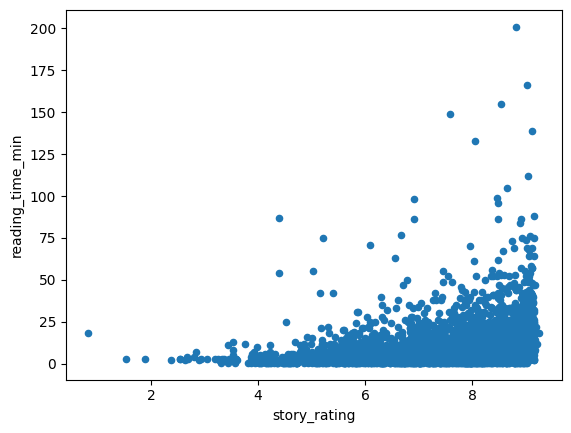

In [324]:
stories_df.plot.scatter(y="reading_time_min", x="story_rating")